<a href="https://colab.research.google.com/github/enicaking/bluetab-uc3m-project-repo/blob/main/Bluetab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

<center>

<h1><b>Fraud Detection Project</b></h1>
<h3>Universidad Carlos III de Madrid · Bluetab</h3>

<p><em>Development of a predictive system using Machine Learning to identify fraudulent transactions and strengthen financial security.</em></p>

</center>

---

### Notebook Overview

This notebook is part of the *Bluetab–UC3M Fraud Detection Project*.  
Its main goal is to explore and merge the different datasets provided by the company (`customers_dirty.csv`, `transactions_dirty.csv`, `locations_dirty.csv`, and `creditcard.csv`) to build a clean and unified database for further analysis.  

Throughout this notebook, we:
- Load and inspect the raw data.  
- Perform initial cleaning and consistency checks.  
- Merge datasets into a single structured DataFrame.  
- EDA


---


# **Libraries**

In [1]:
!pip install pvlib
!pip install catboost
!pip install chardet
!pip install xgboost
!pip install polars
!pip install lightgbm
!pip install tabulate
!pip install imbalanced-learn
!pip install scikit-learn
!pip install collections

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.5 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [2]:
import sys
import time
import warnings
import chardet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import os
from IPython.display import display

from datetime import datetime, timedelta
from itertools import combinations
from pytz import timezone

from tqdm import tqdm
from tqdm.auto import tqdm

from pvlib.location import Location
from scipy.stats import pearsonr


from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import lightgbm as lgbm
from catboost import CatBoostRegressor, CatBoostClassifier

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTENC

np.random.seed(123)

# **Upload the datasets**

In [3]:
# If working locally
# credit_df = pd.read_csv('content/creditcard.csv')
# transactions_df = pd.read_csv('content/transactions_dirty.csv')
# locations_df = pd.read_csv('content/locations_dirty.csv')
# customers_df = pd.read_csv('content/customers_dirty.csv')

In [4]:
# If working on Colab
transactions_df = pd.read_csv('/content/transactions_dirty.csv')
locations_df = pd.read_csv('/content/locations_dirty.csv')
customers_df = pd.read_csv('/content/customers_dirty.csv')
flags_df = pd.read_csv('/content/flags.csv')
time_table_df = pd.read_csv('/content/time_table.csv')
devices_df = pd.read_csv('/content/devices.csv')

# **1. Raw Data Exploration**
This section focuses on the initial exploration of the four raw datasets provided by Bluetab: `customers_dirty.csv`, `transactions_dirty.csv`, `locations_dirty.csv`, and `creditcard.csv`.

The objective is to understand the structure, quality, and characteristics of each dataset, performing an EDA of each one. By analyzing them separately, we can identify inconsistencies, missing values, duplicates, and potential variables of interest for the fraud detection model.

## **Transactions**

In [5]:
display(transactions_df.head())
transactions_df.shape

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V24       V25       V26       V27  \
0  0.098698  0.363787  0.090794  ...  0.066928  0.128539 -0.189115  0.133558   
1  0.085102 -0.255425 -0.166974  ... -0.339846  0.167170  0.125895 -0.008983   
2  0.247676 -1.514654  0.207643  ... -0.689281 -0.327642 -0.139097 -0.055353   
3  0.377436 -1.387024 -0.054952  ... -1.175575  0.647376 -0.221929  0.062723   
4 -0.270533  0.817739  0.753074  ...  0.141267 -0.206010  0.502292  0.219422   

        V28  Amount  Class                        transaction_id  customer_id  \
0 -0.021053  149.62      0  822947e3-96bc-4124-8e77-75fc791a6308         1102   
1  0.014724    2.69      0  107b9ba3-0cd1-48ab-b548-ed6282de31af         1435   
2 -0.059752  378.66      0  64a68036-03d7-434f-b4e9-6af563252772         1860   
3  0.061458  123.50      0  b3fcacd4-a564-479a-a9b9-cd04d10efed5         1270   
4  0.215153   69.99      0  2a51fbde-2f19-4ea5-bb7e-cefb24cabd36         1106   

   device_id  
0   DEV_0004  
1   DEV_0039  
2   DEV_0035  
3   DEV_0001  
4   DEV_0024  

[5 rows x 33 columns]

(286815, 33)

In [6]:
print(transactions_df['transaction_id'].duplicated().sum())

500


In [7]:
transactions_df.drop_duplicates(inplace=True) # Complete equal rows are dropped
print(transactions_df['transaction_id'].duplicated().sum()) # There are 3 repeated ids in rows not completely equal

3


In [8]:
duplicated_transactions = transactions_df[transactions_df['transaction_id'].duplicated(keep=False)] # Get all rows with duplicated transaction IDs
print("Duplicated transaction IDs in transactions_df:")
print(duplicated_transactions)

Duplicated transaction IDs in transactions_df:
              V1        V2        V3        V4        V5        V6        V7  \
13213  -2.039728  0.965692  2.166568 -0.005581 -0.086848 -0.098832 -0.216829   
31857  -1.185284  0.512991  2.057373  0.376168  0.234964  0.104018  0.140999   
128428 -1.236607  0.610138  1.576652  1.282104 -0.265792 -0.374496 -0.268472   
286366 -1.236607  0.610138  1.576652  1.282104 -0.265792 -0.374496 -0.268472   
286537 -2.039728  0.965692  2.166568 -0.005581 -0.086848 -0.098832 -0.216829   
286783 -1.185284  0.512991  2.057373  0.376168  0.234964  0.104018  0.140999   

              V8        V9       V10  ...       V24       V25       V26  \
13213   0.198205  1.605322  0.364846  ...  0.157698 -0.031629  0.211652   
31857   0.329286 -0.358042 -0.077797  ... -0.025780 -0.152223 -0.523562   
128428  0.471094 -0.561624 -0.352570  ...  0.454560 -0.392421 -0.232860   
286366  0.471094 -0.561624 -0.352570  ...  0.454560 -0.392421 -0.232860   
286537  0.198205 

The amount is the same, the customer and device id are different and it is impossible to have two equal transaction ids, so we compared with other database.

In [9]:
duplicated_df = transactions_df[transactions_df['transaction_id'].duplicated(keep=False)].copy()
aux = pd.merge(duplicated_df, customers_df, on='customer_id', how='inner')
display(aux)

V1        V2        V3        V4        V5        V6        V7  \
0 -2.039728  0.965692  2.166568 -0.005581 -0.086848 -0.098832 -0.216829   
1 -1.236607  0.610138  1.576652  1.282104 -0.265792 -0.374496 -0.268472   
2 -1.185284  0.512991  2.057373  0.376168  0.234964  0.104018  0.140999   

         V8        V9       V10  ...                        transaction_id  \
0  0.198205  1.605322  0.364846  ...  a995c6a8-ef9d-4c4f-928d-7149a5549fc8   
1  0.471094 -0.561624 -0.352570  ...  70a09c87-2693-4455-9373-01c07f4cbc65   
2  0.329286 -0.358042 -0.077797  ...  7dd260b9-5836-4d26-9163-ceff19cee458   

   customer_id  device_id               name  age                       email  \
0         1163   DEV_0100     Ariel Sandoval   70                         NaN   
1         1955   DEV_0089  Anthony Rodriguez   38         xmalone@example.org   
2         1617   DEV_0038     Virginia Casey   33  carpenterjorge@example.net   

               phone     country  credit_score   join_date  
0  689.731.8692x8972      Serbia           787  2021-09-17  
1   611-818-2422x412   Greenland           702  2023-08-27  
2   001-821-229-9642  Luxembourg           493  2022-06-20  

[3 rows x 40 columns]

In [10]:
# Remove the rows which are incorrect (the customer_id does not match in the transaction database with the customer database)
transactions_df = transactions_df[~(
    (transactions_df['transaction_id'] == "a995c6a8-ef9d-4c4f-928d-7149a5549fc8") &
    (transactions_df['customer_id'] == 99180)
)]

transactions_df = transactions_df[~(
    (transactions_df['transaction_id'] == "70a09c87-2693-4455-9373-01c07f4cbc65") &
    (transactions_df['customer_id'] == 99172)
)]

transactions_df = transactions_df[~(
    (transactions_df['transaction_id'] == "7dd260b9-5836-4d26-9163-ceff19cee458") &
    (transactions_df['customer_id'] == 99209)
)]

In [11]:
print(transactions_df.shape)

(286315, 33)


## **Locations**

In [12]:
display(locations_df.head())
locations_df.shape

transaction_id       ip_address    country  \
0  822947e3-96bc-4124-8e77-75fc791a6308     83.63.232.13  Australia   
1  107b9ba3-0cd1-48ab-b548-ed6282de31af    89.213.161.51  Australia   
2  64a68036-03d7-434f-b4e9-6af563252772    140.231.3.186     France   
3  b3fcacd4-a564-479a-a9b9-cd04d10efed5    40.46.209.108    Germany   
4  2a51fbde-2f19-4ea5-bb7e-cefb24cabd36  174.155.184.108  Australia   

        city  zip_code         merchant  
0      Perth       NaN     Davis-Parker  
1      Perth   57376.0  Garcia-Mitchell  
2       Lyon   19277.0      Mccann-Snow  
3     Berlin   93260.0        Jones Inc  
4  Melbourne   97401.0    Rodriguez Inc

(286315, 6)

In [51]:
print(locations_df['transaction_id'].duplicated().sum())

110524


## **Customers**

In [14]:
display(customers_df.head())
customers_df.shape

customer_id             name  age                       email  \
0         1102     Allison Hill   56       qjacobson@example.org   
1         1435      Noah Rhodes   69          ylopez@example.com   
2         1860  Angie Henderson   46       seanbaker@example.com   
3         1270    Daniel Wagner   32        jeremy49@example.org   
4         1106  Cristian Santos   60  karencontreras@example.org   

               phone           country  credit_score   join_date  
0         6502166799            Gambia           787  2024-03-18  
1  767.389.9730x8069           Georgia           582  2021-09-04  
2   567-917-9576x024           Mayotte           765  2023-11-19  
3  (873)783-9597x246  Papua New Guinea           612  2021-02-23  
4  329.834.1722x3297            Serbia           580  2021-04-17

(1000, 8)

In [15]:
print(customers_df['customer_id'].duplicated().sum())

0


## **Flags**

In [16]:
display(flags_df.head())
flags_df.shape

transaction_id  is_foreign_tx  is_night_tx  \
0  822947e3-96bc-4124-8e77-75fc791a6308              1            1   
1  107b9ba3-0cd1-48ab-b548-ed6282de31af              1            1   
2  64a68036-03d7-434f-b4e9-6af563252772              1            1   
3  b3fcacd4-a564-479a-a9b9-cd04d10efed5              1            1   
4  2a51fbde-2f19-4ea5-bb7e-cefb24cabd36              1            1   

   is_high_amount  
0               0  
1               0  
2               0  
3               0  
4               0

(286315, 4)

In [17]:
print(flags_df['transaction_id'].duplicated().sum())

0


## **Time-table**

In [18]:
display(time_table_df.head())
time_table_df.shape

transaction_id            timestamp  hour  \
0  822947e3-96bc-4124-8e77-75fc791a6308  2023-01-01 00:00:00     0   
1  107b9ba3-0cd1-48ab-b548-ed6282de31af  2023-01-01 00:00:00     0   
2  64a68036-03d7-434f-b4e9-6af563252772  2023-01-01 00:00:01     0   
3  b3fcacd4-a564-479a-a9b9-cd04d10efed5  2023-01-01 00:00:01     0   
4  2a51fbde-2f19-4ea5-bb7e-cefb24cabd36  2023-01-01 00:00:02     0   

   day_of_week  is_weekend  month time_of_day  
0            6           1      1       Night  
1            6           1      1       Night  
2            6           1      1       Night  
3            6           1      1       Night  
4            6           1      1       Night

(286315, 7)

In [19]:
print(time_table_df['transaction_id'].duplicated().sum())

0


## **Devices**

In [47]:
display(devices_df.head())
devices_df.shape

device_id device_type       os  browser  is_mobile
0  DEV_0001     Desktop    macOS   Chrome          0
1  DEV_0002         POS  Android  Firefox          0
2  DEV_0003         ATM    Linux   Chrome          0
3  DEV_0004     Desktop  Windows   Safari          0
4  DEV_0005         POS  Android   Safari          0

(100, 5)

In [54]:
print(devices_df['device_id'].duplicated().sum())

0


# **2. Data Merging and Integration**
This section combines the different raw datasets into a single unified structure, linking transactions, customers, locations (*TODO: and credit card features.*)
The goal is to build a consistent and complete dataset that can be used for global exploratory analysis and model development.

In [22]:
merged_df = pd.merge(transactions_df, locations_df, on='transaction_id', how='inner')
print(merged_df.shape)

(286315, 38)


In [23]:
merge2_df = pd.merge(merged_df, flags_df, on='transaction_id', how='inner')
display(merge2_df.head())
print(merge2_df.shape)

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...  customer_id  device_id       ip_address  \
0  0.098698  0.363787  0.090794  ...         1102   DEV_0004     83.63.232.13   
1  0.085102 -0.255425 -0.166974  ...         1435   DEV_0039    89.213.161.51   
2  0.247676 -1.514654  0.207643  ...         1860   DEV_0035    140.231.3.186   
3  0.377436 -1.387024 -0.054952  ...         1270   DEV_0001    40.46.209.108   
4 -0.270533  0.817739  0.753074  ...         1106   DEV_0024  174.155.184.108   

     country       city  zip_code         merchant  is_foreign_tx  \
0  Australia      Perth       NaN     Davis-Parker              1   
1  Australia      Perth   57376.0  Garcia-Mitchell              1   
2     France       Lyon   19277.0      Mccann-Snow              1   
3    Germany     Berlin   93260.0        Jones Inc              1   
4  Australia  Melbourne   97401.0    Rodriguez Inc              1   

   is_night_tx  is_high_amount  
0            1               0  
1            1               0  
2            1               0  
3            1               0  
4            1               0  

[5 rows x 41 columns]

(286315, 41)


In [24]:
merge3_df = pd.merge(merge2_df, time_table_df, on='transaction_id', how='inner')
display(merge3_df.head())
print(merge3_df.shape)

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...         merchant  is_foreign_tx  \
0  0.098698  0.363787  0.090794  ...     Davis-Parker              1   
1  0.085102 -0.255425 -0.166974  ...  Garcia-Mitchell              1   
2  0.247676 -1.514654  0.207643  ...      Mccann-Snow              1   
3  0.377436 -1.387024 -0.054952  ...        Jones Inc              1   
4 -0.270533  0.817739  0.753074  ...    Rodriguez Inc              1   

   is_night_tx  is_high_amount            timestamp  hour  day_of_week  \
0            1               0  2023-01-01 00:00:00     0            6   
1            1               0  2023-01-01 00:00:00     0            6   
2            1               0  2023-01-01 00:00:01     0            6   
3            1               0  2023-01-01 00:00:01     0            6   
4            1               0  2023-01-01 00:00:02     0            6   

   is_weekend  month  time_of_day  
0           1      1        Night  
1           1      1        Night  
2           1      1        Night  
3           1      1        Night  
4           1      1        Night  

[5 rows x 47 columns]

(286315, 47)


In [25]:
merge4_df = pd.merge(merge3_df, devices_df, on='device_id', how='inner')
display(merge4_df.head())
print(merge4_df.shape)

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...            timestamp  hour  day_of_week  \
0  0.098698  0.363787  0.090794  ...  2023-01-01 00:00:00     0            6   
1  0.085102 -0.255425 -0.166974  ...  2023-01-01 00:00:00     0            6   
2  0.247676 -1.514654  0.207643  ...  2023-01-01 00:00:01     0            6   
3  0.377436 -1.387024 -0.054952  ...  2023-01-01 00:00:01     0            6   
4 -0.270533  0.817739  0.753074  ...  2023-01-01 00:00:02     0            6   

   is_weekend  month  time_of_day  device_type       os  browser  is_mobile  
0           1      1        Night      Desktop  Windows   Safari          0  
1           1      1        Night       Mobile  Android  Firefox          1  
2           1      1        Night       Mobile  Android      NaN          1  
3           1      1        Night      Desktop    macOS   Chrome          0  
4           1      1        Night          ATM    Linux   Chrome          0  

[5 rows x 51 columns]

(286315, 51)


In [26]:
df = pd.merge(merge4_df, customers_df, on='customer_id', how='left')
display(df.head())
print(df.shape)

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       os  browser  is_mobile  \
0  0.098698  0.363787  0.090794  ...  Windows   Safari          0   
1  0.085102 -0.255425 -0.166974  ...  Android  Firefox          1   
2  0.247676 -1.514654  0.207643  ...  Android      NaN          1   
3  0.377436 -1.387024 -0.054952  ...    macOS   Chrome          0   
4 -0.270533  0.817739  0.753074  ...    Linux   Chrome          0   

              name   age                       email              phone  \
0     Allison Hill  56.0       qjacobson@example.org         6502166799   
1      Noah Rhodes  69.0          ylopez@example.com  767.389.9730x8069   
2  Angie Henderson  46.0       seanbaker@example.com   567-917-9576x024   
3    Daniel Wagner  32.0        jeremy49@example.org  (873)783-9597x246   
4  Cristian Santos  60.0  karencontreras@example.org  329.834.1722x3297   

          country_y  credit_score   join_date  
0            Gambia         787.0  2024-03-18  
1           Georgia         582.0  2021-09-04  
2           Mayotte         765.0  2023-11-19  
3  Papua New Guinea         612.0  2021-02-23  
4            Serbia         580.0  2021-04-17  

[5 rows x 58 columns]

(286315, 58)


# **3. Exploratory Data Analysis on Merged Dataset**

Now that we have our merged dataset, we take a closer look at each variable (boxplots and histograms for numerical variables, bar charts for non-numeric variables) and also gain a deeper understanding of the correlations between variables. Each variable was individually plotted in relation to the Fradulence Status, and then PCA, ranking and feature importance models were applied to understand the contribution of each variable to the overall model.

In [27]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286315 entries, 0 to 286314
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   V1              286315 non-null  float64
 1   V2              286315 non-null  float64
 2   V3              286315 non-null  float64
 3   V4              286315 non-null  float64
 4   V5              286315 non-null  float64
 5   V6              286315 non-null  float64
 6   V7              286315 non-null  float64
 7   V8              286315 non-null  float64
 8   V9              286315 non-null  float64
 9   V10             286315 non-null  float64
 10  V11             286315 non-null  float64
 11  V12             286315 non-null  float64
 12  V13             286315 non-null  float64
 13  V14             286315 non-null  float64
 14  V15             286315 non-null  float64
 15  V16             286315 non-null  float64
 16  V17             286315 non-null  float64
 17  V18       

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       os  browser  is_mobile  \
0  0.098698  0.363787  0.090794  ...  Windows   Safari          0   
1  0.085102 -0.255425 -0.166974  ...  Android  Firefox          1   
2  0.247676 -1.514654  0.207643  ...  Android      NaN          1   
3  0.377436 -1.387024 -0.054952  ...    macOS   Chrome          0   
4 -0.270533  0.817739  0.753074  ...    Linux   Chrome          0   

              name   age                       email              phone  \
0     Allison Hill  56.0       qjacobson@example.org         6502166799   
1      Noah Rhodes  69.0          ylopez@example.com  767.389.9730x8069   
2  Angie Henderson  46.0       seanbaker@example.com   567-917-9576x024   
3    Daniel Wagner  32.0        jeremy49@example.org  (873)783-9597x246   
4  Cristian Santos  60.0  karencontreras@example.org  329.834.1722x3297   

          country_y  credit_score   join_date  
0            Gambia         787.0  2024-03-18  
1           Georgia         582.0  2021-09-04  
2           Mayotte         765.0  2023-11-19  
3  Papua New Guinea         612.0  2021-02-23  
4            Serbia         580.0  2021-04-17  

[5 rows x 58 columns]

In [28]:
# We rename the country variables
df.rename(columns={'country_x': 'merchant_country'}, inplace=True)
df.rename(columns={'country_y': 'customer_country'}, inplace=True)

In [29]:
# We convert the variables we do not want as numeric
df["zip_code"] = df["zip_code"].astype("object")
df["customer_id"] = df["customer_id"].astype("object")
print(df.dtypes)

V1                  float64
V2                  float64
V3                  float64
V4                  float64
V5                  float64
V6                  float64
V7                  float64
V8                  float64
V9                  float64
V10                 float64
V11                 float64
V12                 float64
V13                 float64
V14                 float64
V15                 float64
V16                 float64
V17                 float64
V18                 float64
V19                 float64
V20                 float64
V21                 float64
V22                 float64
V23                 float64
V24                 float64
V25                 float64
V26                 float64
V27                 float64
V28                 float64
Amount              float64
Class                 int64
transaction_id       object
customer_id          object
device_id            object
ip_address           object
merchant_country     object
city                

Class
0    284315
1      2000
Name: count, dtype: int64


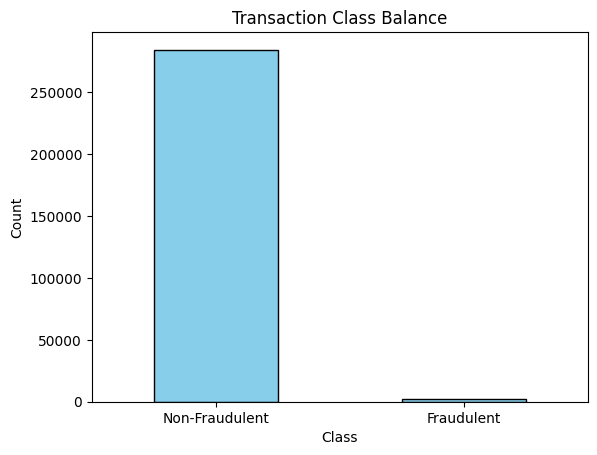

In [30]:
# We check the Class balance between Fraudulent and Non Fraudulent transactions
print(df["Class"].value_counts())
df["Class"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Transaction Class Balance")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Non-Fraudulent", "Fraudulent"], rotation=0)
plt.show()

In [61]:
numeric_vars = [
    'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
    'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
    'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
    'Amount', 'age', 'credit_score']
numeric_df = df[numeric_vars]

categoric_vars = ['ip_address', 'merchant_country', 'city', 'zip_code', 'merchant',
    'customer_country', 'month', 'hour', 'time_of_day', 'device_type', 'os', 'browser']
categoric_df = df[categoric_vars]

binary_vars = ['is_foreign_tx', 'is_night_tx', 'is_high_amount',
    'day_of_week', 'is_weekend', 'is_mobile']
binary_df = df[binary_vars]

target_vars = ['Class']
target_df = df[target_vars]

## Numeric Variables

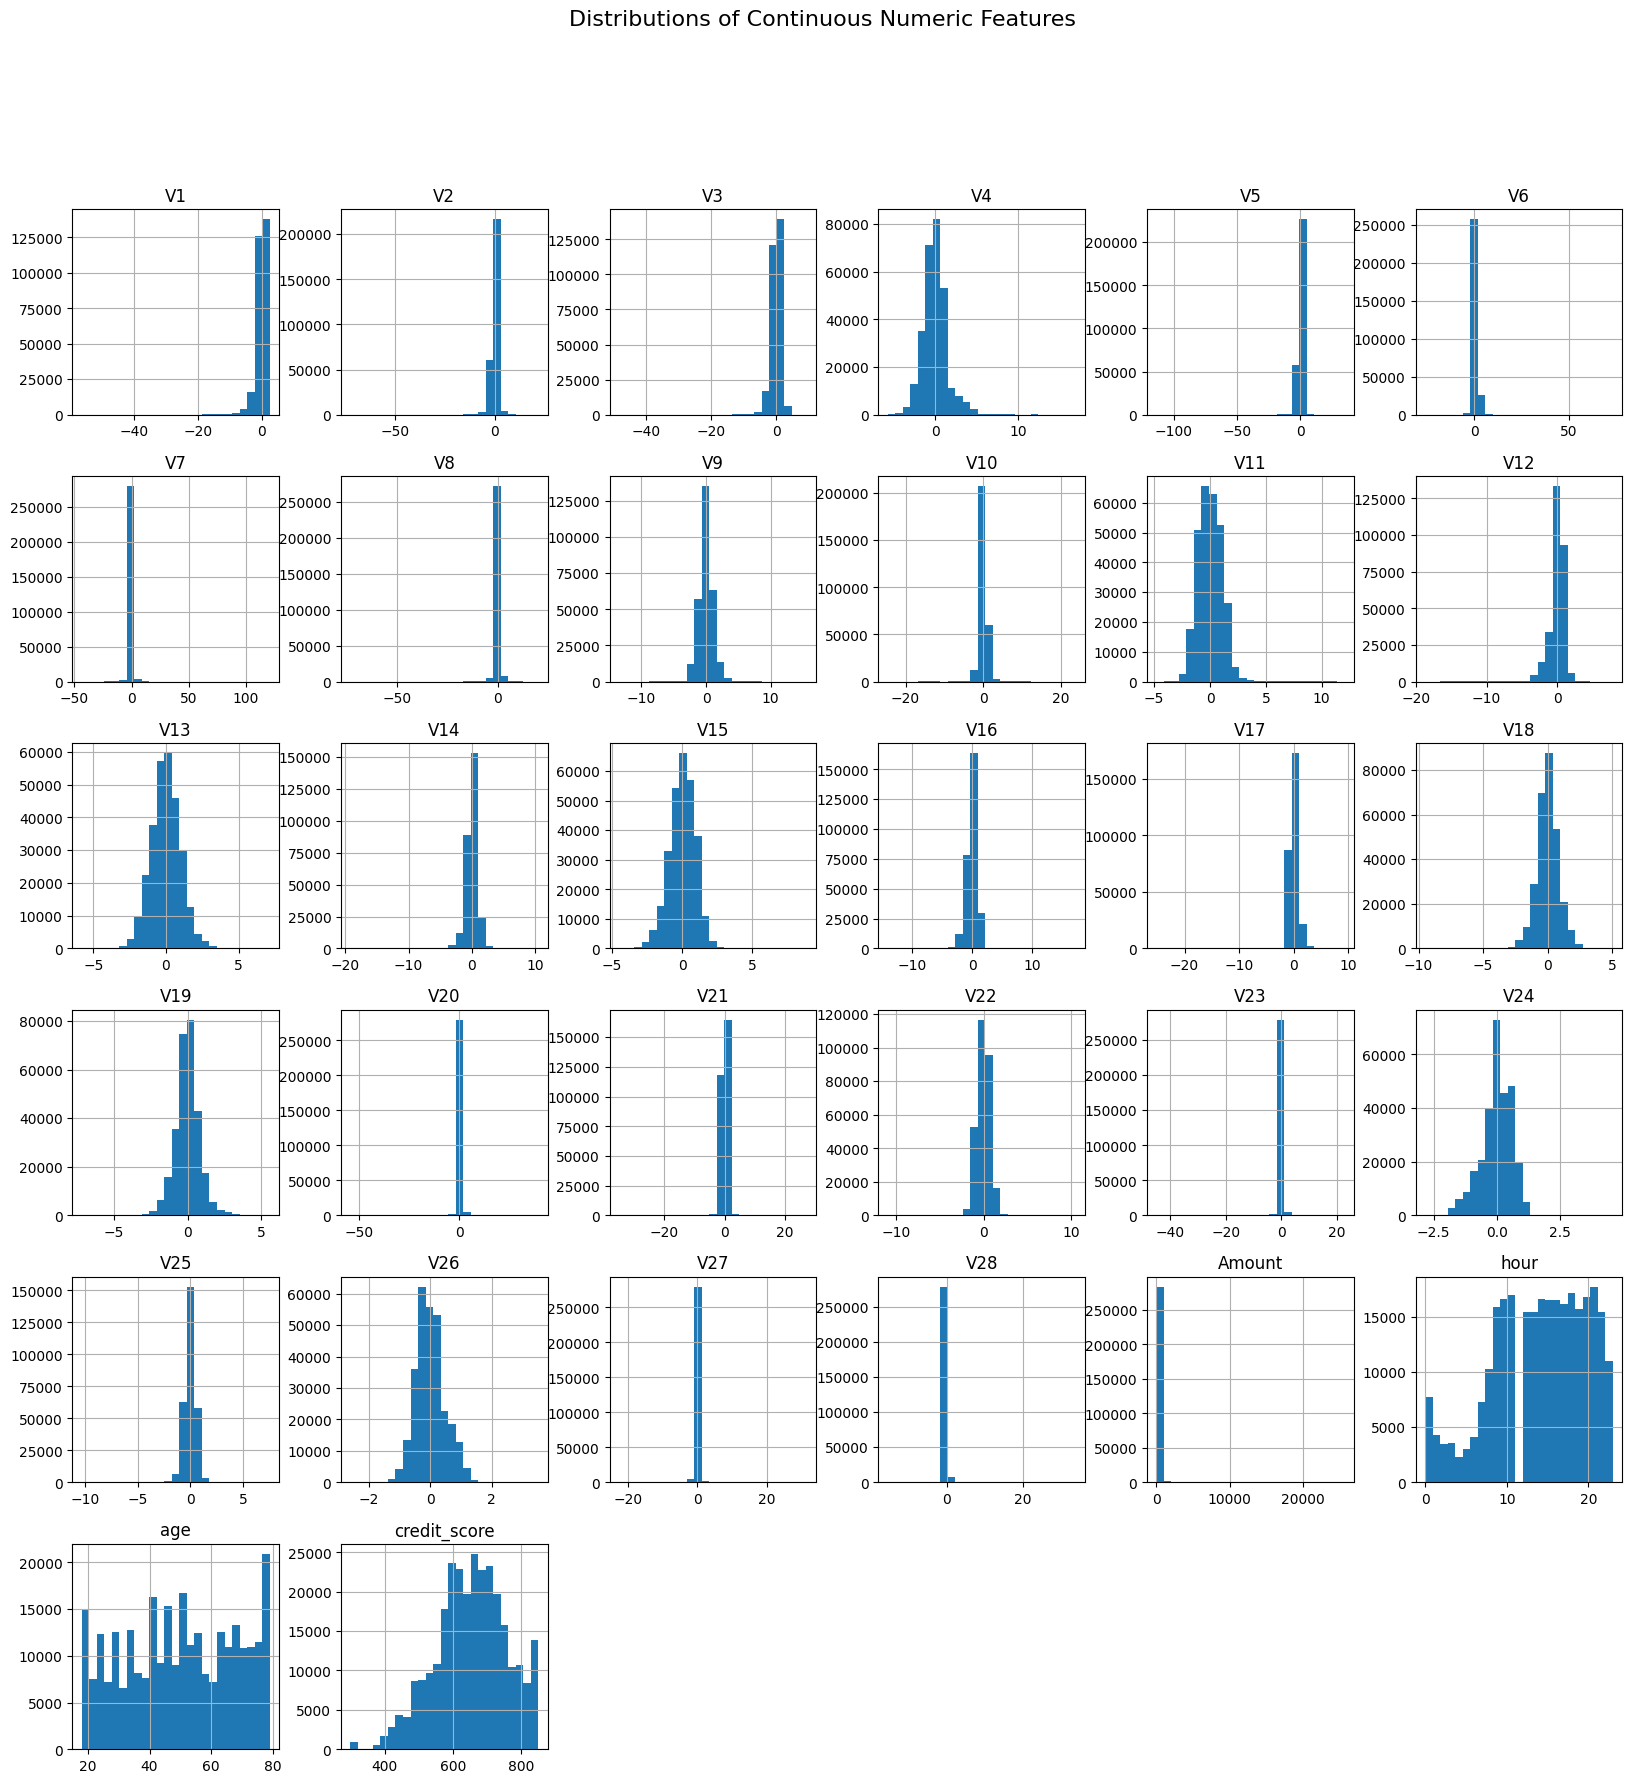

In [33]:
# Plot histograms for continuous numeric features
numeric_df.hist(figsize=(20, 20), bins=25)
plt.suptitle("Distributions of Continuous Numeric Features", fontsize=16)
plt.show()

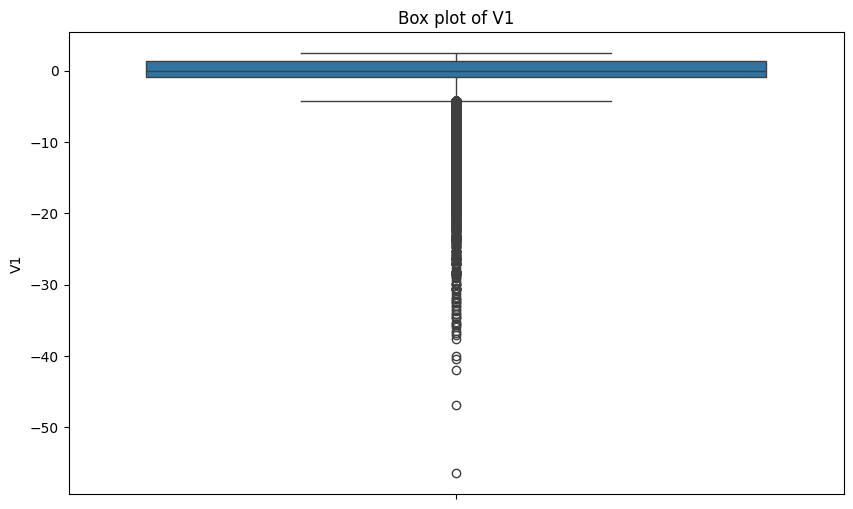

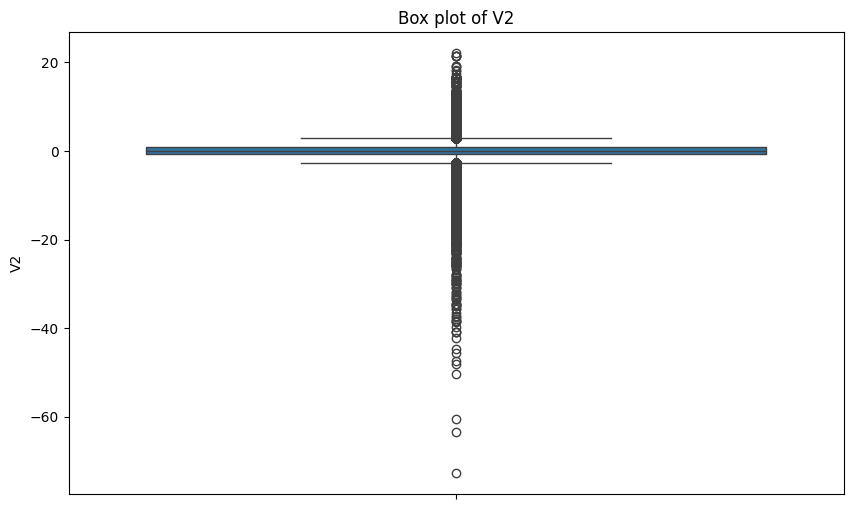

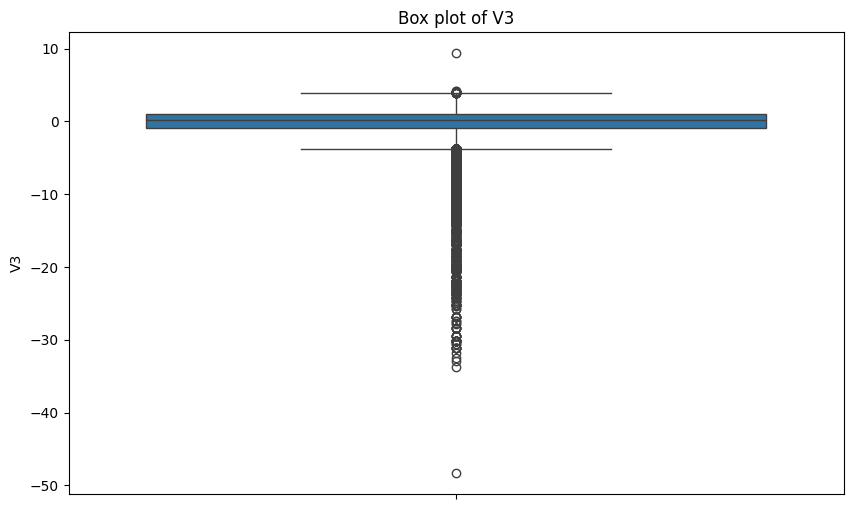

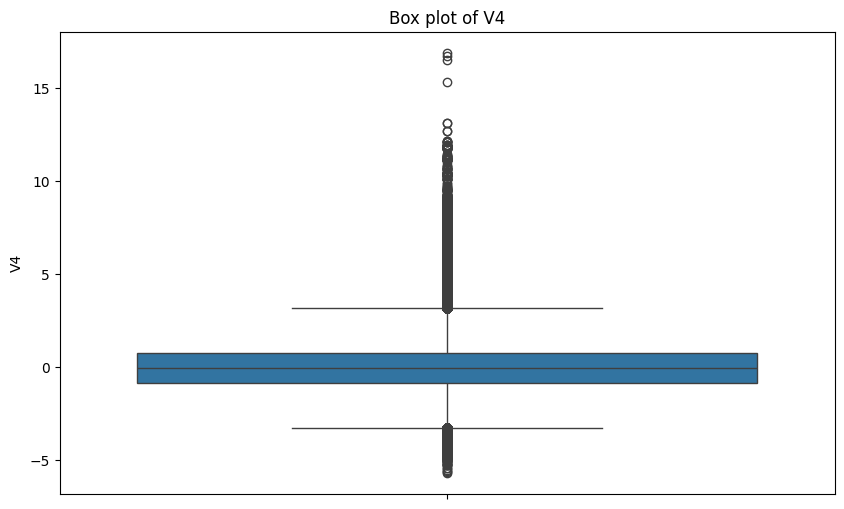

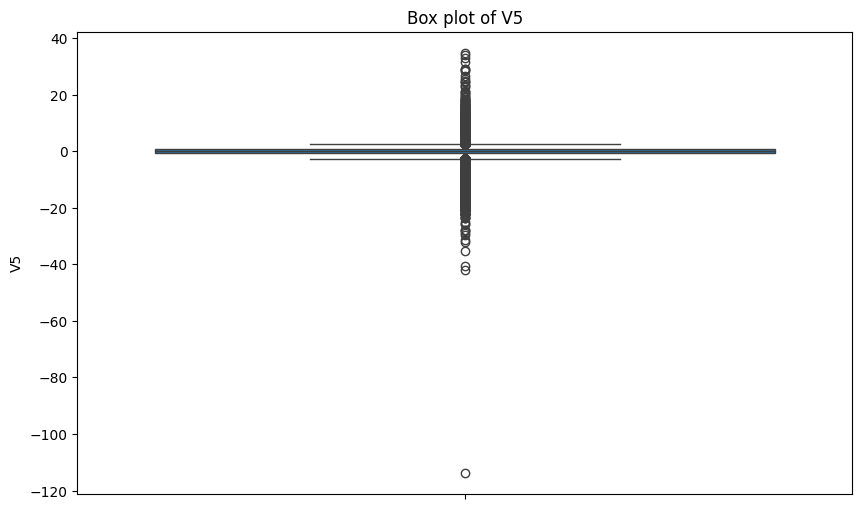

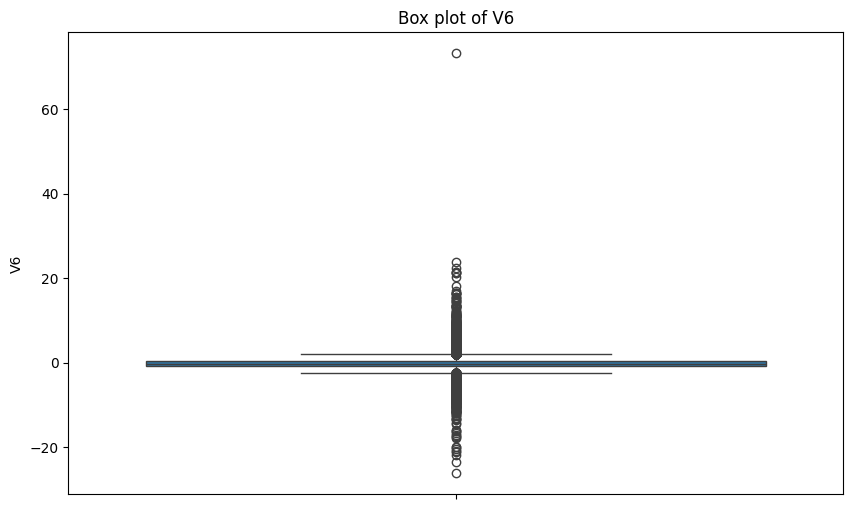

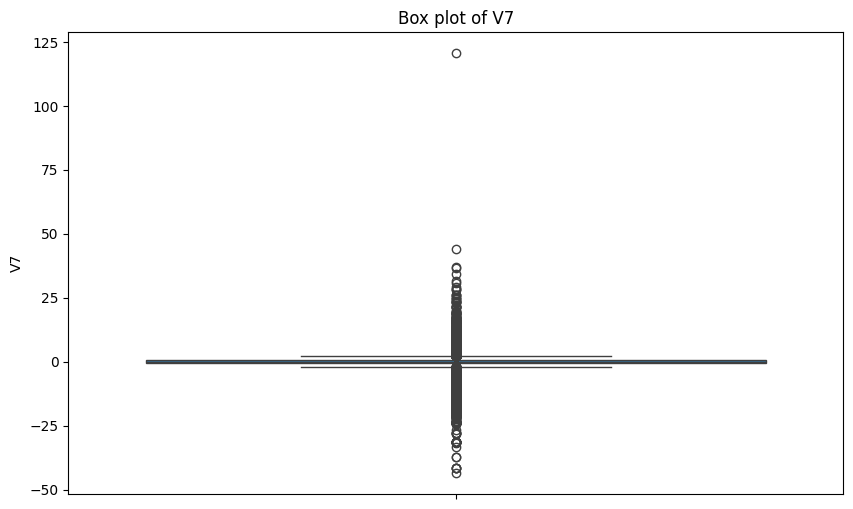

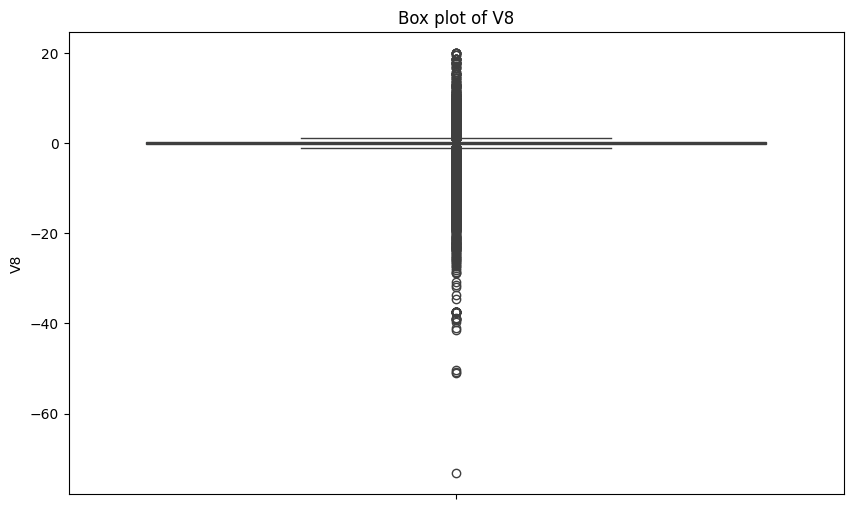

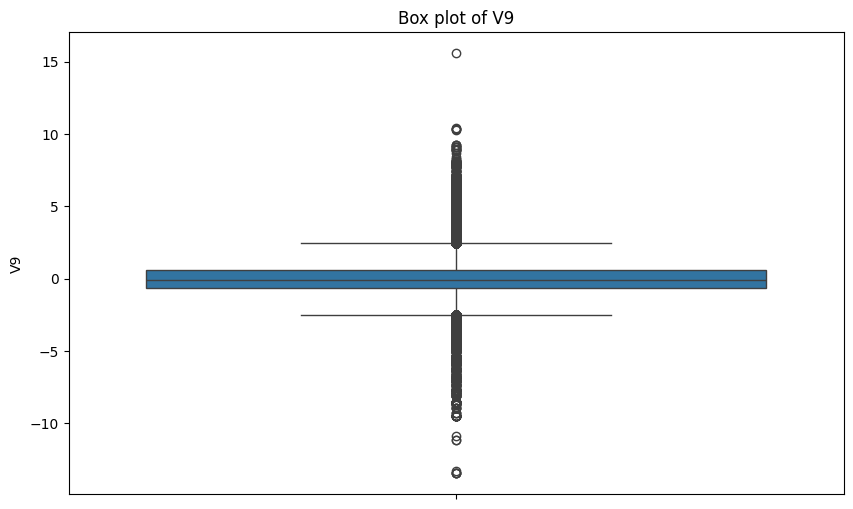

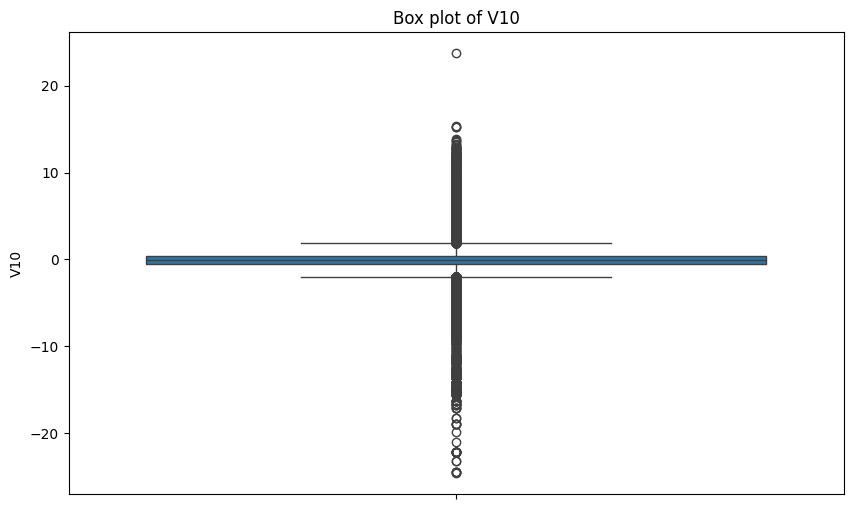

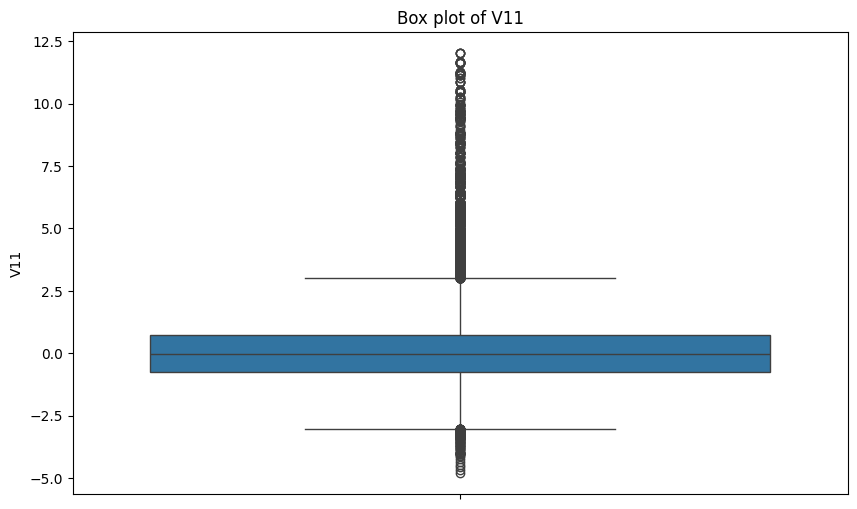

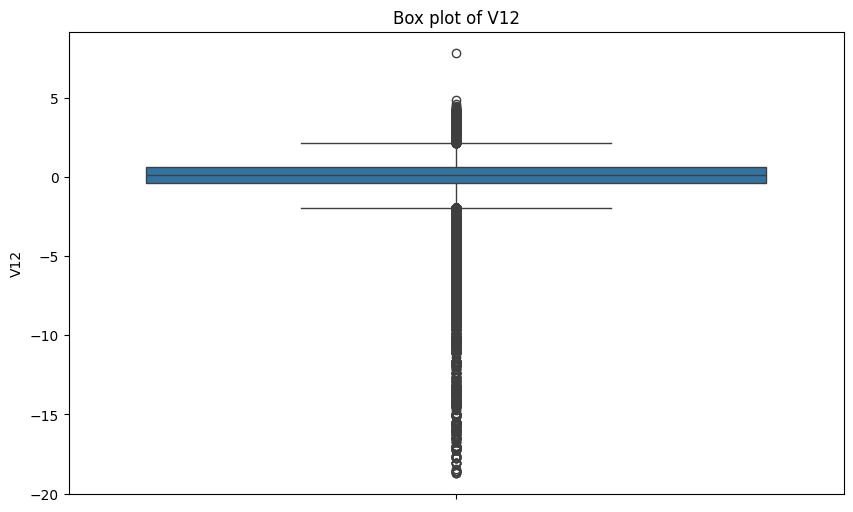

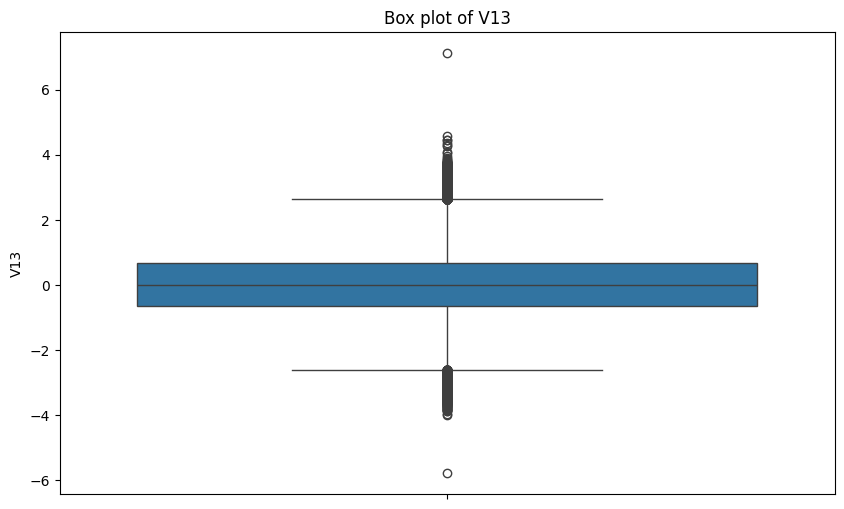

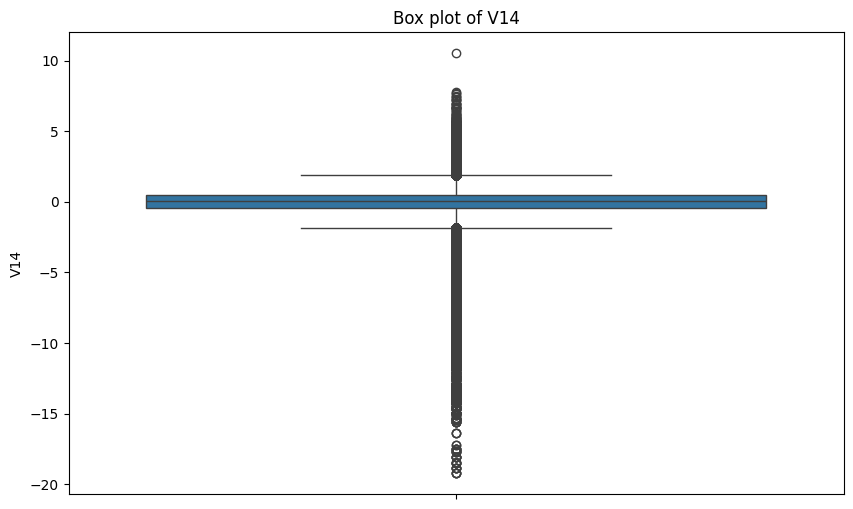

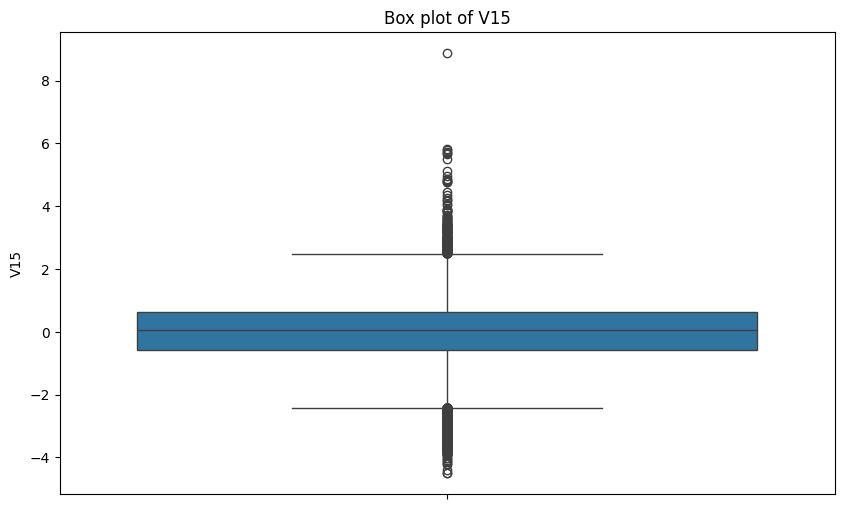

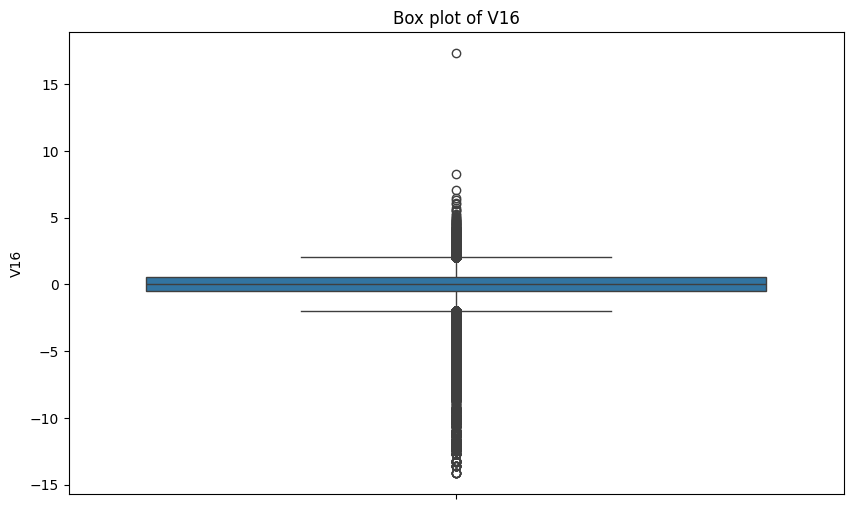

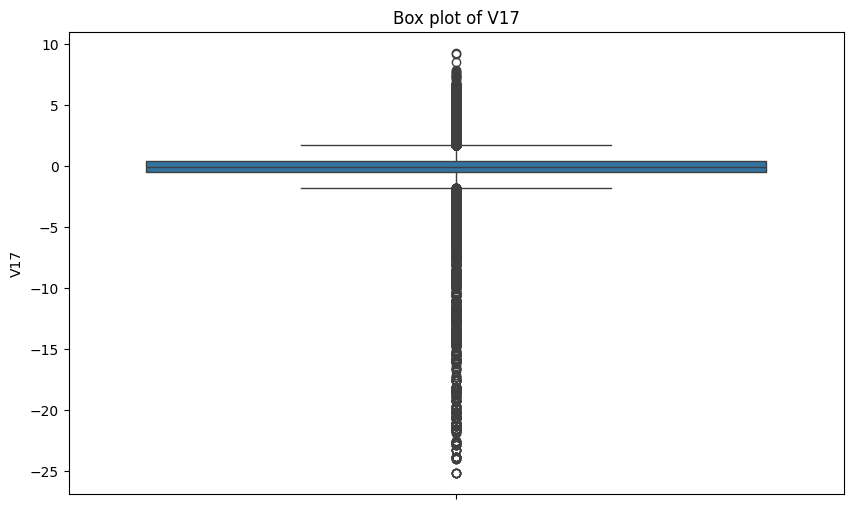

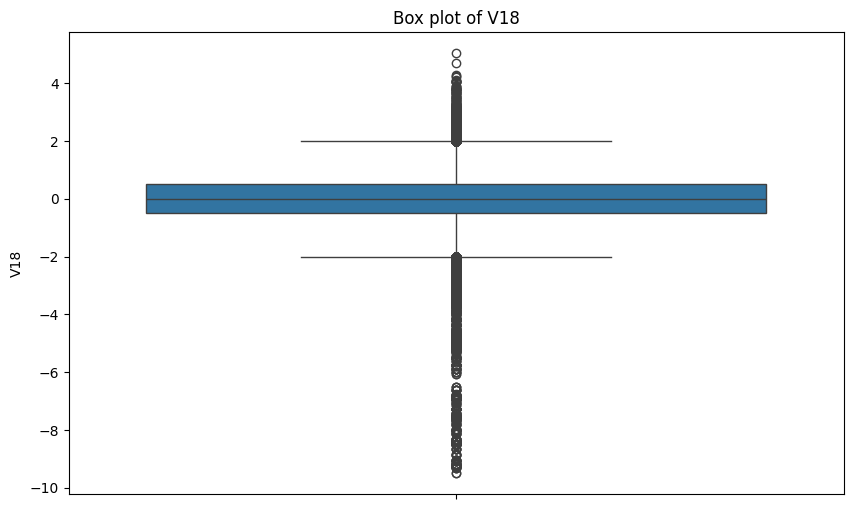

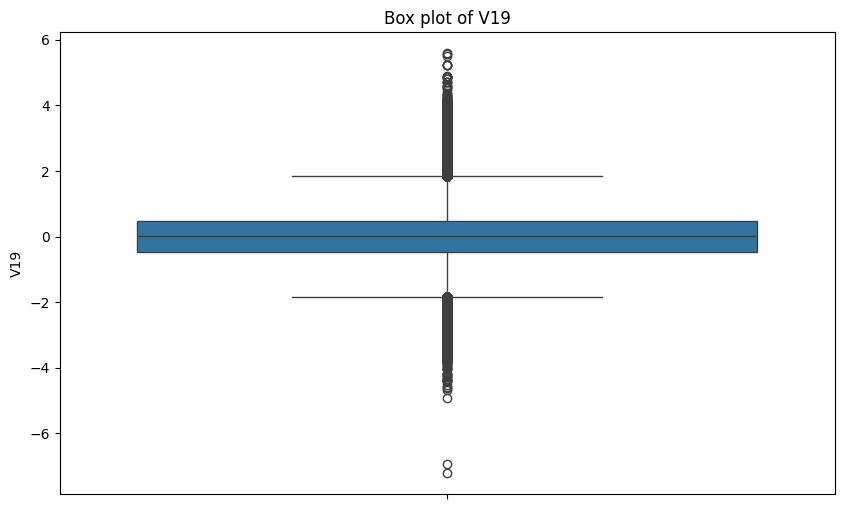

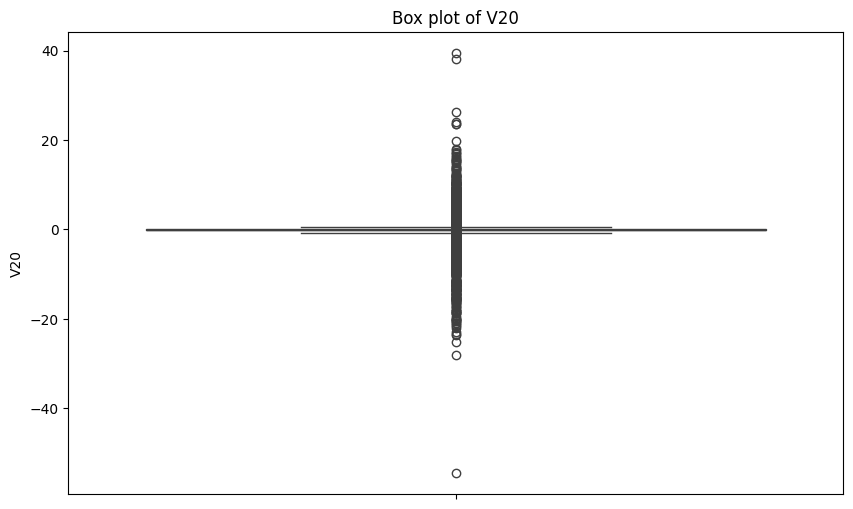

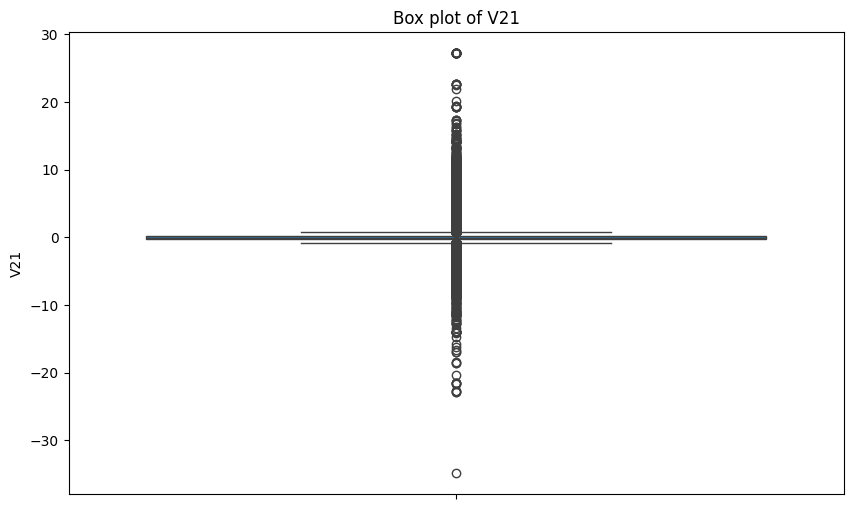

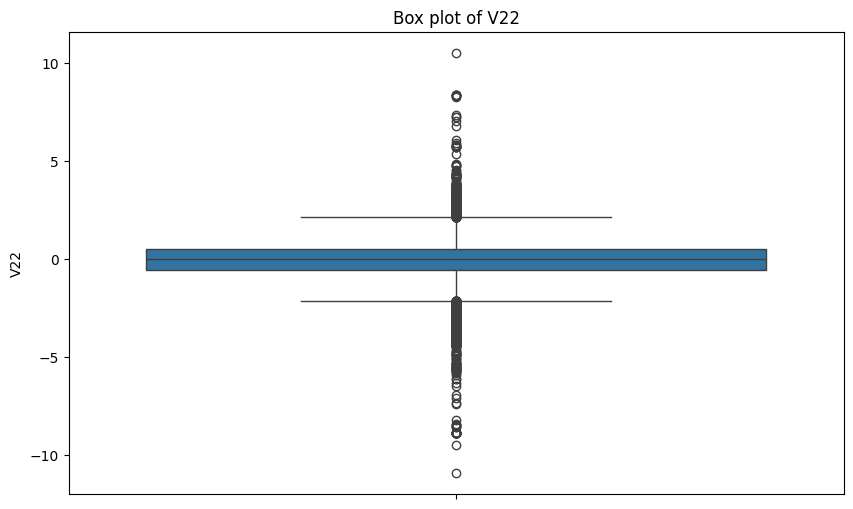

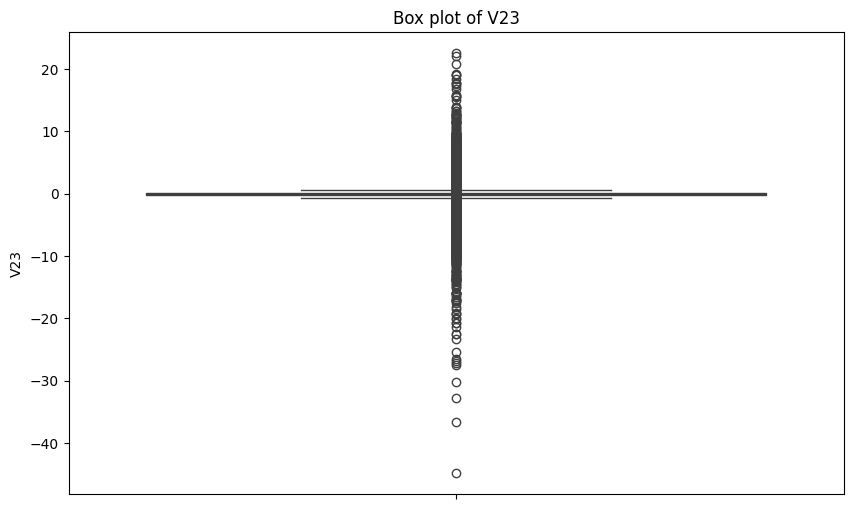

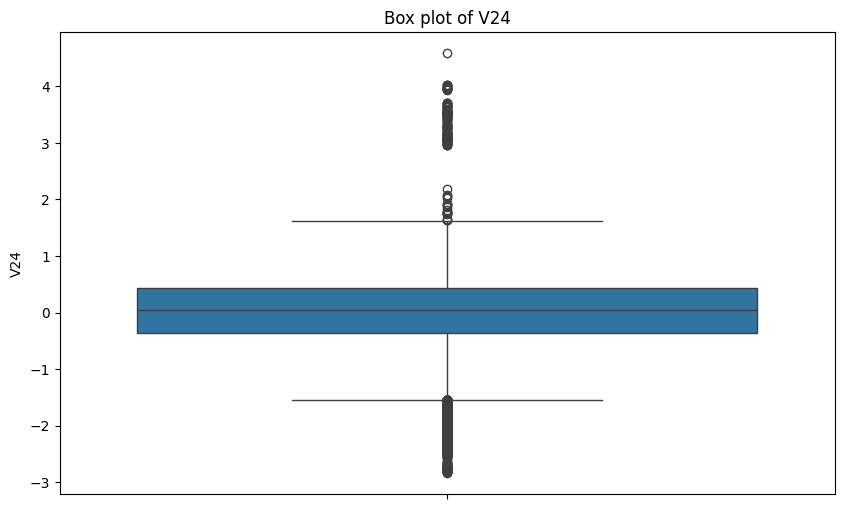

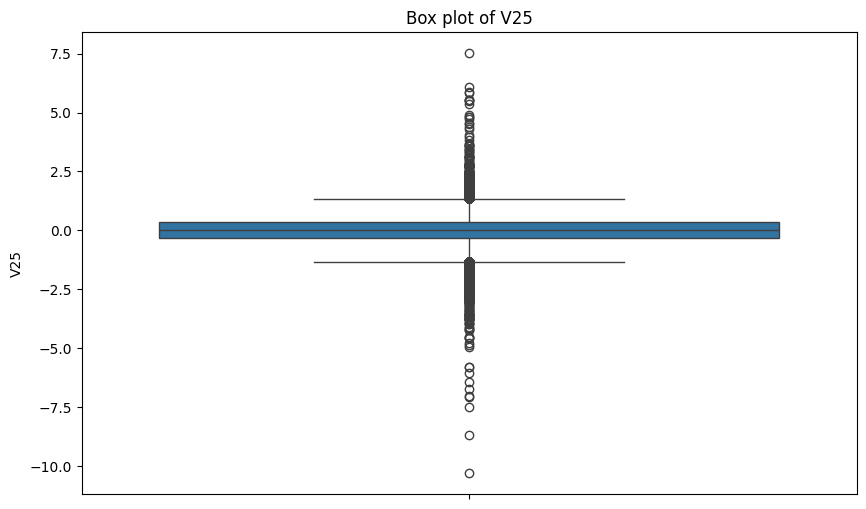

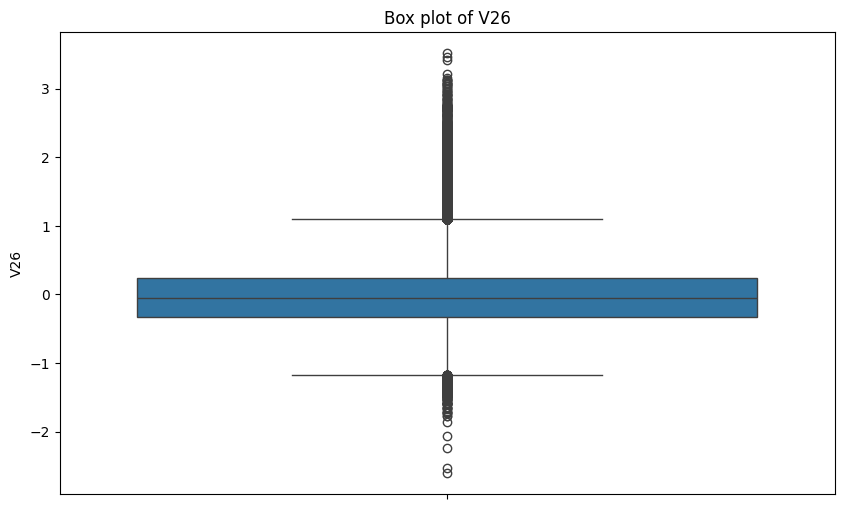

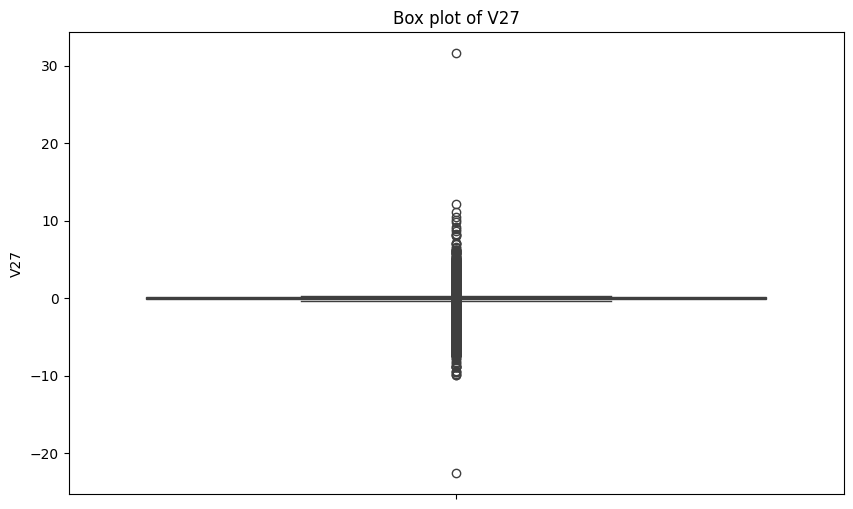

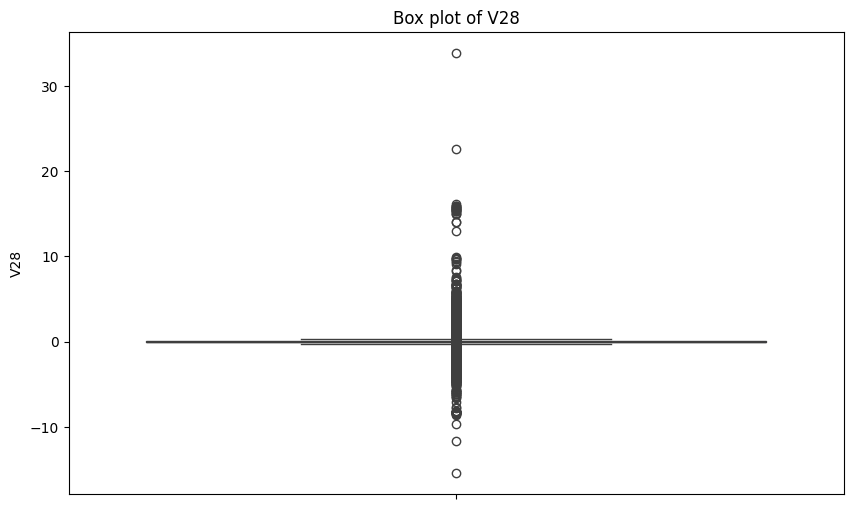

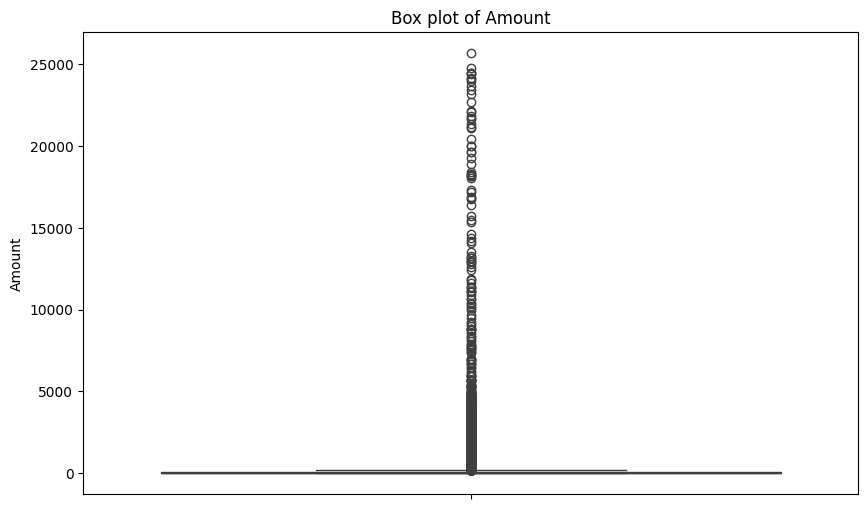

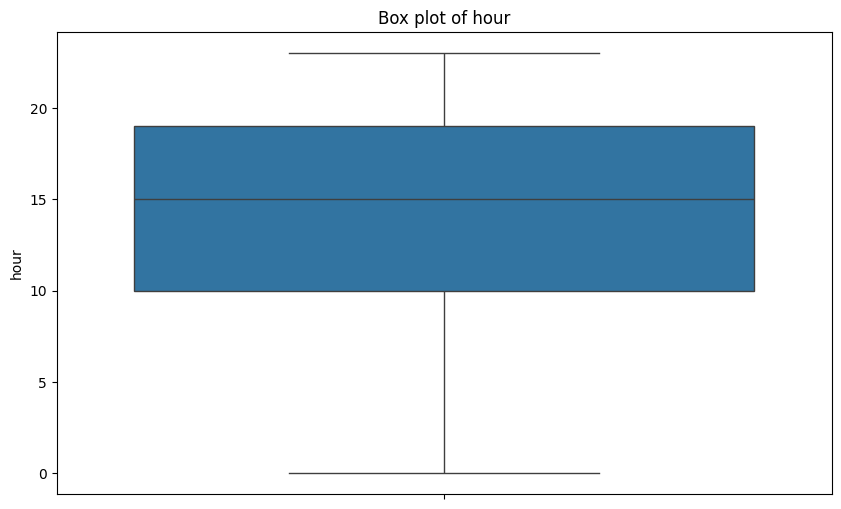

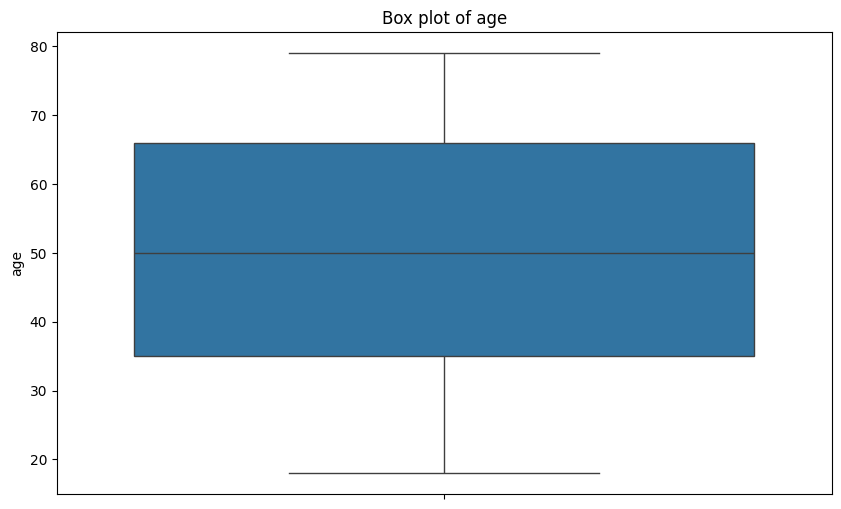

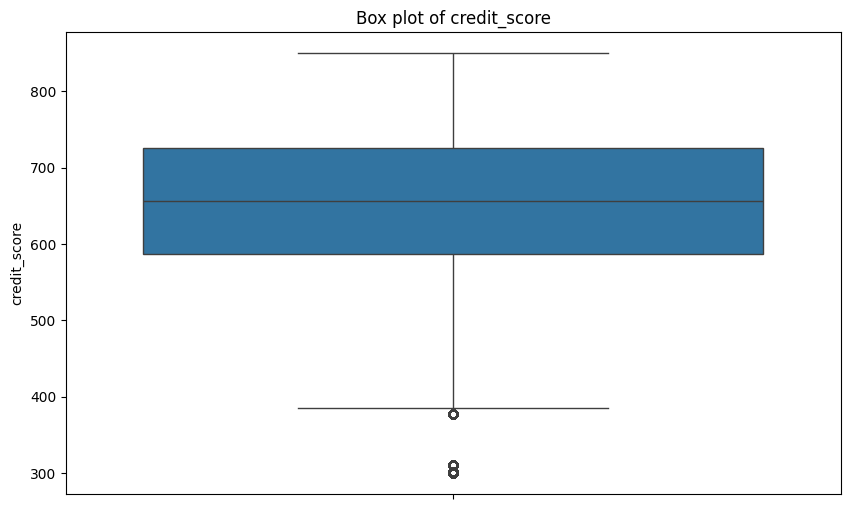

In [34]:
for col in numeric_df:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, y=col)
    plt.title(f'Box plot of {col}')
    plt.ylabel(col)
    plt.show()


Analysis for column: V1

Descriptive statistics:


count    286315.000000
mean         -0.024166
std           2.033031
min         -56.407510
25%          -0.929272
50%           0.009518
75%           1.313364
max           2.454930
Name: V1, dtype: float64

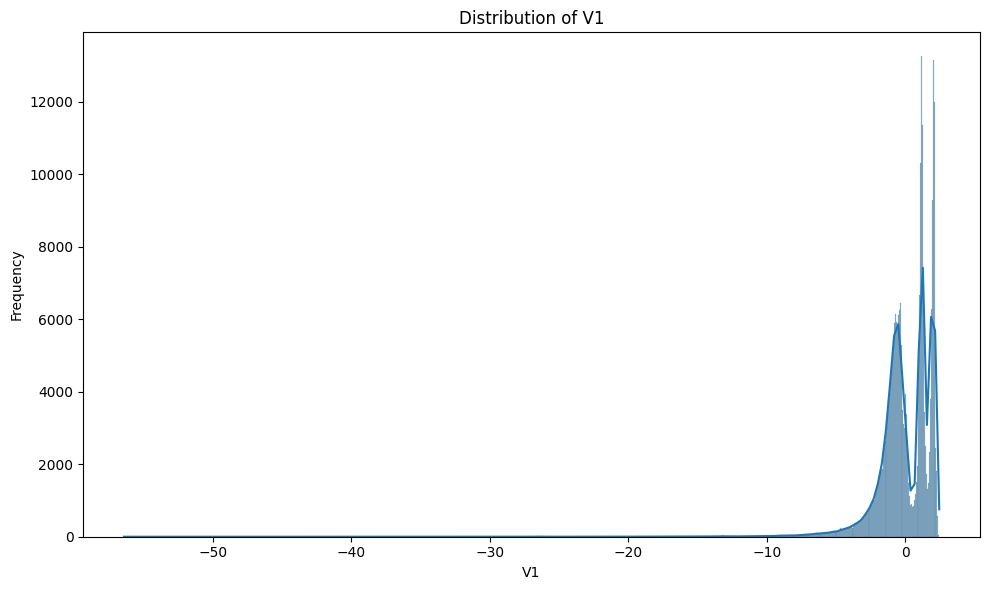

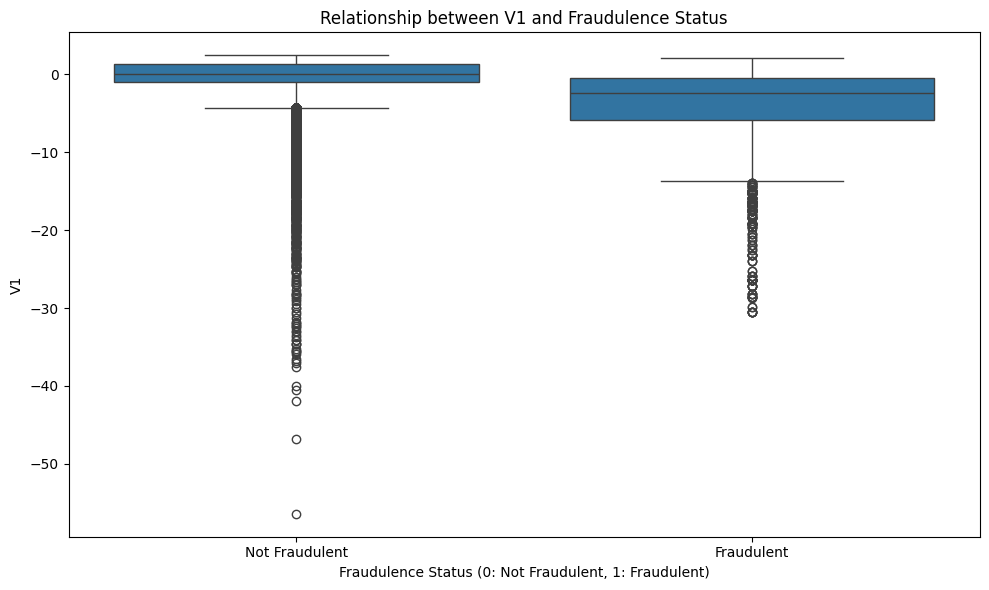


Analysis for column: V2

Descriptive statistics:


count    286315.000000
mean          0.018155
std           1.691744
min         -72.715728
25%          -0.595493
50%           0.070189
75%           0.813354
max          22.057729
Name: V2, dtype: float64

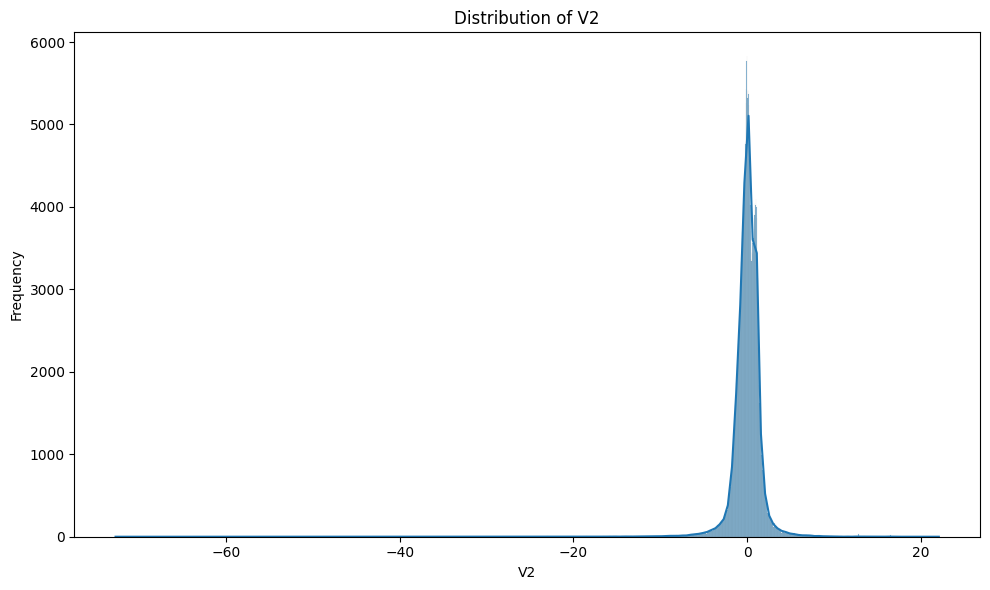

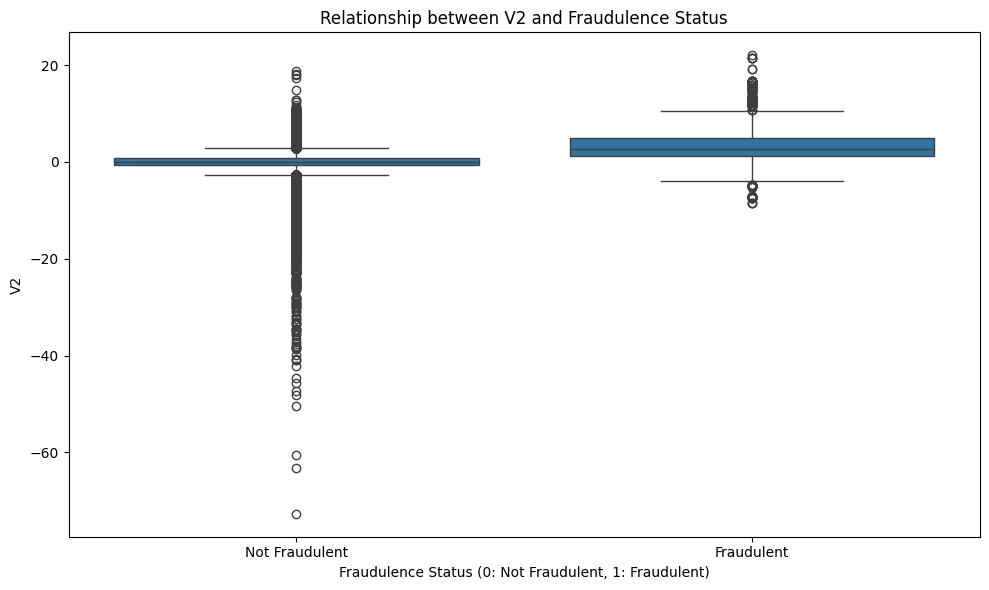


Analysis for column: V3

Descriptive statistics:


count    286315.000000
mean         -0.035505
std           1.664057
min         -48.325589
25%          -0.907409
50%           0.172793
75%           1.023179
max           9.382558
Name: V3, dtype: float64

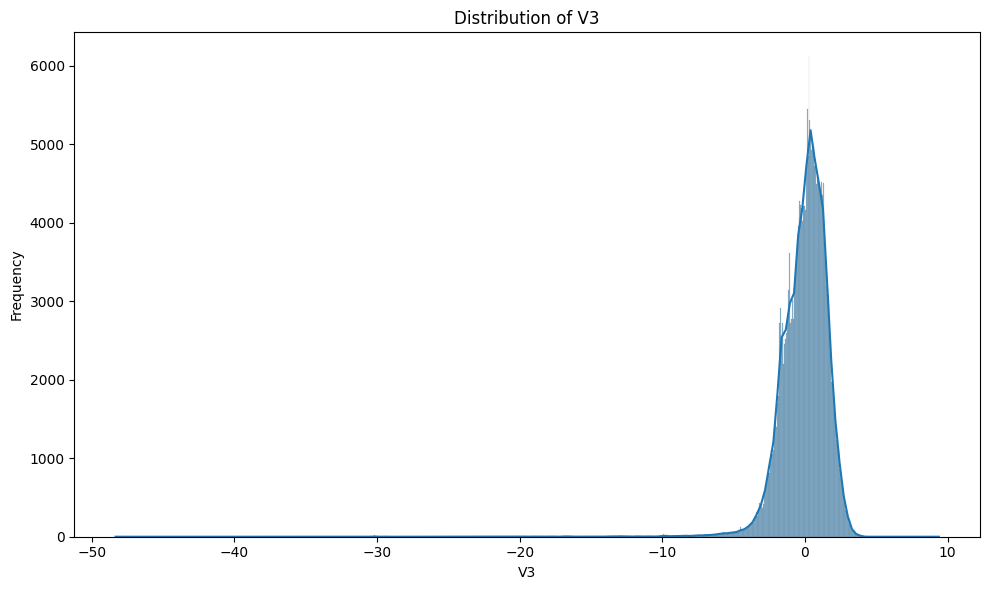

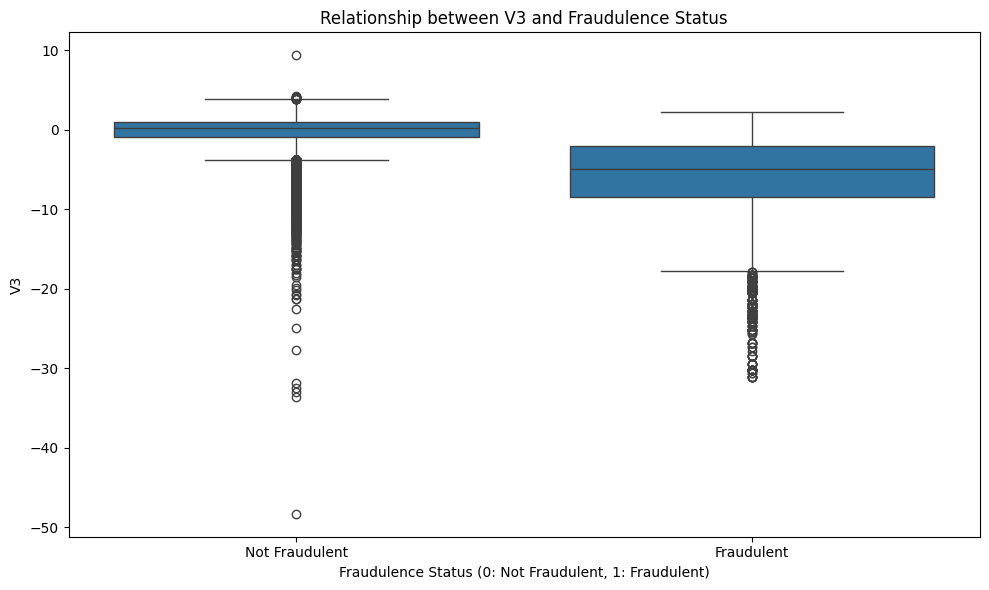


Analysis for column: V4

Descriptive statistics:


count    286315.000000
mean          0.023738
std           1.465026
min          -5.683171
25%          -0.843786
50%          -0.011537
75%           0.759227
max          16.875344
Name: V4, dtype: float64

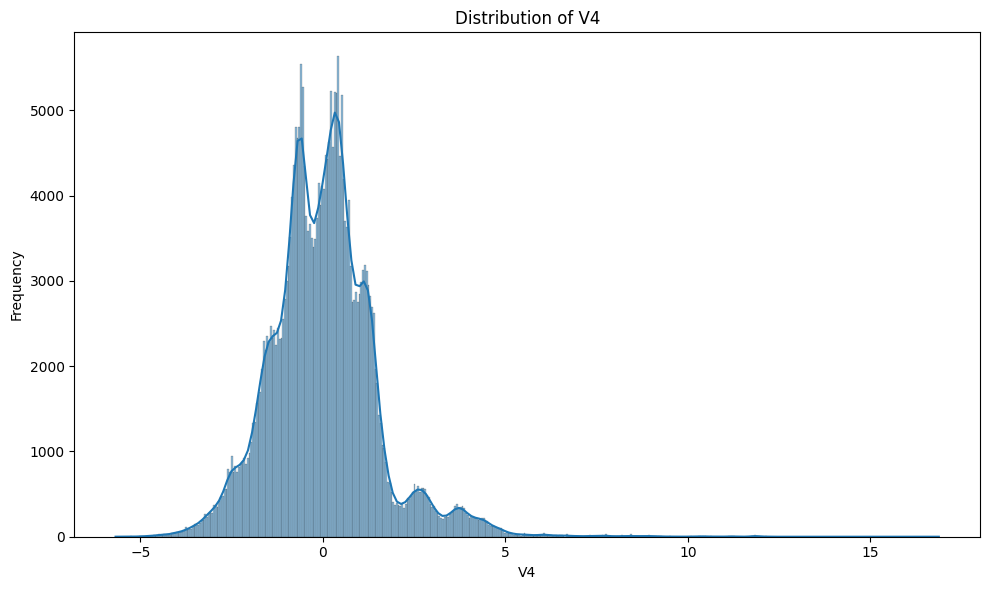

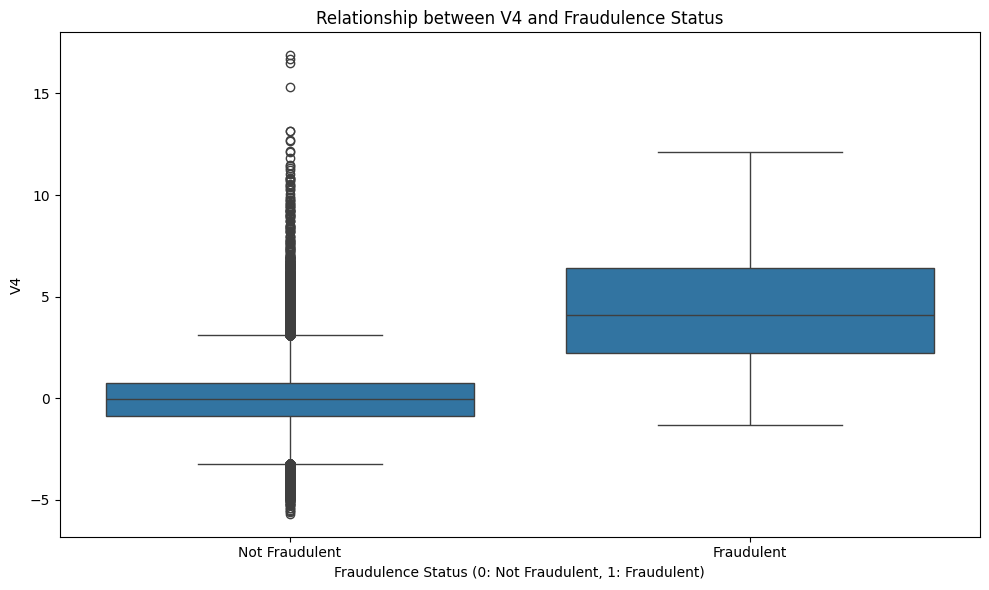


Analysis for column: V5

Descriptive statistics:


count    286315.000000
mean         -0.015496
std           1.440135
min        -113.743307
25%          -0.697608
50%          -0.057173
75%           0.610778
max          34.801666
Name: V5, dtype: float64

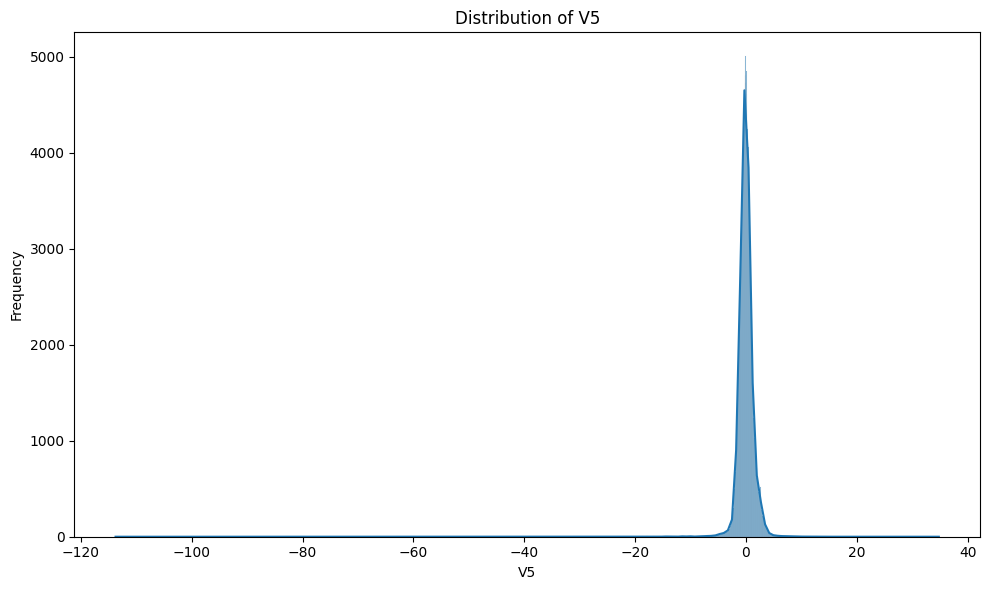

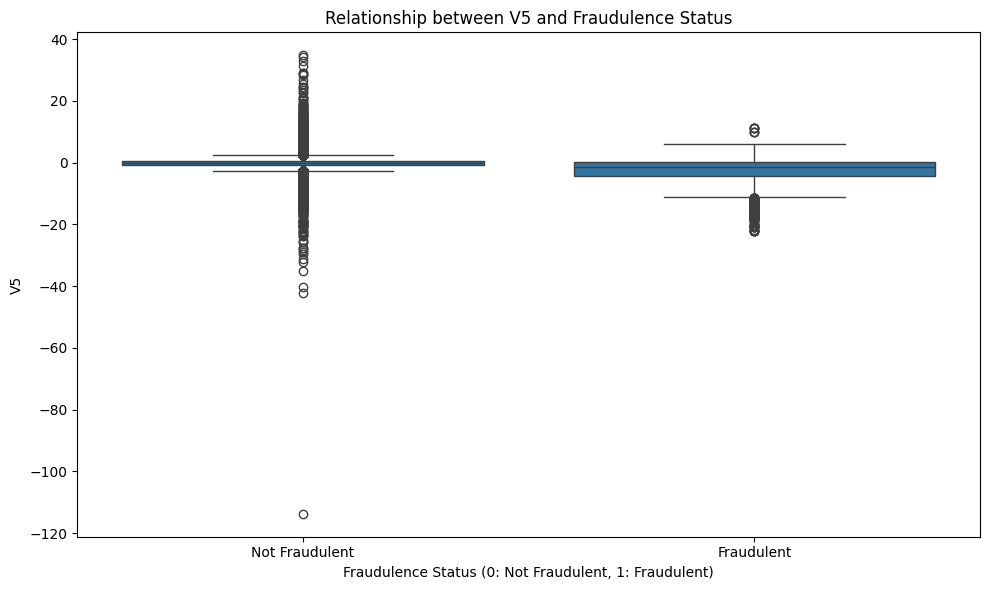


Analysis for column: V6

Descriptive statistics:


count    286315.000000
mean         -0.006939
std           1.338852
min         -26.160506
25%          -0.772949
50%          -0.277219
75%           0.395847
max          73.301626
Name: V6, dtype: float64

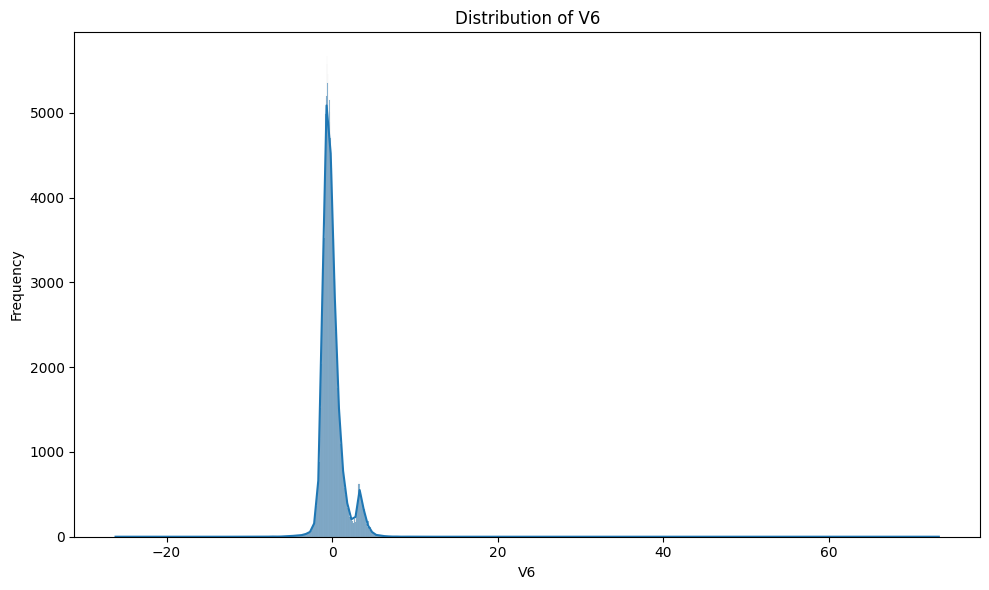

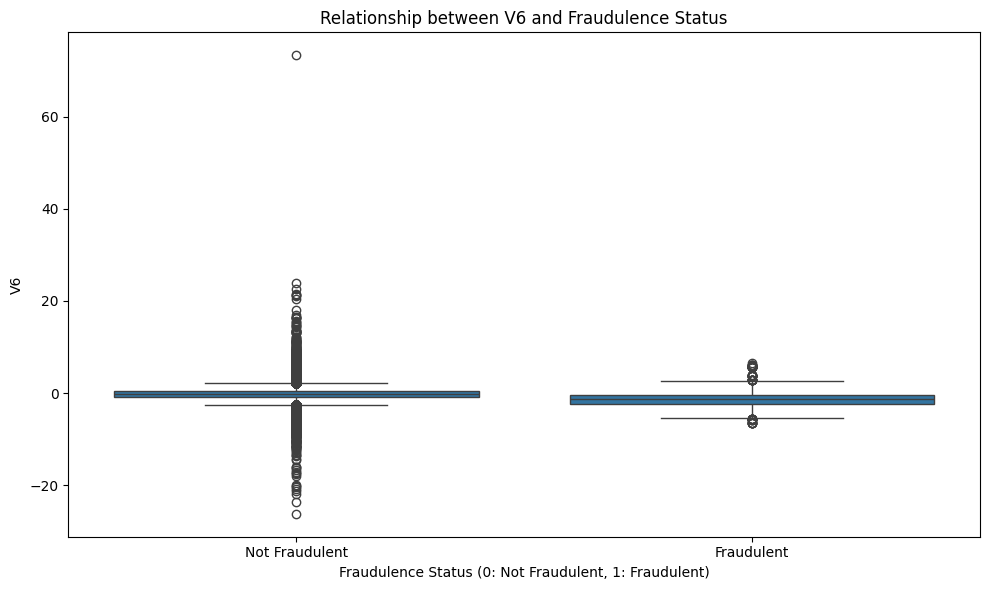


Analysis for column: V7

Descriptive statistics:


count    286315.000000
mean         -0.028154
std           1.383856
min         -43.557242
25%          -0.560981
50%           0.037005
75%           0.568421
max         120.589494
Name: V7, dtype: float64

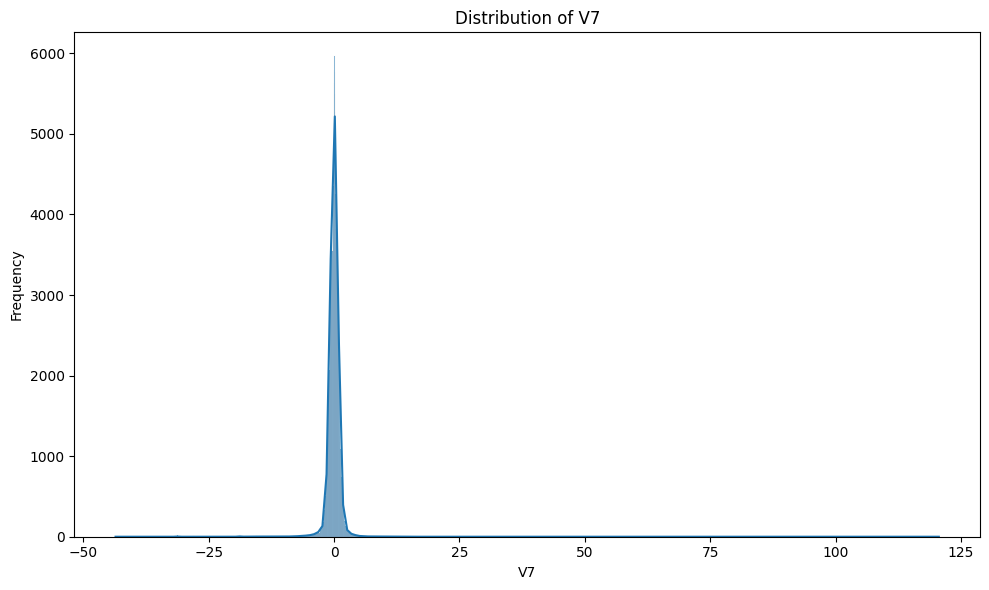

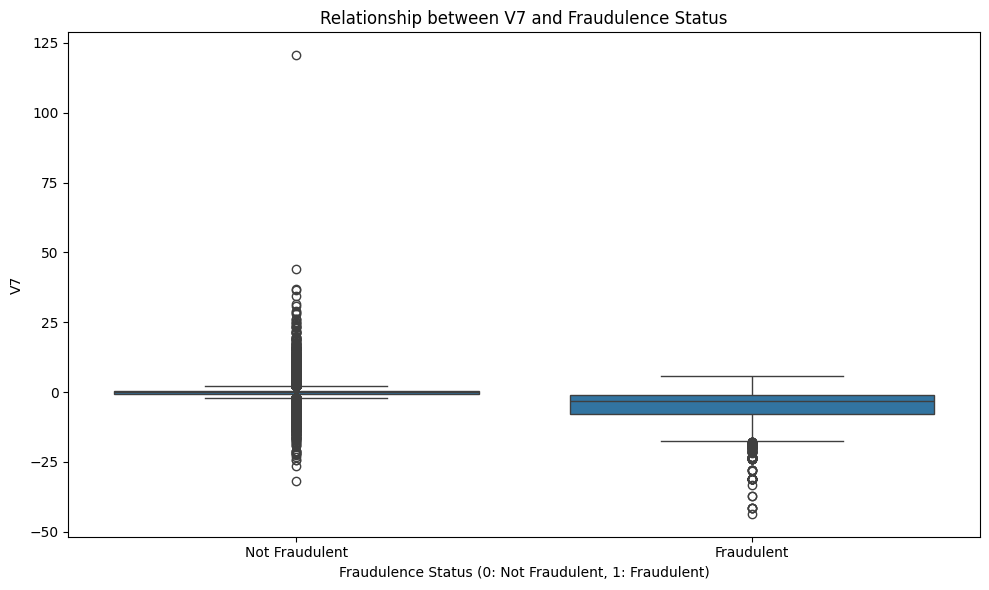


Analysis for column: V8

Descriptive statistics:


count    286315.000000
mean          0.001809
std           1.285448
min         -73.216718
25%          -0.208711
50%           0.023150
75%           0.330601
max          20.007208
Name: V8, dtype: float64

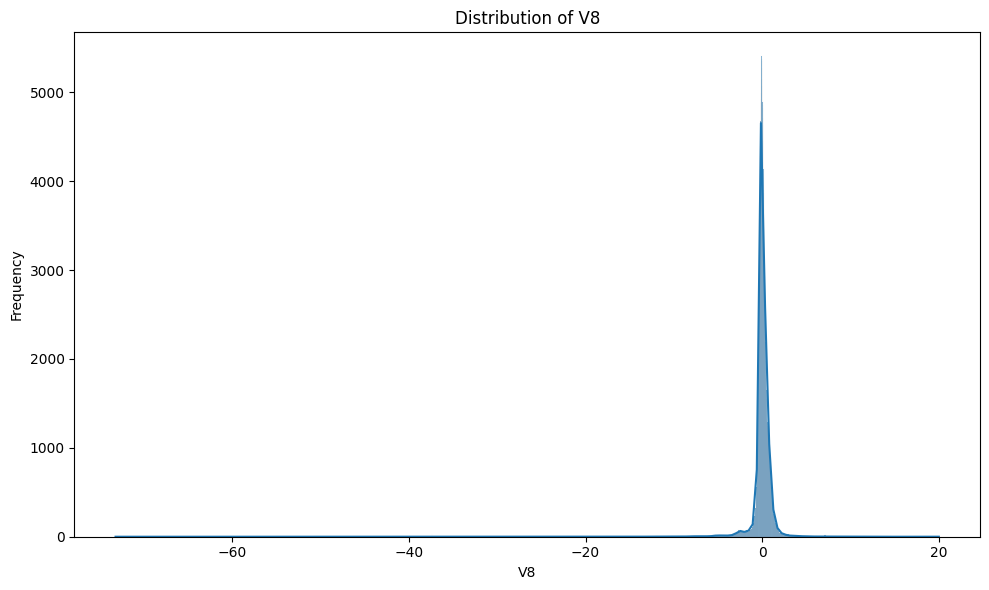

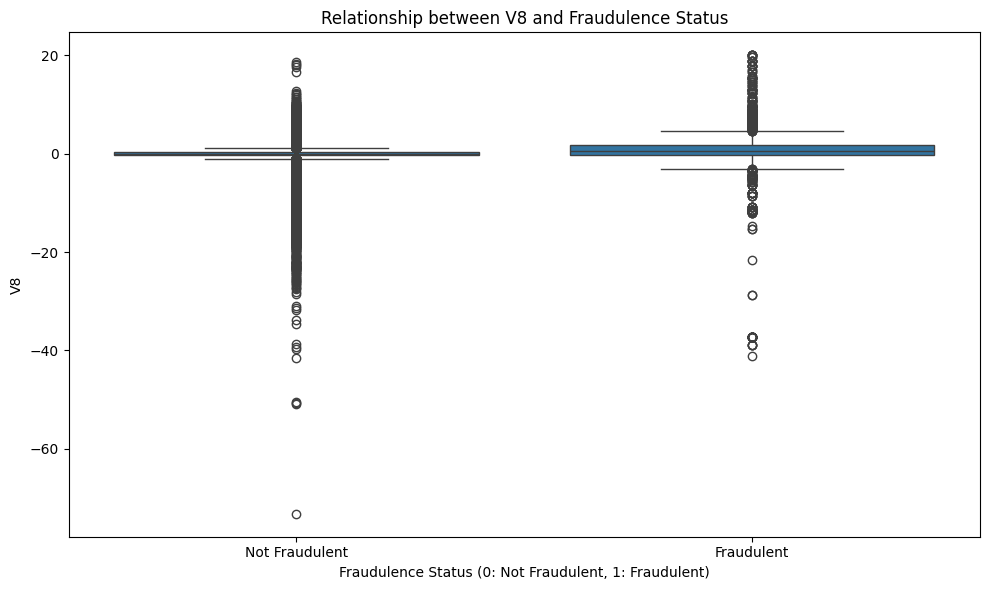


Analysis for column: V9

Descriptive statistics:


count    286315.000000
mean         -0.013087
std           1.124924
min         -13.434066
25%          -0.651328
50%          -0.054419
75%           0.594028
max          15.594995
Name: V9, dtype: float64

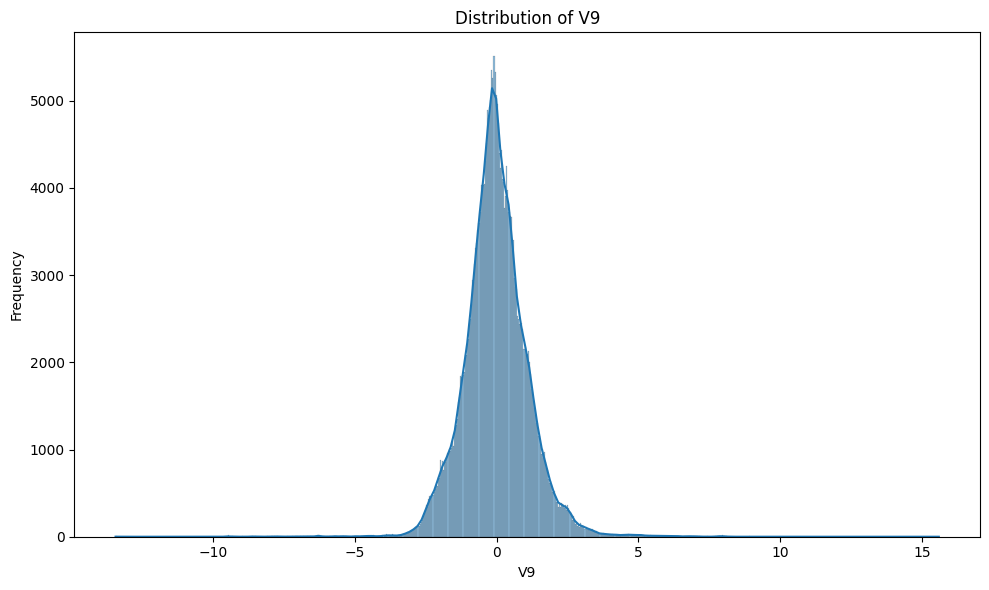

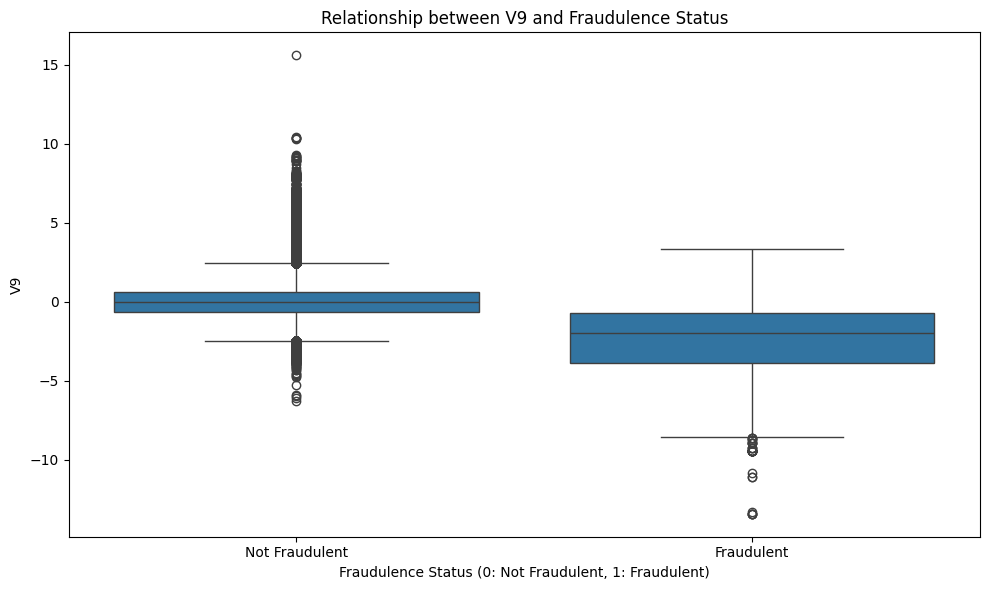


Analysis for column: V10

Descriptive statistics:


count    286315.000000
mean         -0.029173
std           1.209545
min         -24.588262
25%          -0.542040
50%          -0.096187
75%           0.449688
max          23.745136
Name: V10, dtype: float64

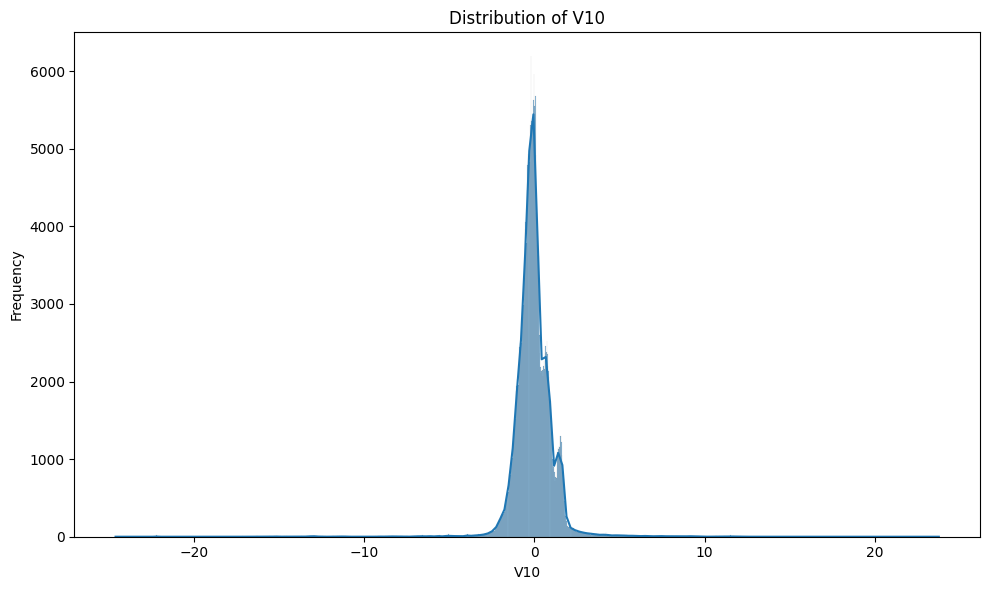

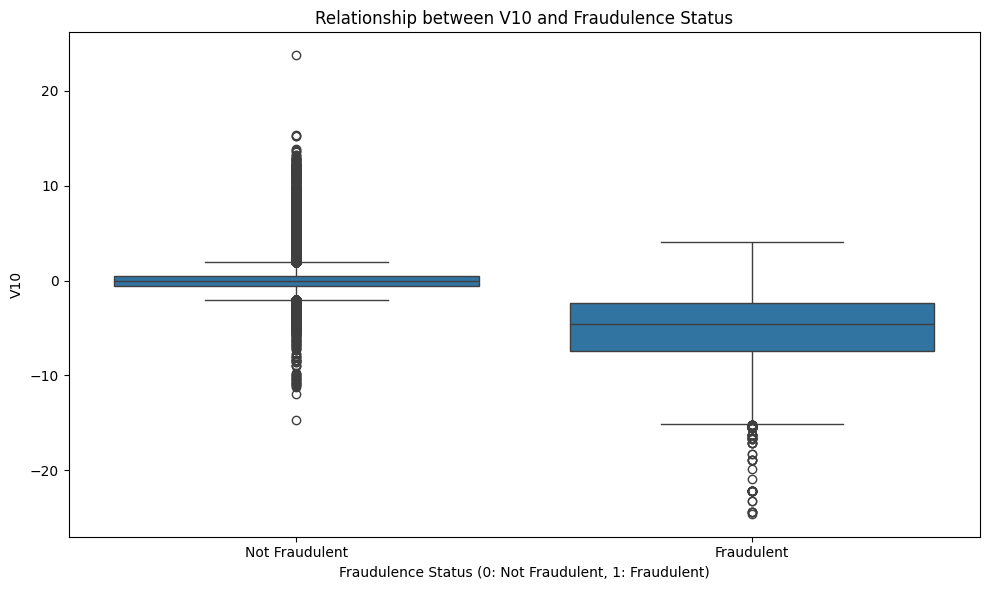


Analysis for column: V11

Descriptive statistics:


count    286315.000000
mean          0.020162
std           1.073409
min          -4.797473
25%          -0.759153
50%          -0.026350
75%           0.750812
max          12.018913
Name: V11, dtype: float64

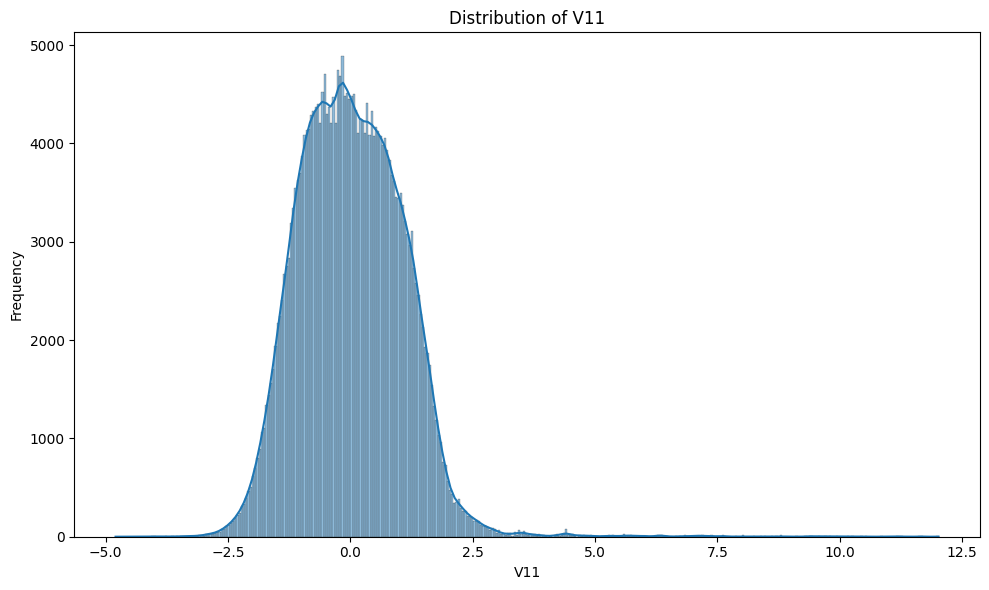

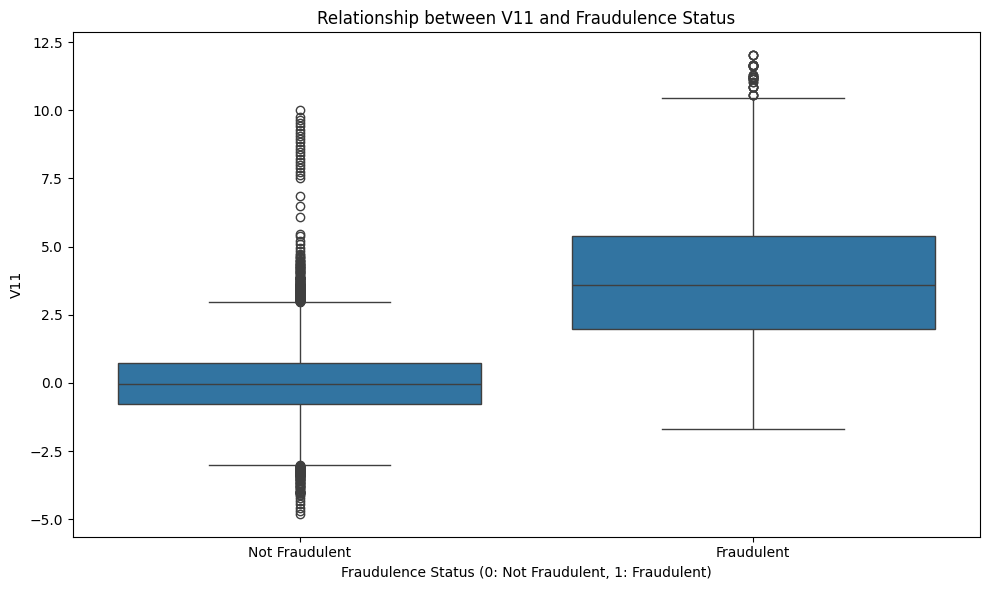


Analysis for column: V12

Descriptive statistics:


count    286315.000000
mean         -0.033073
std           1.147903
min         -18.683715
25%          -0.415203
50%           0.135297
75%           0.615625
max           7.848392
Name: V12, dtype: float64

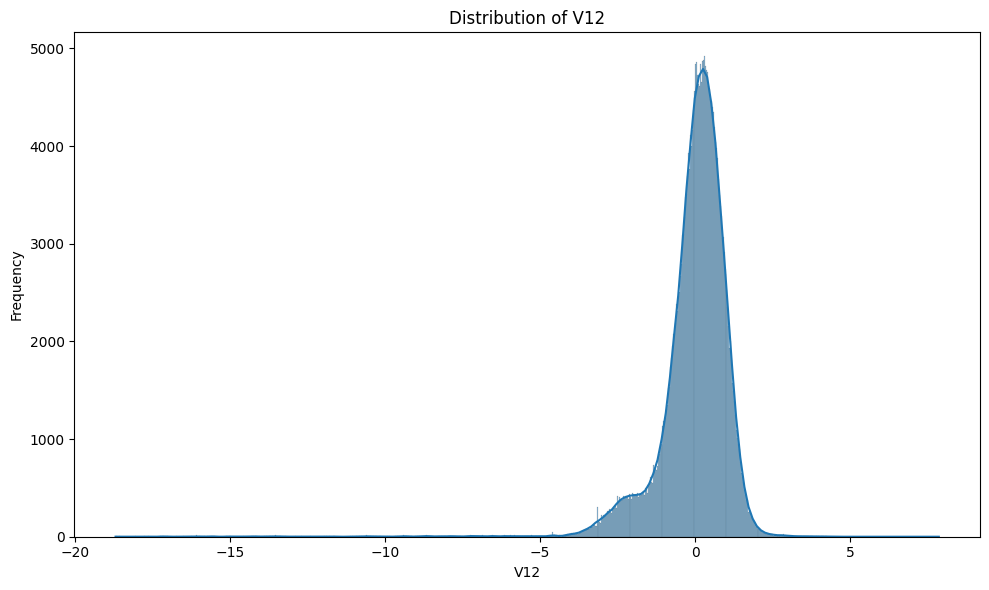

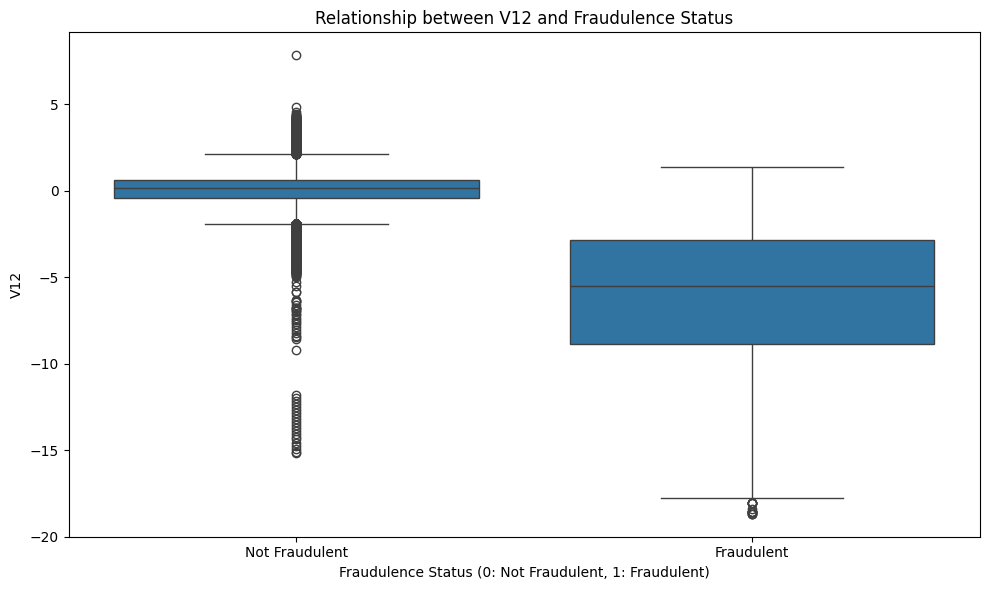


Analysis for column: V13

Descriptive statistics:


count    286315.000000
mean         -0.000300
std           0.996100
min          -5.791881
25%          -0.649853
50%          -0.013547
75%           0.663103
max           7.126883
Name: V13, dtype: float64

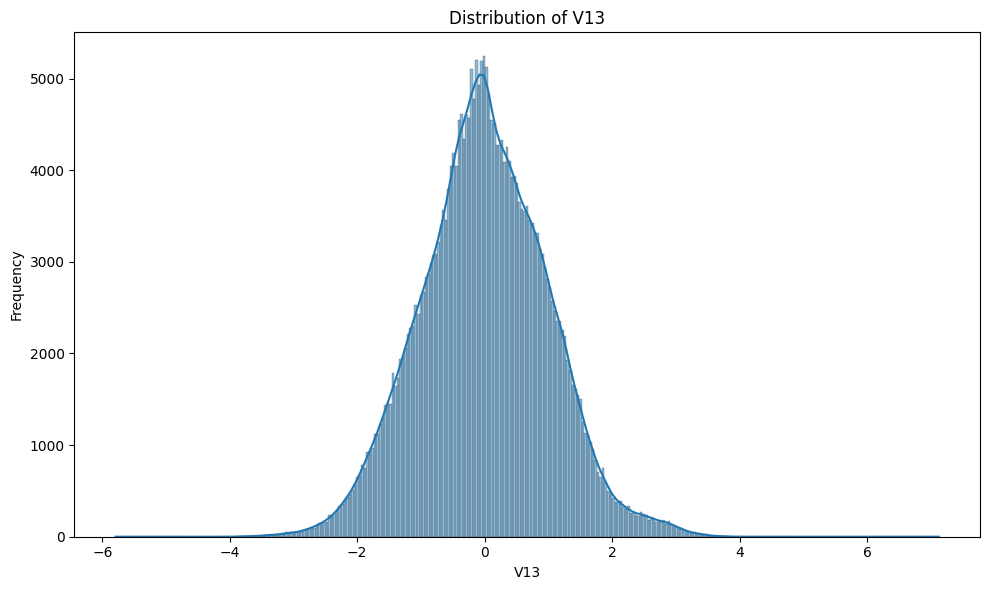

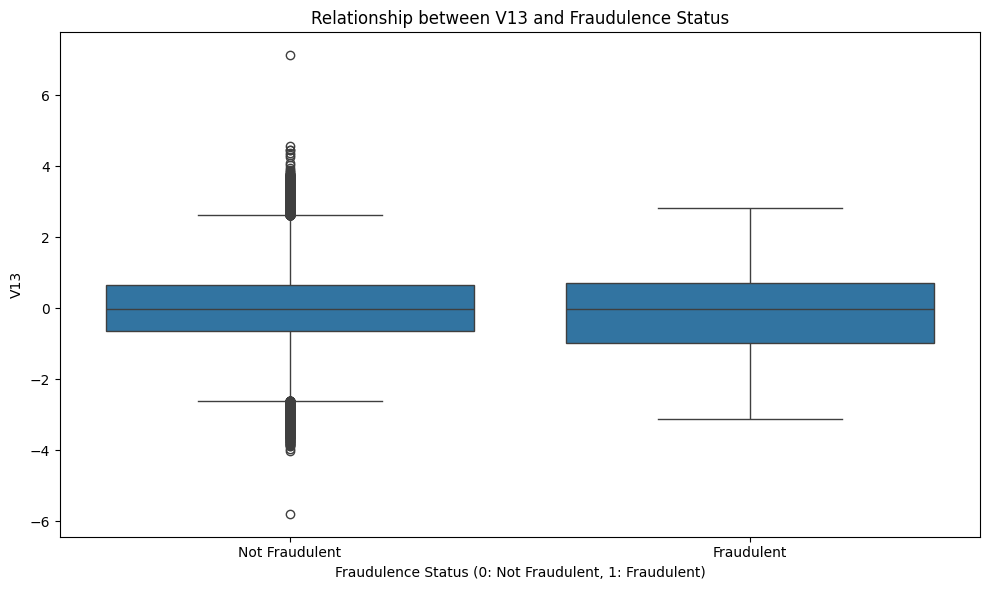


Analysis for column: V14

Descriptive statistics:


count    286315.000000
mean         -0.037293
std           1.130031
min         -19.214325
25%          -0.434084
50%           0.046862
75%           0.490590
max          10.526766
Name: V14, dtype: float64

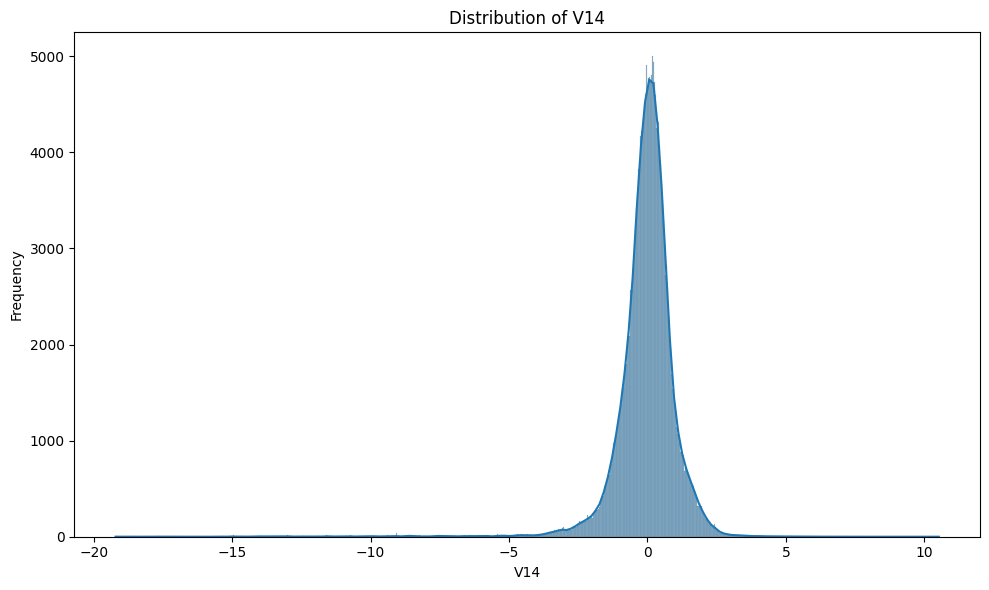

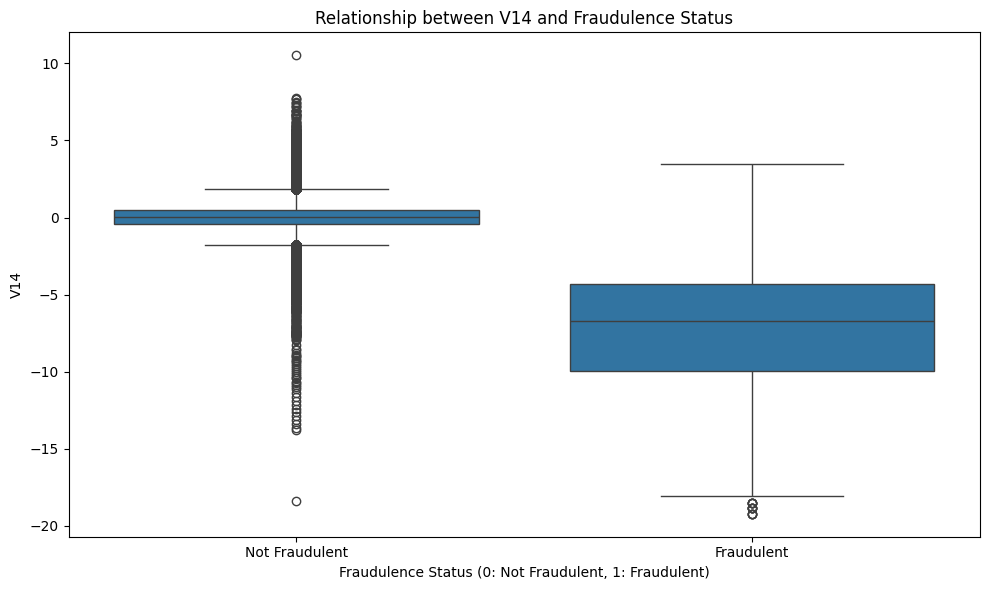


Analysis for column: V15

Descriptive statistics:


count    286315.000000
mean         -0.000430
std           0.915988
min          -4.498945
25%          -0.582884
50%           0.047537
75%           0.648497
max           8.877742
Name: V15, dtype: float64

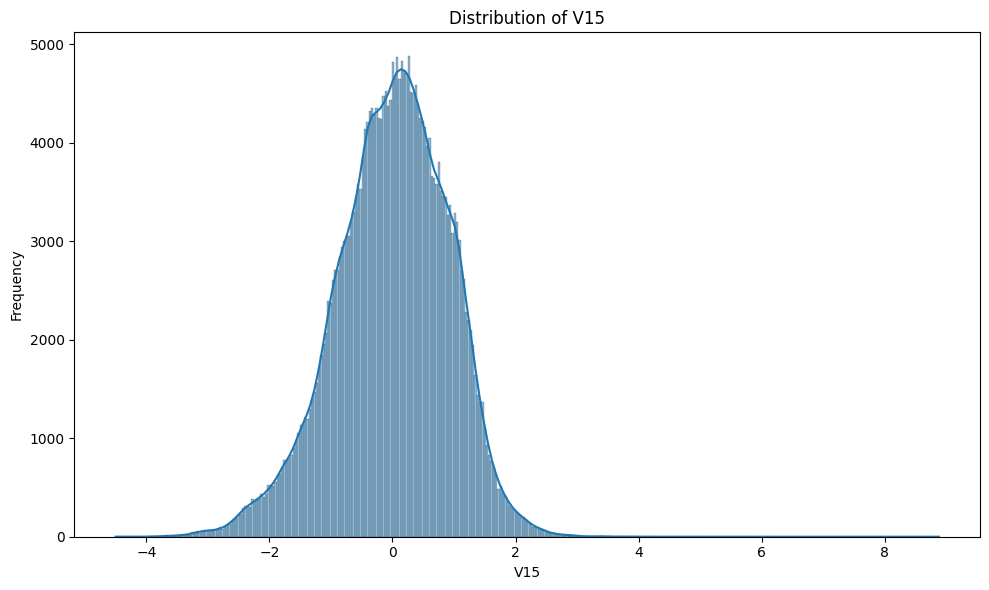

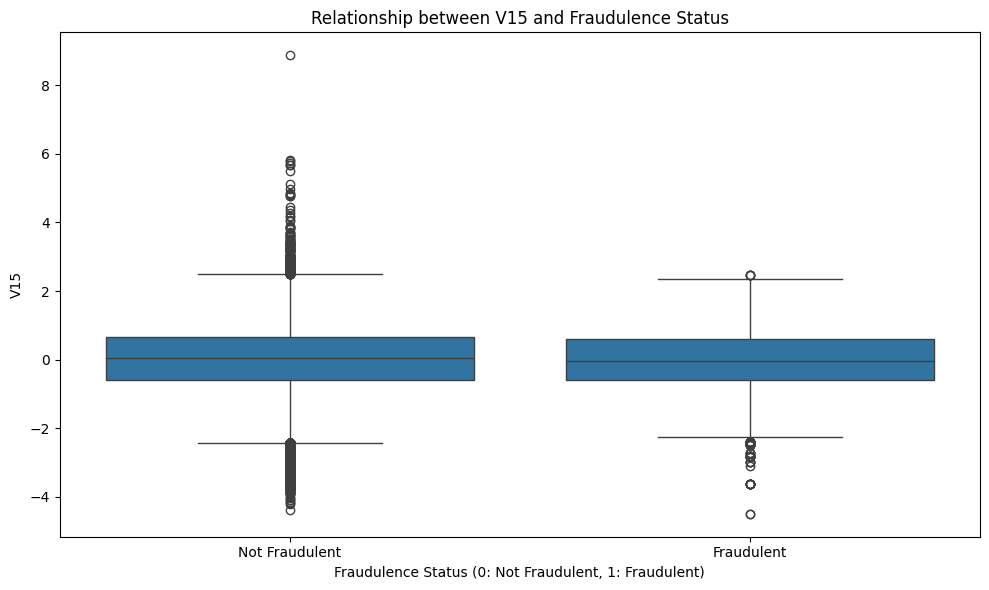


Analysis for column: V16

Descriptive statistics:


count    286315.000000
mean         -0.021966
std           0.967705
min         -14.129855
25%          -0.475833
50%           0.063201
75%           0.521604
max          17.315112
Name: V16, dtype: float64

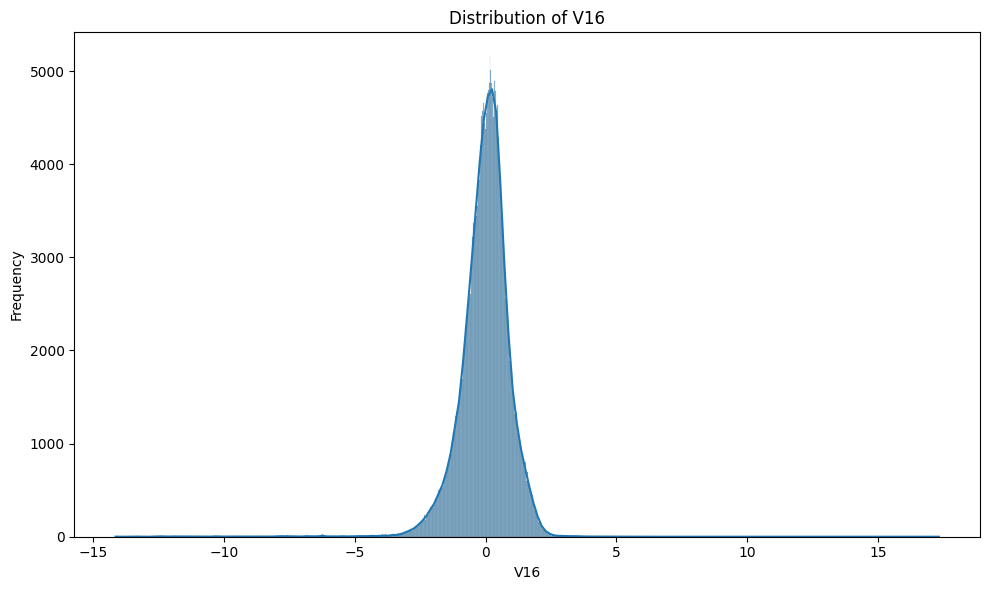

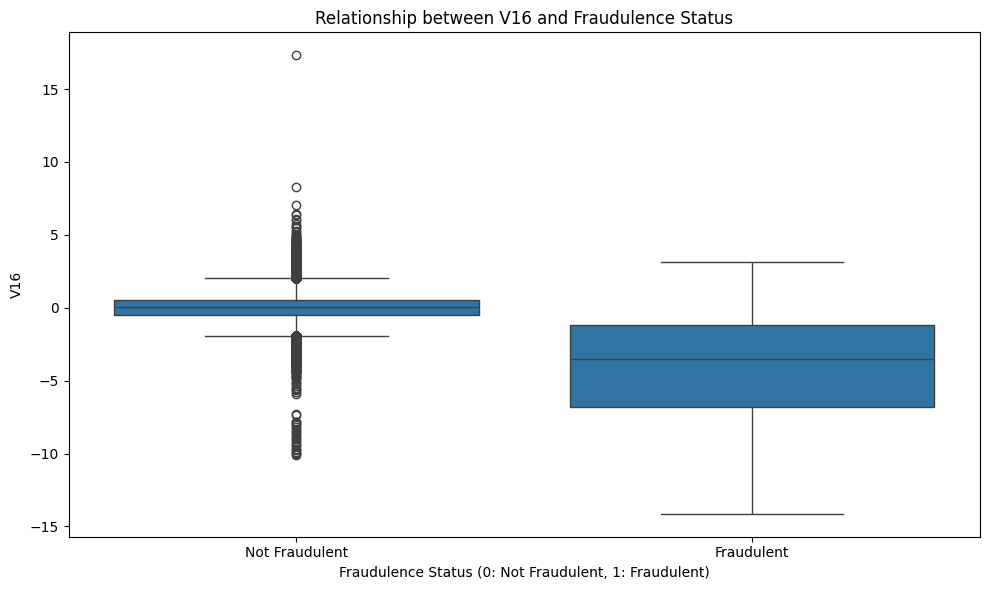


Analysis for column: V17

Descriptive statistics:


count    286315.000000
mean         -0.035151
std           1.100456
min         -25.162799
25%          -0.488649
50%          -0.068371
75%           0.398658
max           9.253526
Name: V17, dtype: float64

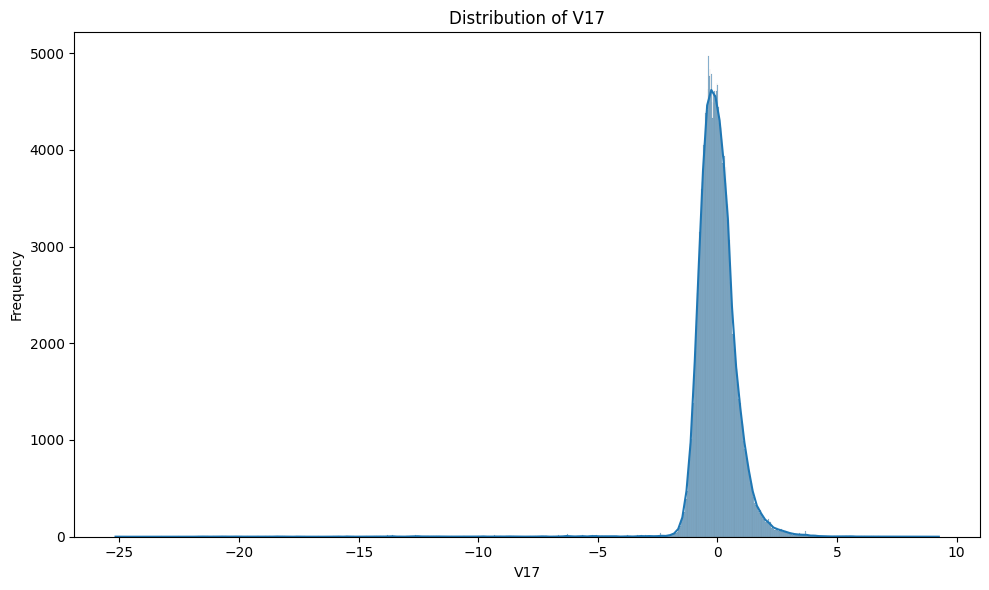

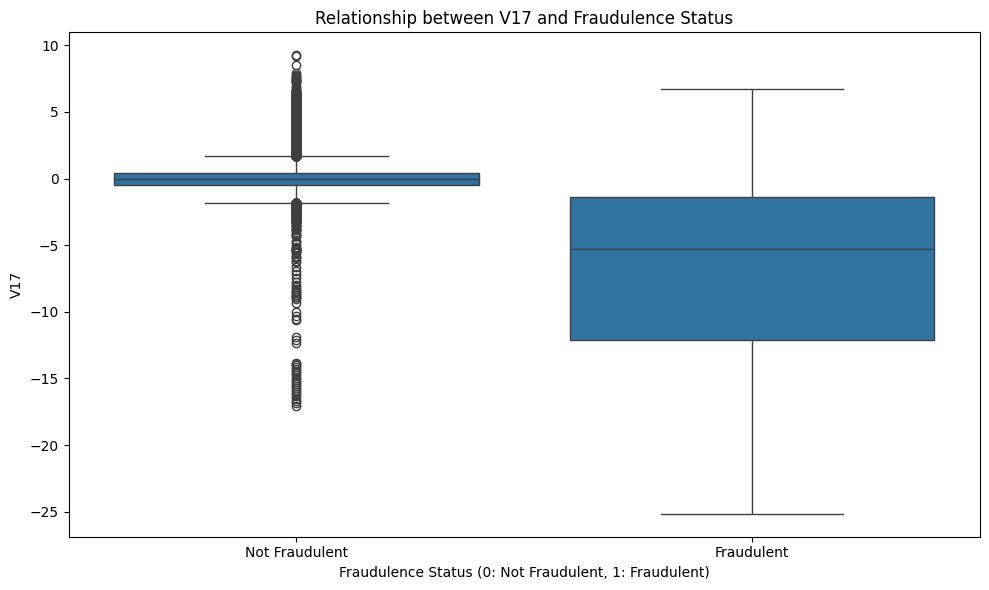


Analysis for column: V18

Descriptive statistics:


count    286315.000000
mean         -0.011777
std           0.877397
min          -9.498746
25%          -0.502948
50%          -0.006067
75%           0.499828
max           5.041069
Name: V18, dtype: float64

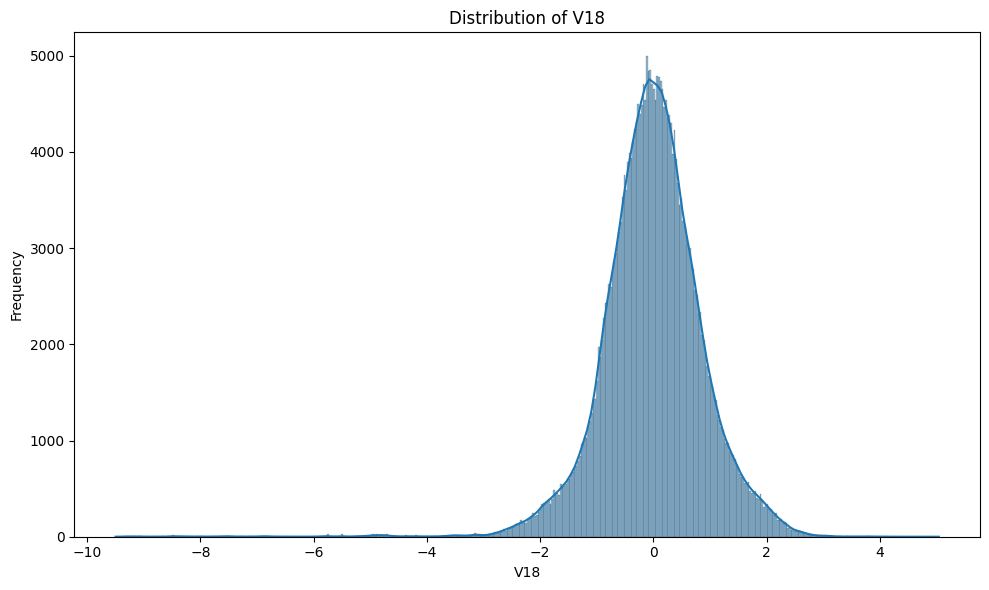

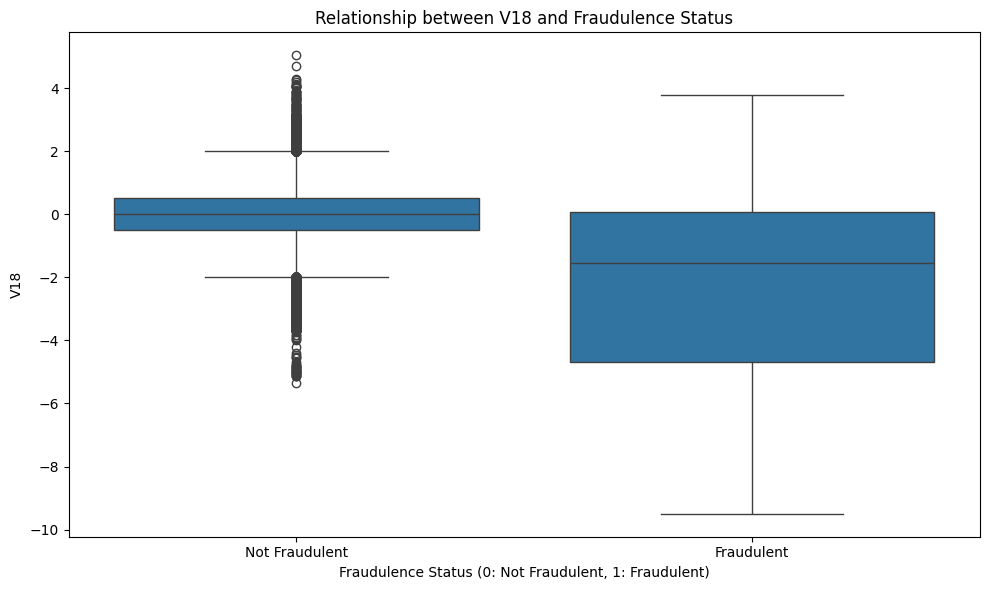


Analysis for column: V19

Descriptive statistics:


count    286315.000000
mean          0.003801
std           0.821054
min          -7.213527
25%          -0.455949
50%           0.005656
75%           0.462855
max           5.591971
Name: V19, dtype: float64

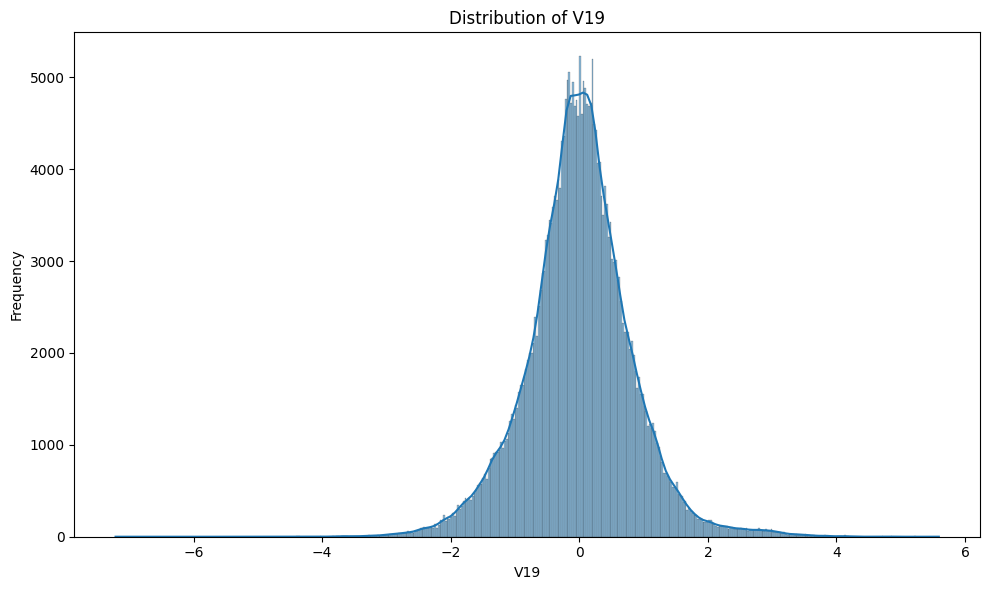

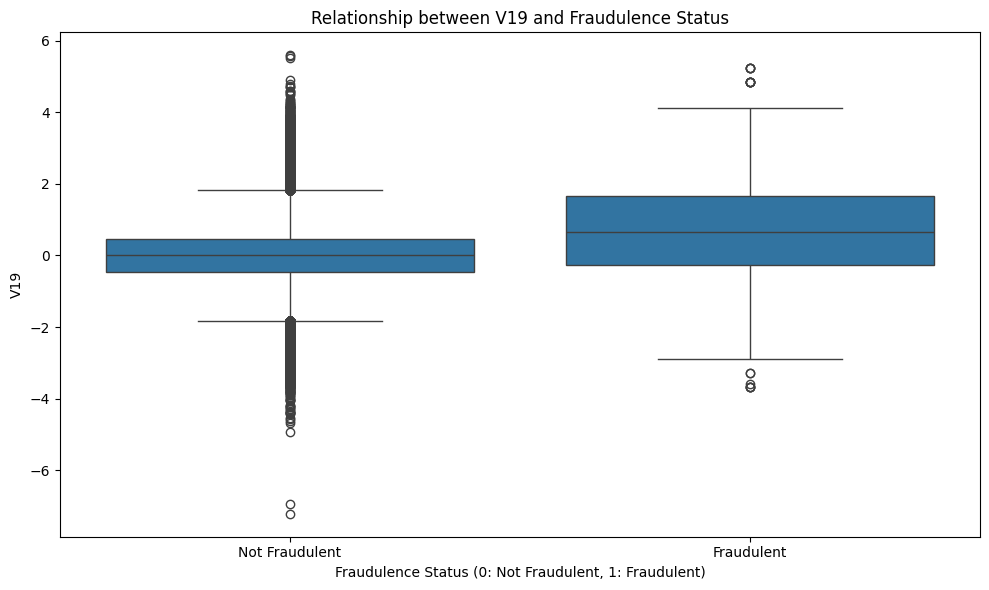


Analysis for column: V20

Descriptive statistics:


count    286315.000000
mean          0.001396
std           0.774501
min         -54.497720
25%          -0.211680
50%          -0.062040
75%           0.134791
max          39.420904
Name: V20, dtype: float64

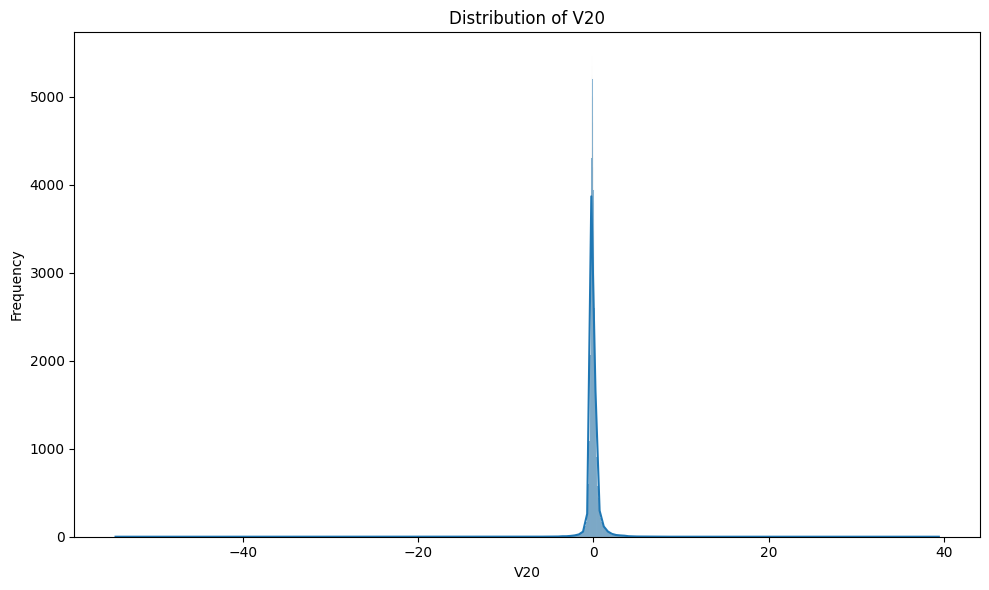

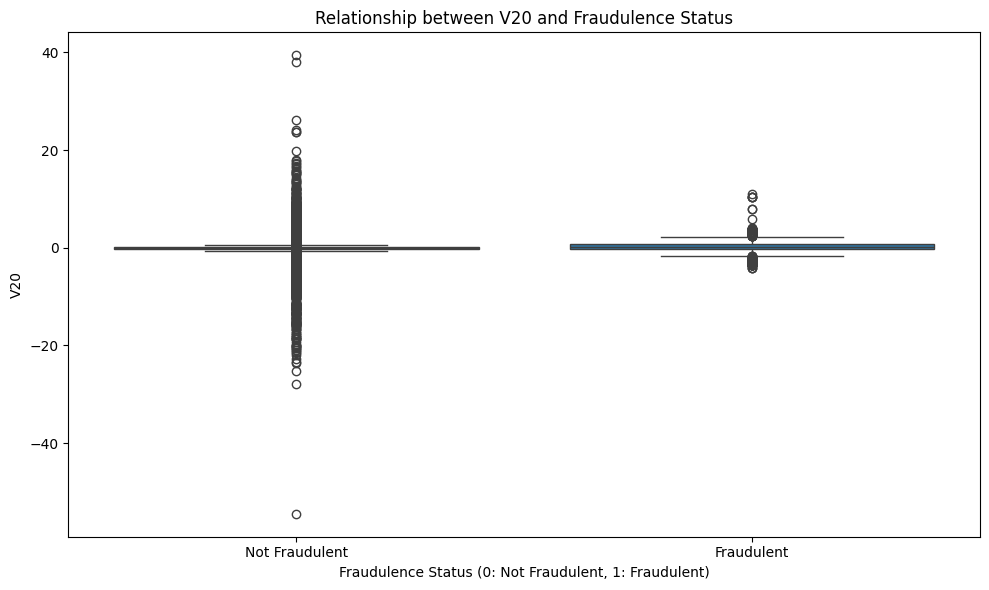


Analysis for column: V21

Descriptive statistics:


count    286315.000000
mean          0.005308
std           0.793311
min         -34.830382
25%          -0.228148
50%          -0.028469
75%           0.188609
max          27.202839
Name: V21, dtype: float64

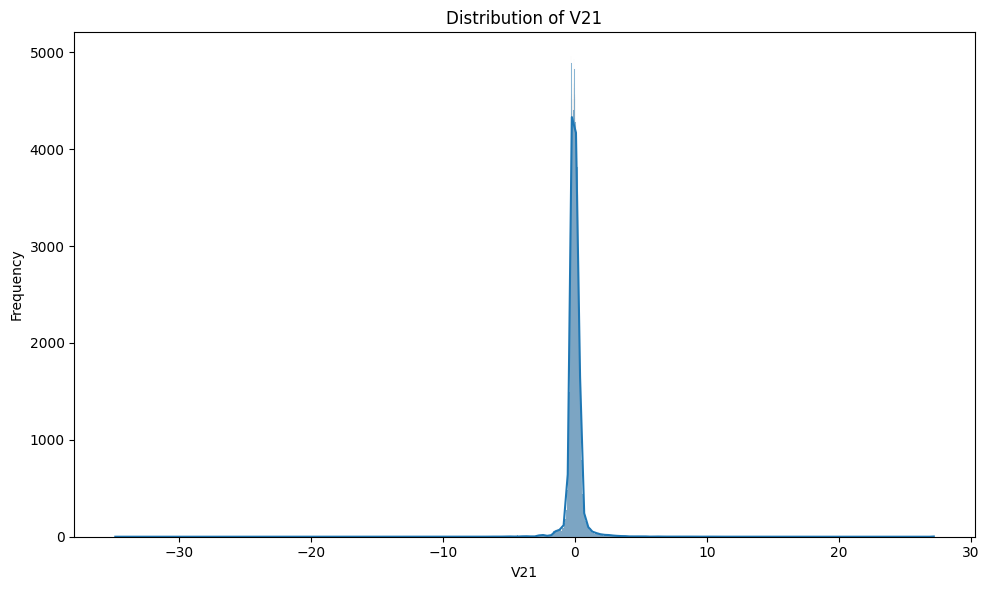

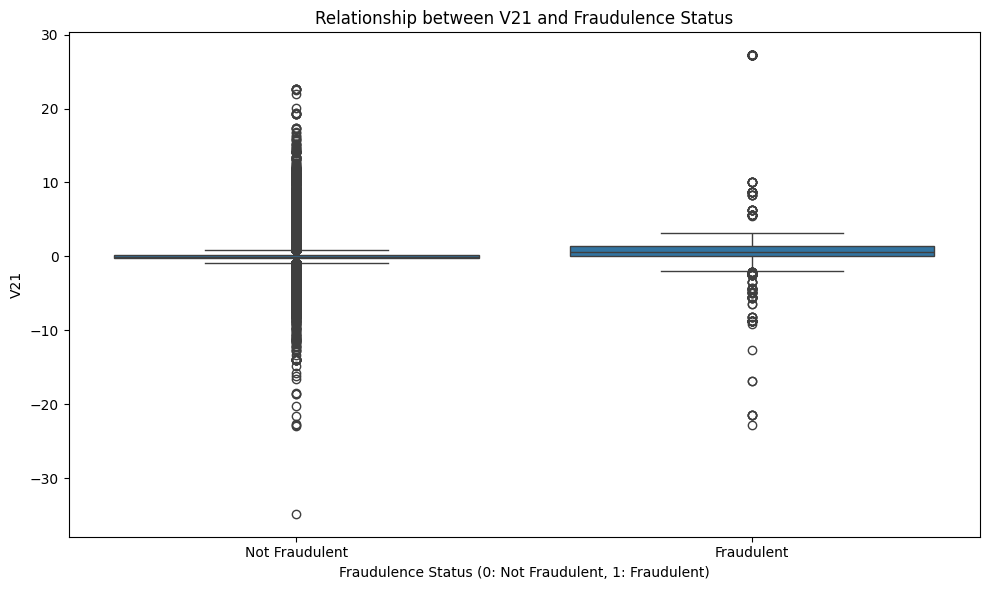


Analysis for column: V22

Descriptive statistics:


count    286315.000000
mean         -0.000239
std           0.732199
min         -10.933144
25%          -0.542344
50%           0.007077
75%           0.529161
max          10.503090
Name: V22, dtype: float64

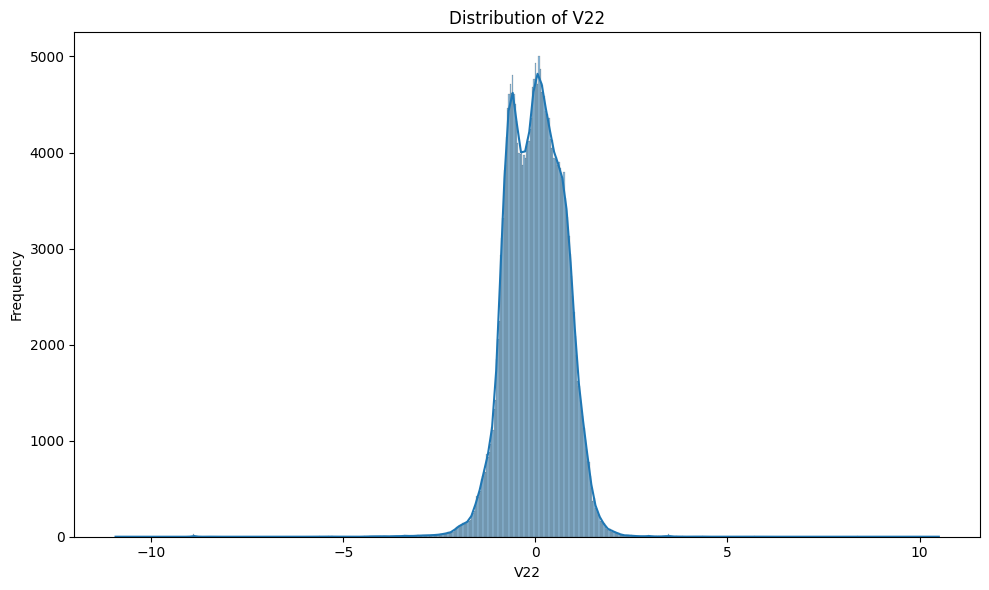

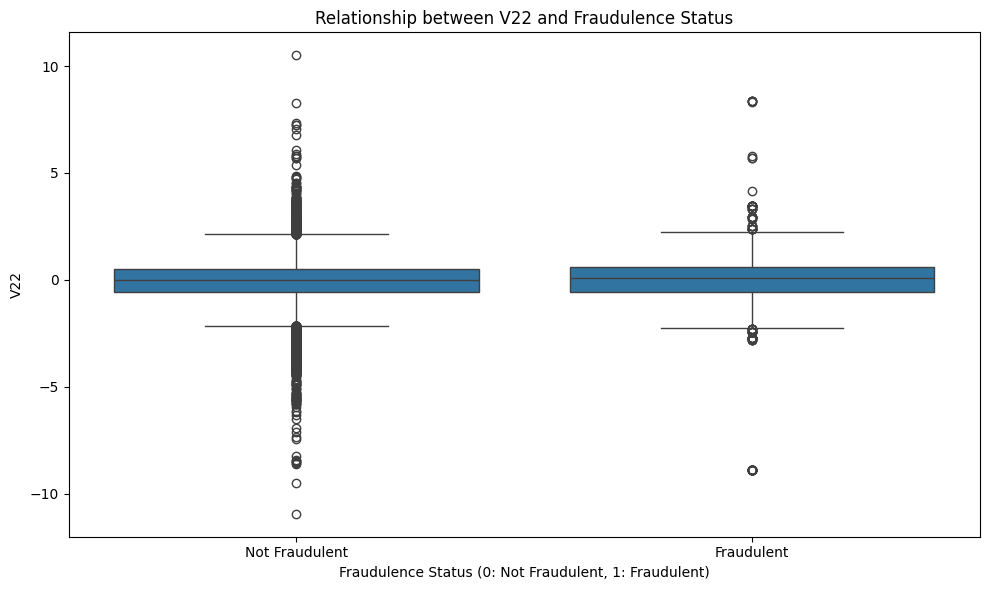


Analysis for column: V23

Descriptive statistics:


count    286315.000000
mean          0.000147
std           0.631161
min         -44.807735
25%          -0.162328
50%          -0.011301
75%           0.148145
max          22.528412
Name: V23, dtype: float64

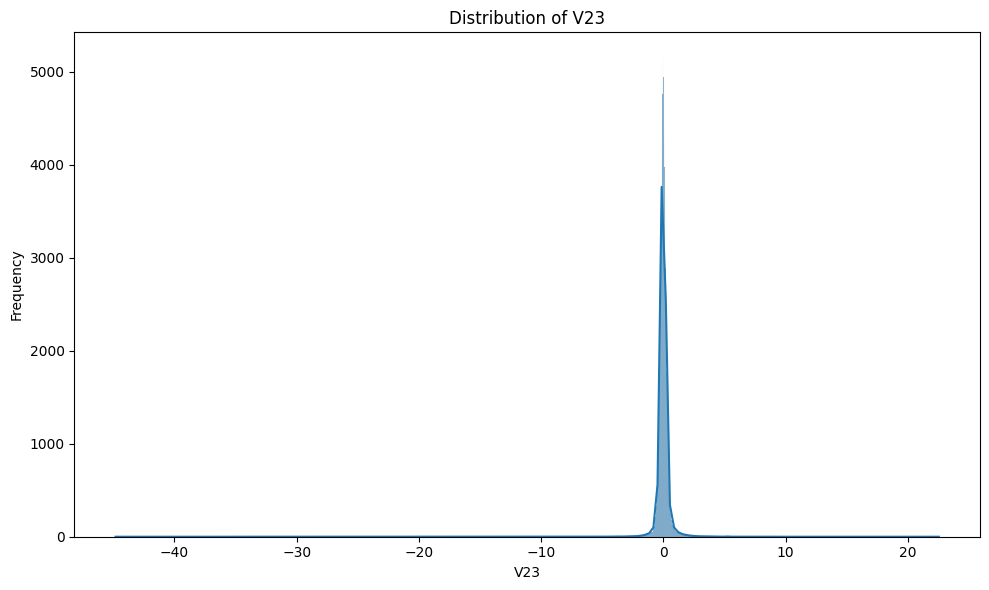

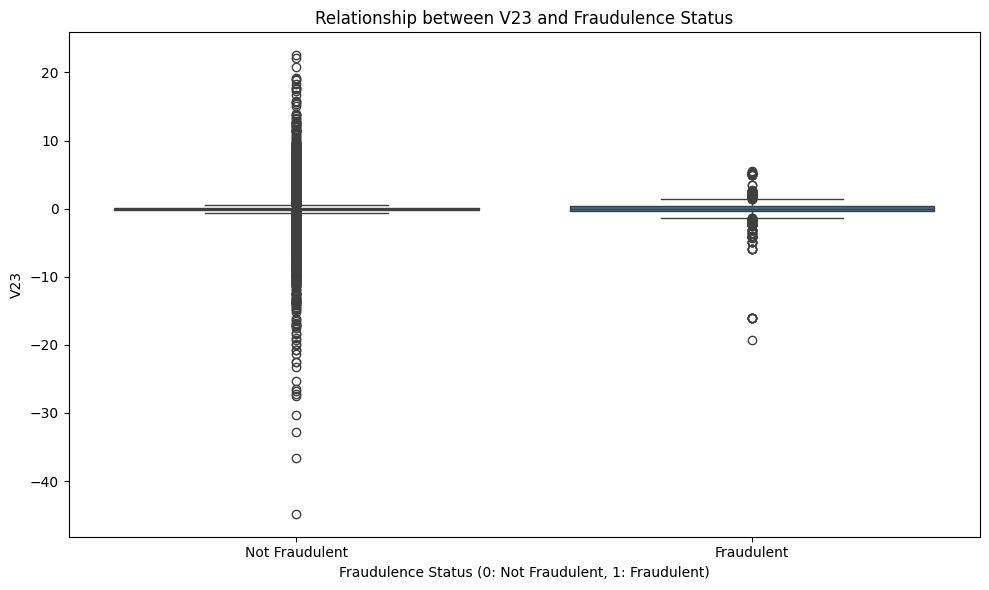


Analysis for column: V24

Descriptive statistics:


count    286315.000000
mean         -0.000671
std           0.605376
min          -2.836627
25%          -0.355409
50%           0.040631
75%           0.438711
max           4.584549
Name: V24, dtype: float64

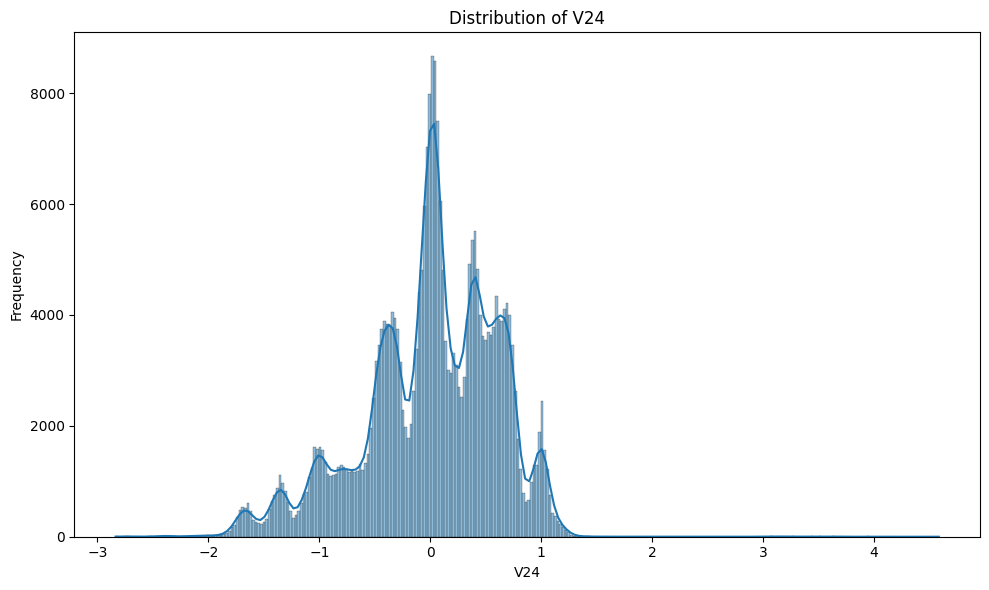

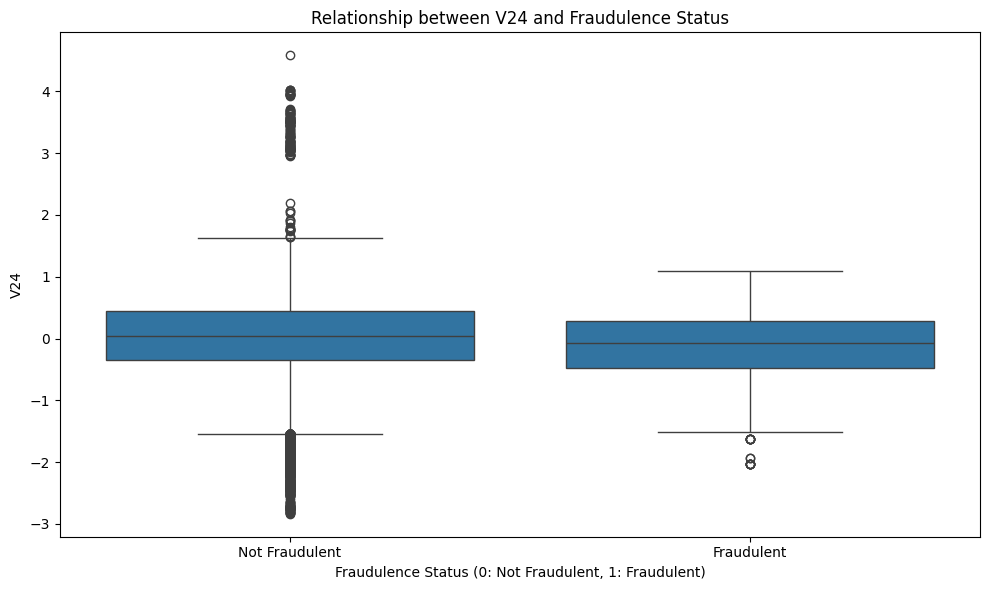


Analysis for column: V25

Descriptive statistics:


count    286315.000000
mean          0.000073
std           0.522728
min         -10.295397
25%          -0.317220
50%           0.016925
75%           0.351185
max           7.519589
Name: V25, dtype: float64

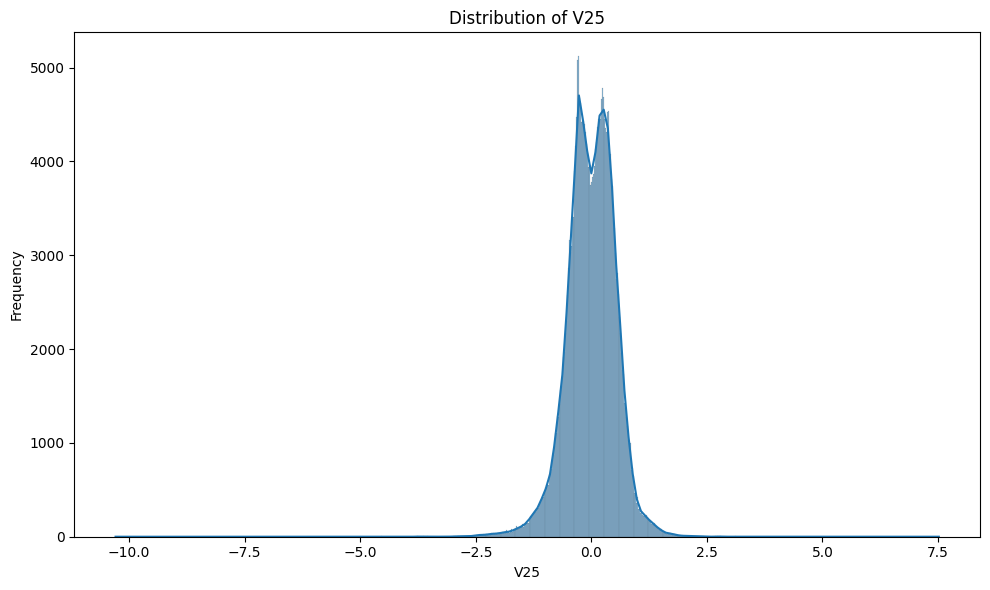

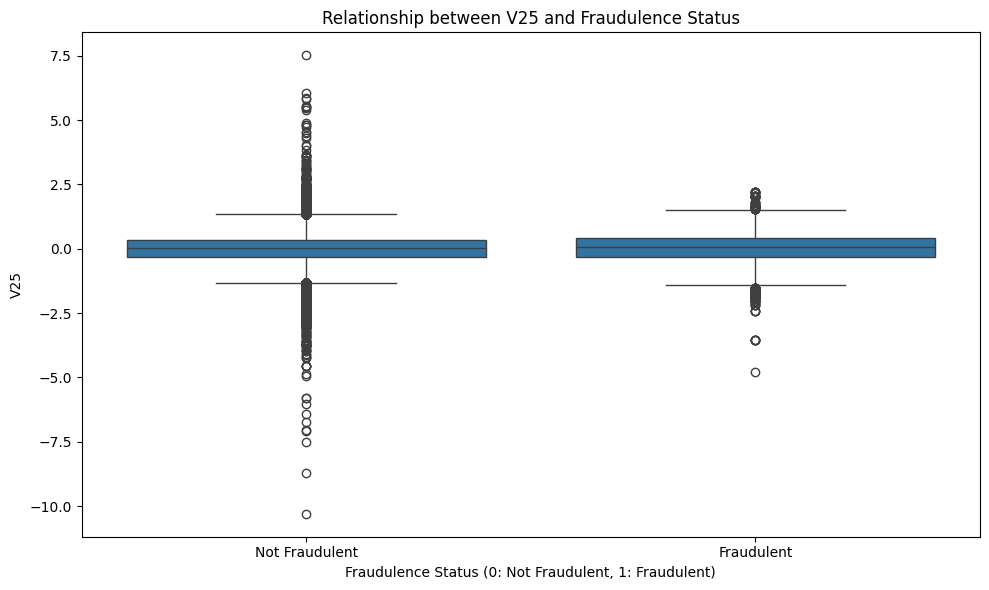


Analysis for column: V26

Descriptive statistics:


count    286315.000000
mean          0.000214
std           0.482259
min          -2.604551
25%          -0.326836
50%          -0.051817
75%           0.241833
max           3.517346
Name: V26, dtype: float64

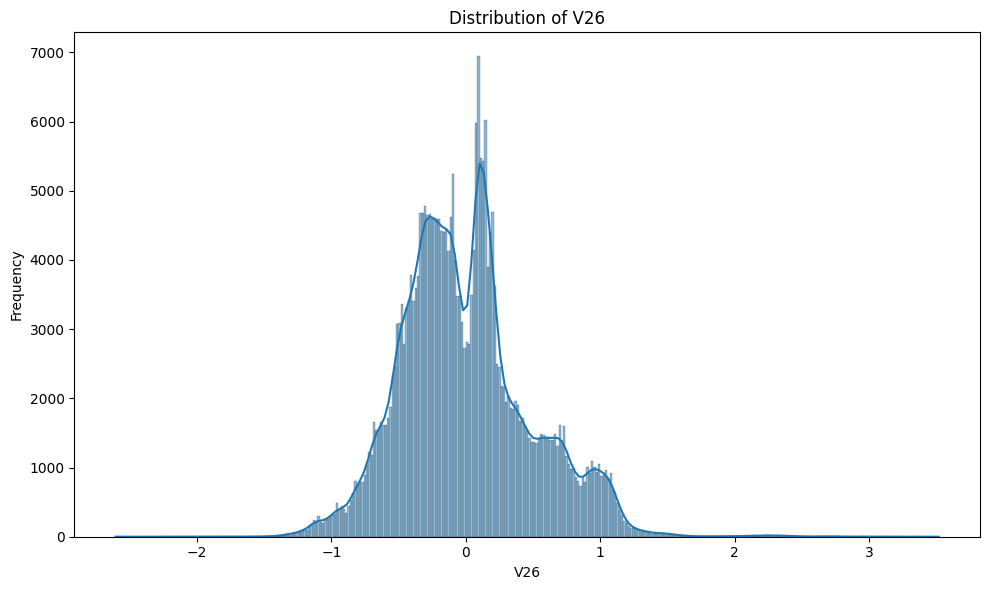

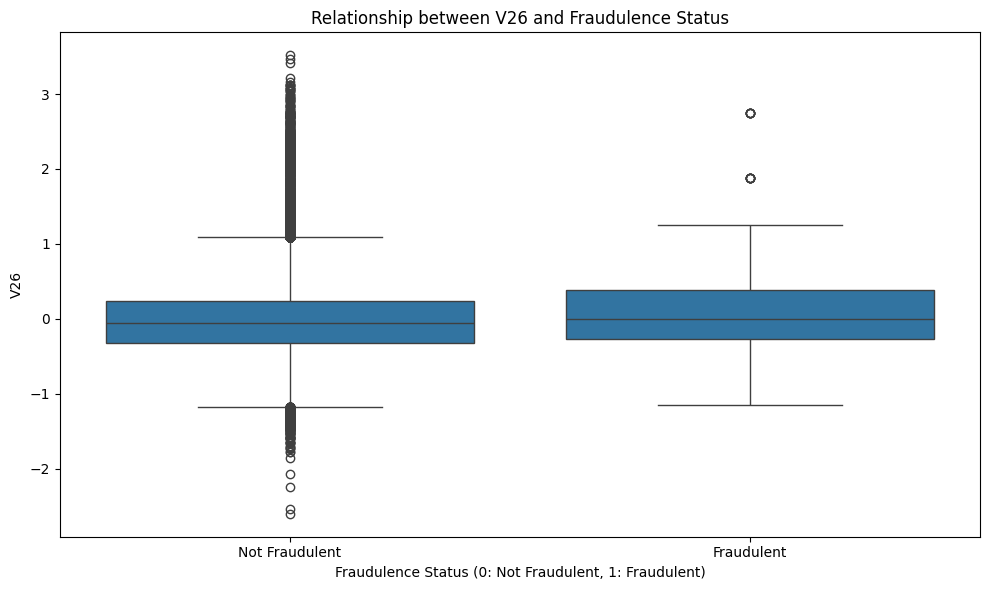


Analysis for column: V27

Descriptive statistics:


count    286315.000000
mean          0.000797
std           0.415420
min         -22.565679
25%          -0.070823
50%           0.001647
75%           0.092453
max          31.612198
Name: V27, dtype: float64

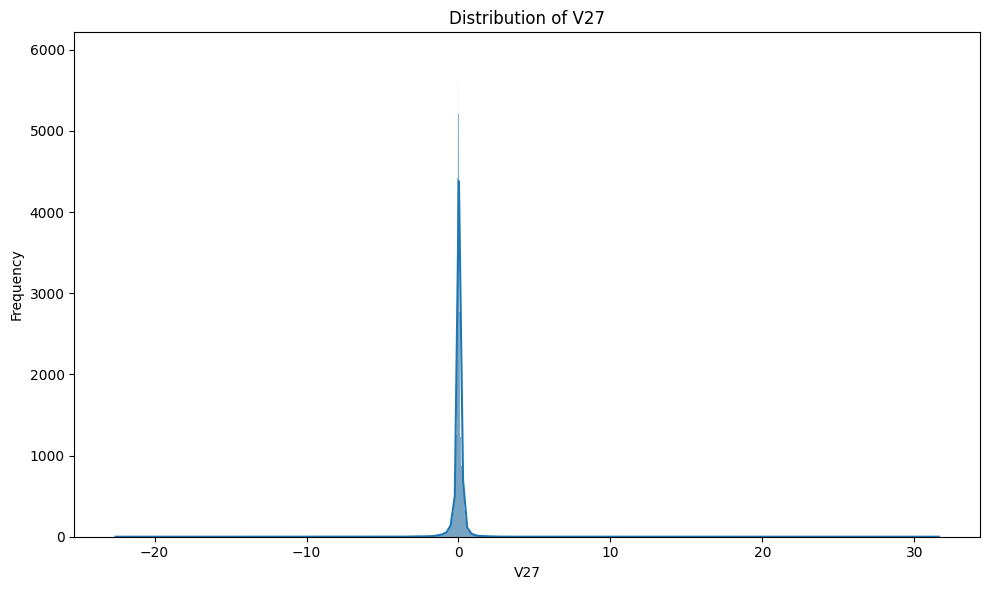

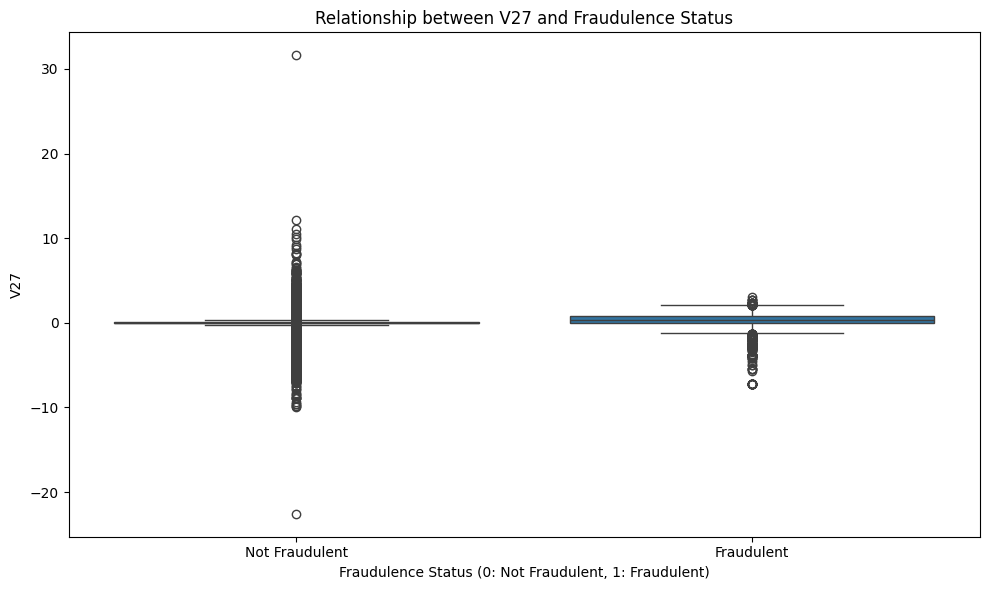


Analysis for column: V28

Descriptive statistics:


count    286315.000000
mean          0.000247
std           0.332052
min         -15.430084
25%          -0.053024
50%           0.011369
75%           0.079128
max          33.847808
Name: V28, dtype: float64

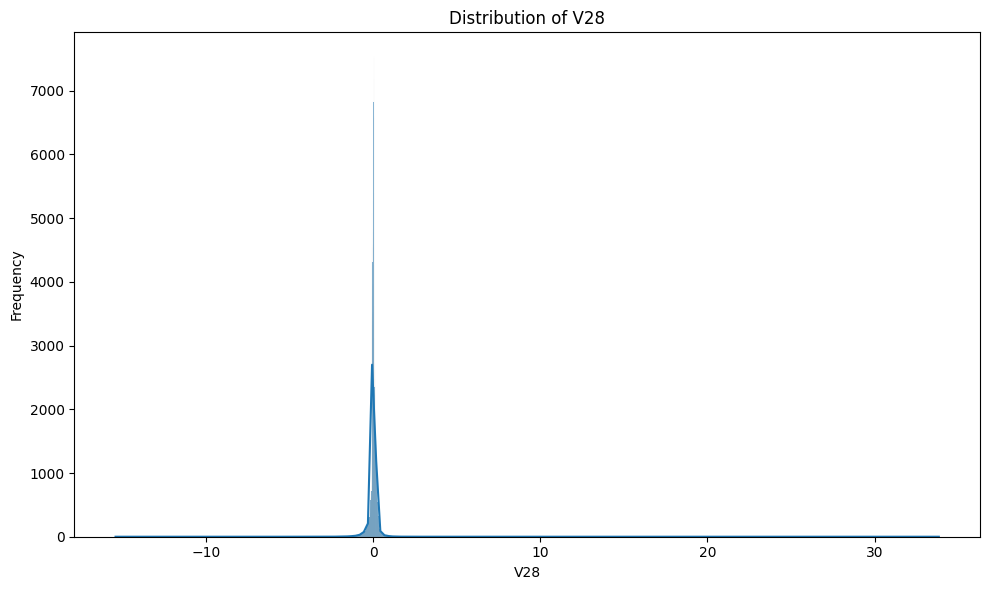

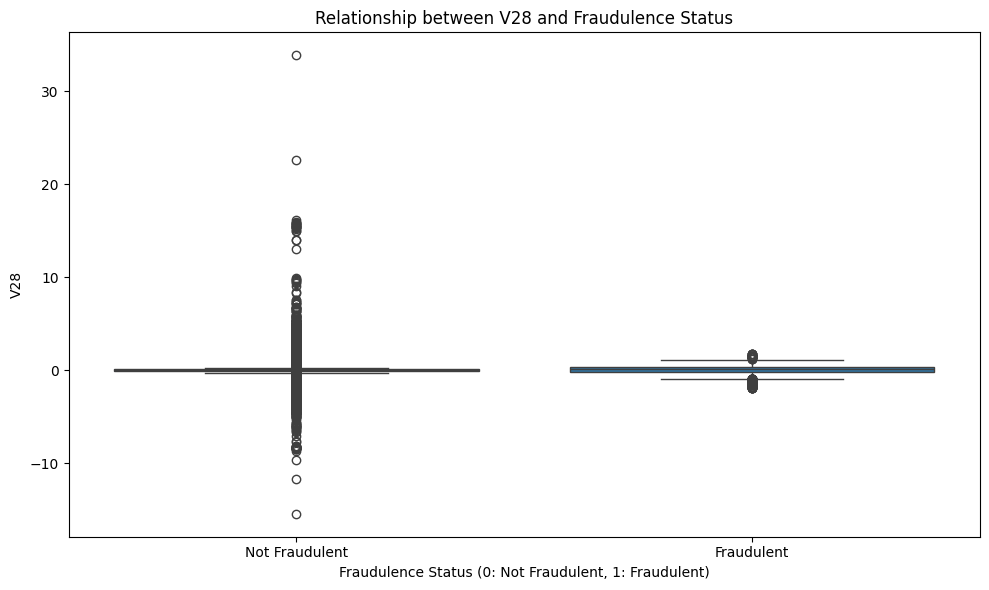


Analysis for column: Amount

Descriptive statistics:


count    286315.000000
mean         92.684657
std         368.354476
min           0.000000
25%           5.490000
50%          22.000000
75%          77.695000
max       25691.160000
Name: Amount, dtype: float64

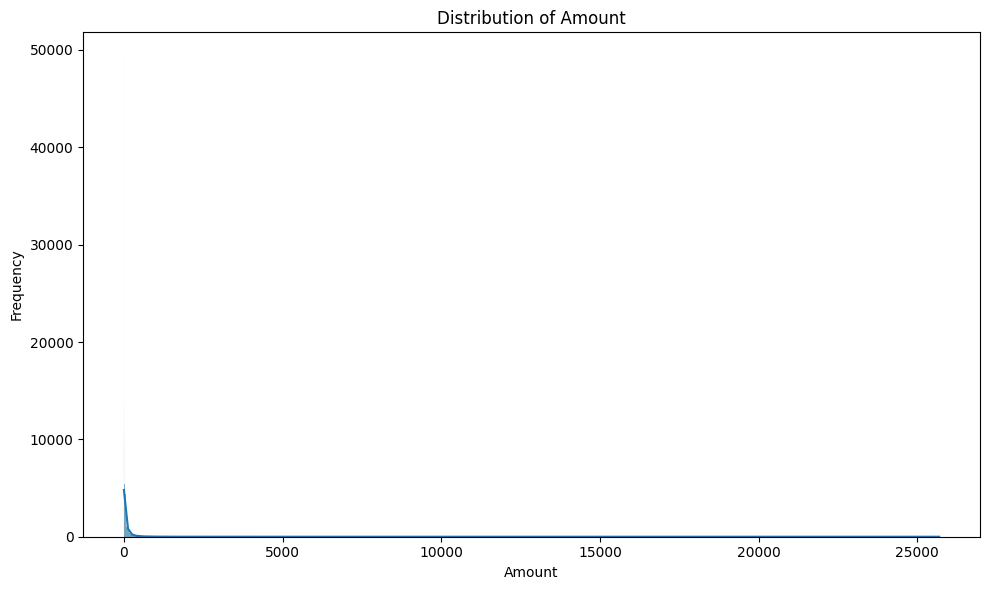

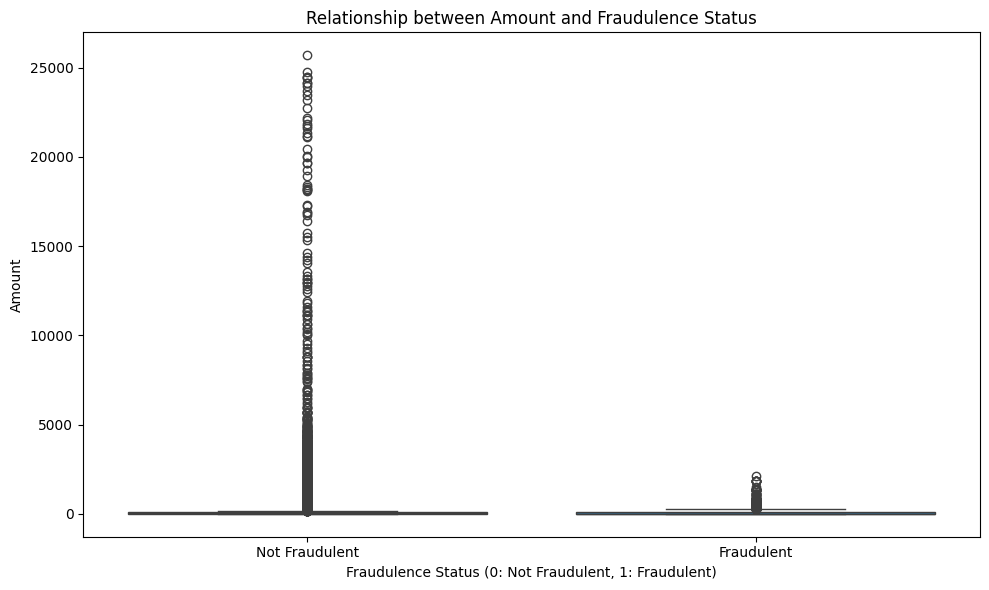


Analysis for column: hour

Descriptive statistics:


count    286315.000000
mean         14.032859
std           5.843513
min           0.000000
25%          10.000000
50%          15.000000
75%          19.000000
max          23.000000
Name: hour, dtype: float64

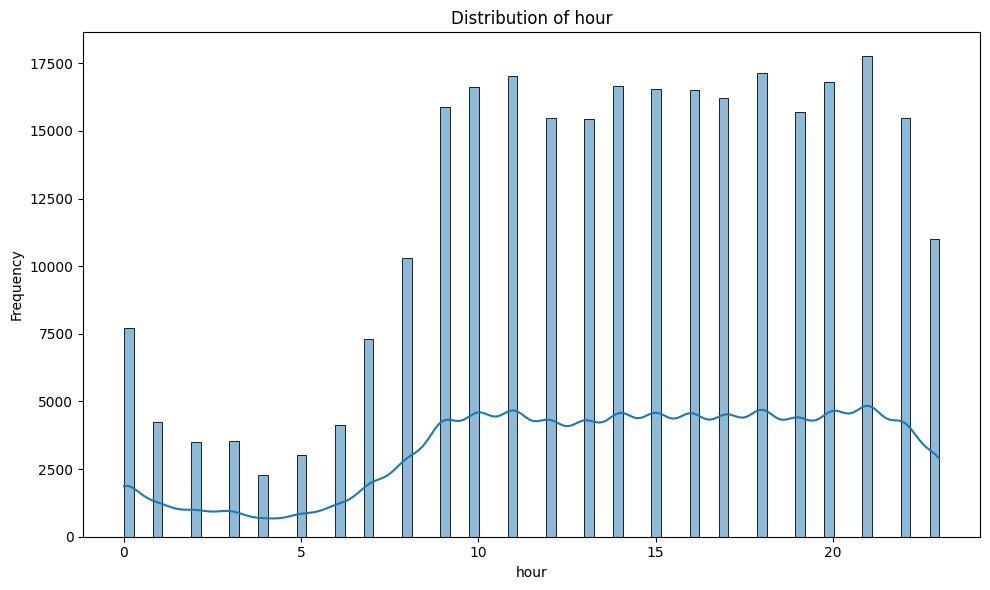

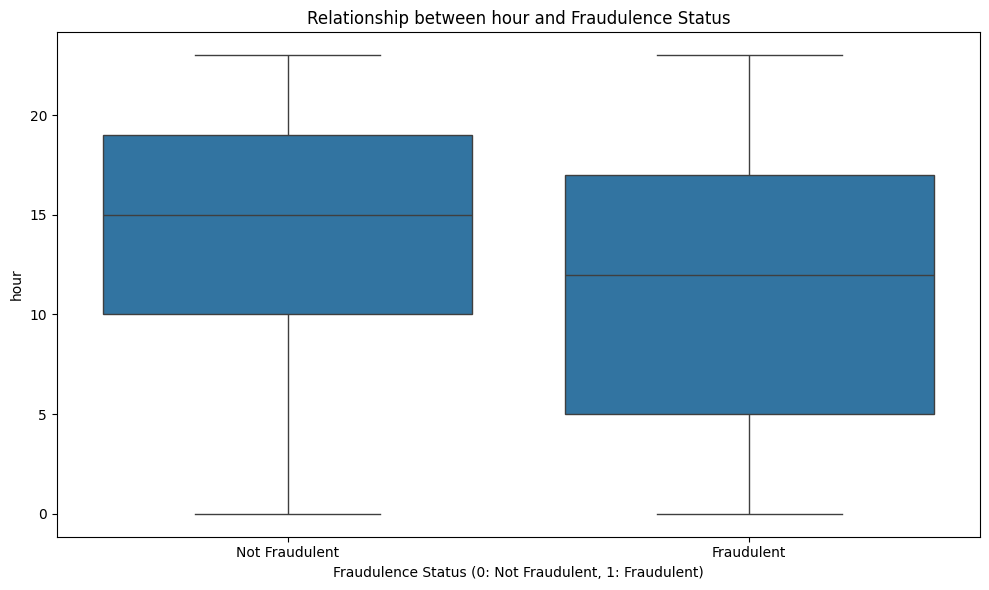


Analysis for column: age

Descriptive statistics:


count    286068.000000
mean         49.844261
std          18.113252
min          18.000000
25%          35.000000
50%          50.000000
75%          66.000000
max          79.000000
Name: age, dtype: float64

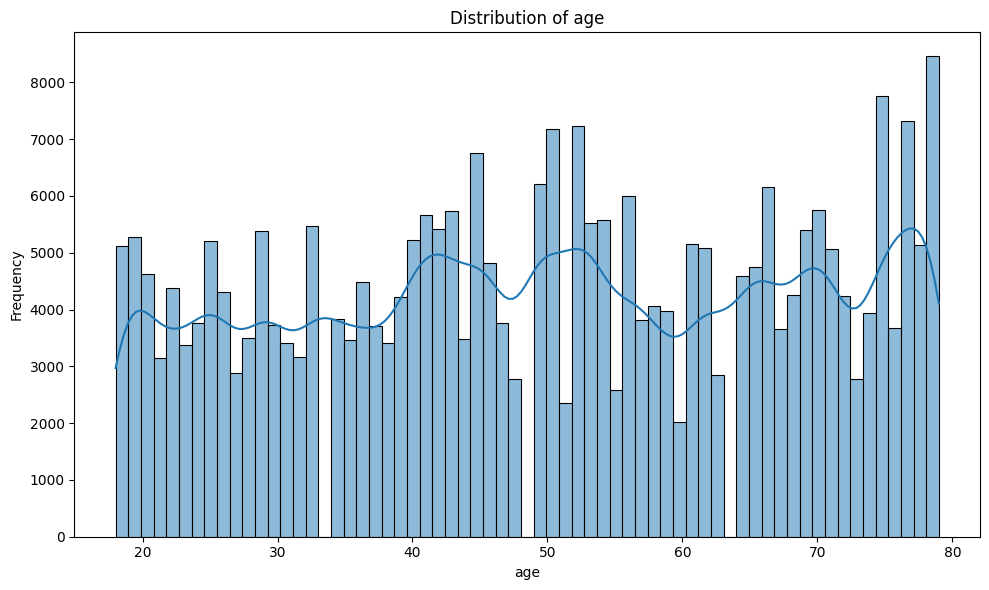

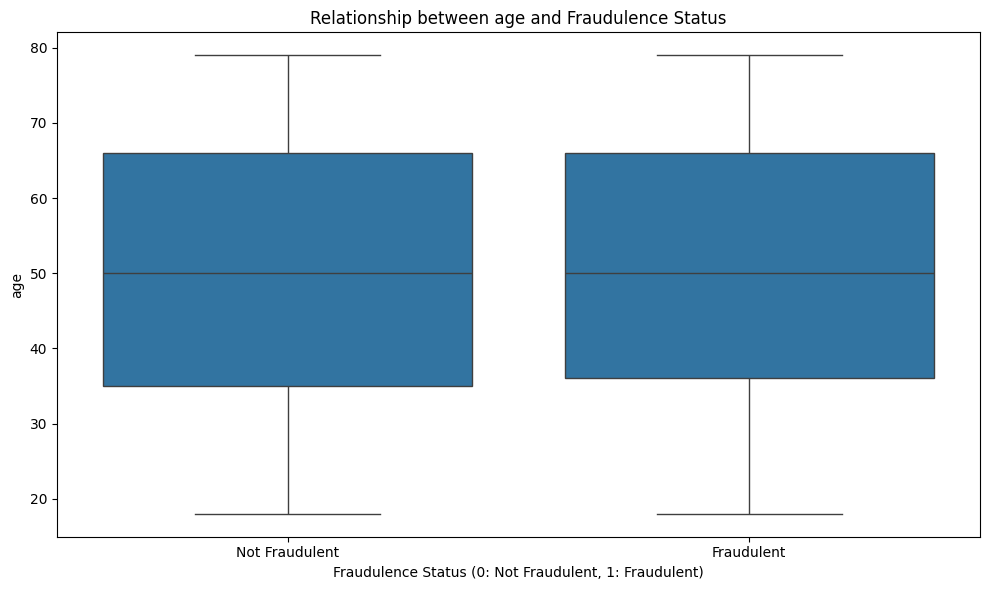


Analysis for column: credit_score

Descriptive statistics:


count    286068.000000
mean        652.938343
std         103.595359
min         300.000000
25%         587.000000
50%         657.000000
75%         726.000000
max         850.000000
Name: credit_score, dtype: float64

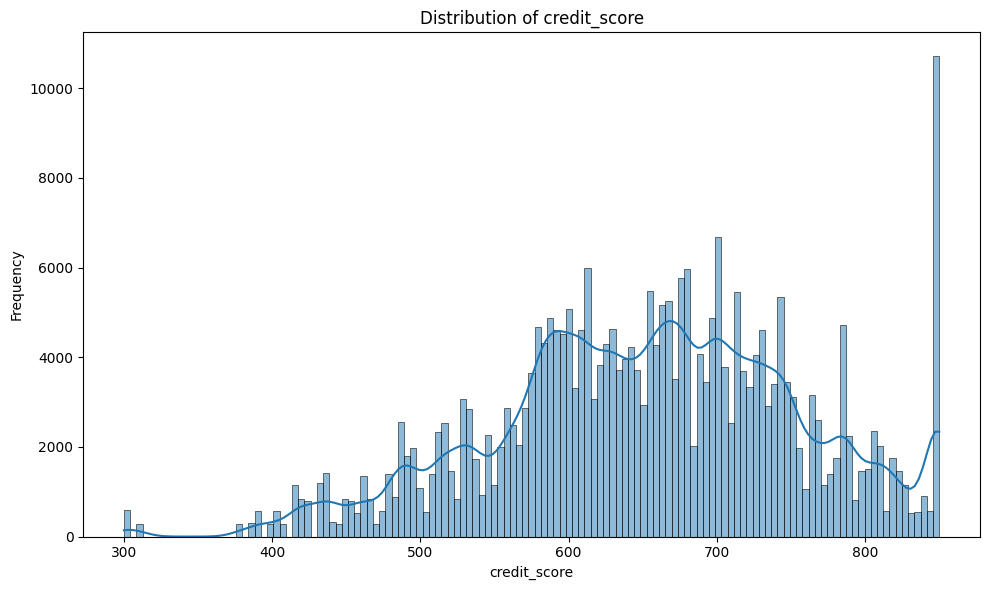

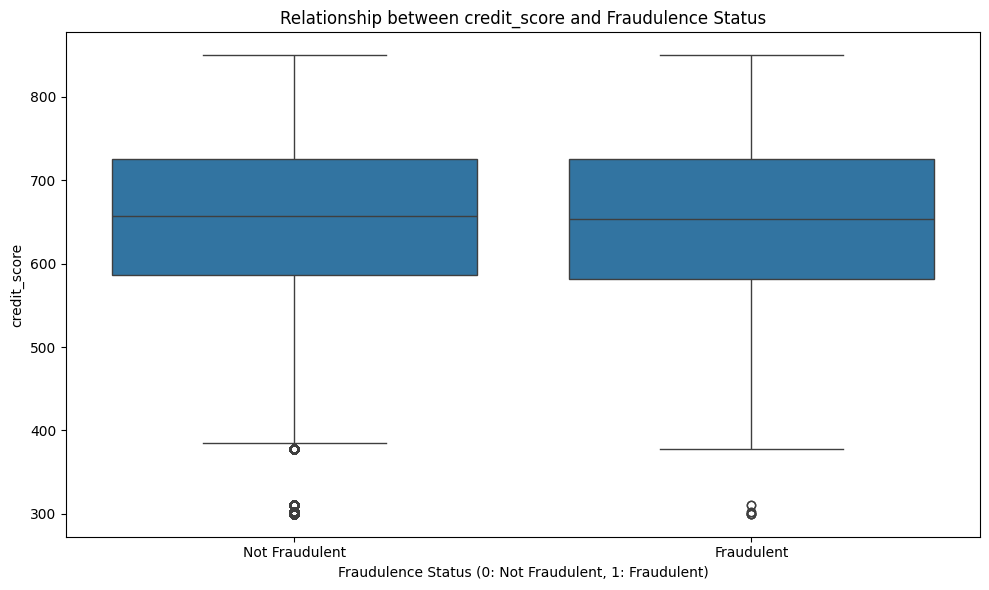

In [35]:
for col in numeric_df:
    print(f"\nAnalysis for column: {col}")

    # Calculate descriptive statistics
    print("\nDescriptive statistics:")
    display(df[col].describe())

    # Visualize distribution of the numeric variable
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Analyze relationship with survival_status
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Class', y=col)
    plt.title(f'Relationship between {col} and Fraudulence Status')
    plt.xlabel('Fraudulence Status (0: Not Fraudulent, 1: Fraudulent)')
    plt.ylabel(col)
    plt.xticks([0, 1], ['Not Fraudulent', 'Fraudulent'])
    plt.tight_layout()
    plt.show()

## Categorical Variables

/tmp/ipython-input-1421766817.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_top, x=col, order=top30, palette="rocket")


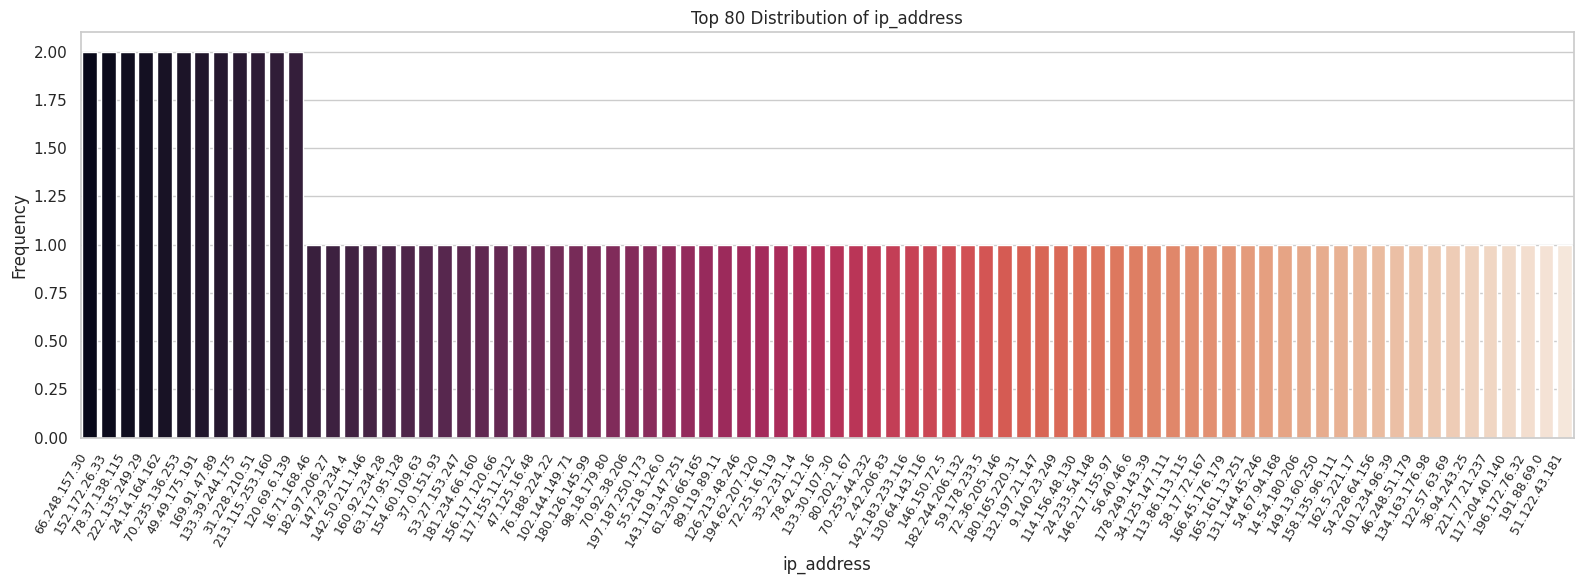

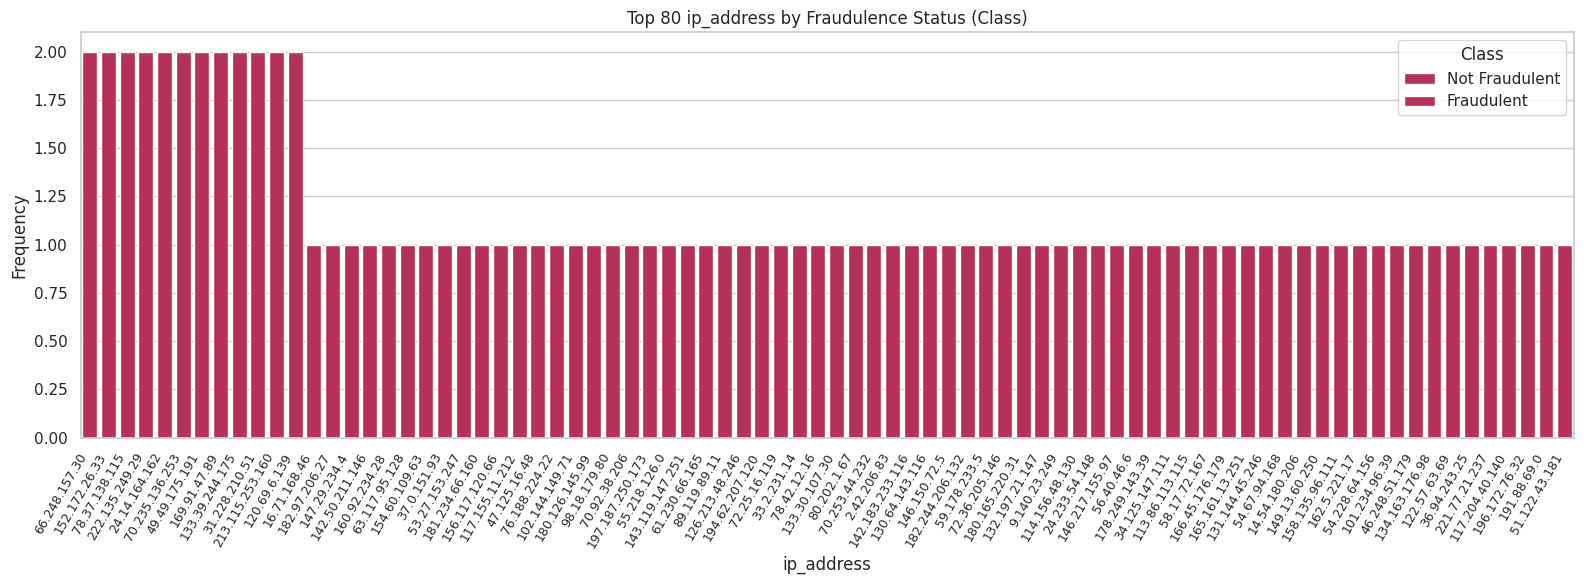

/tmp/ipython-input-1421766817.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_top, x=col, order=top30, palette="rocket")


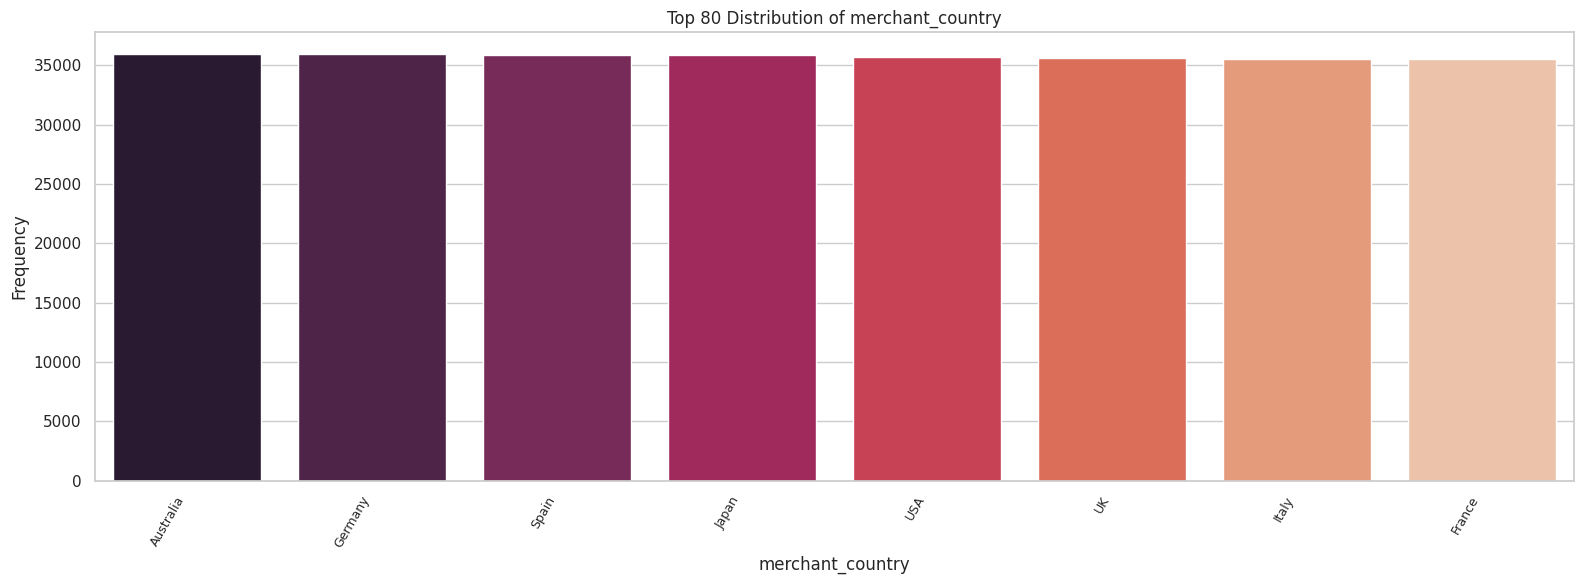

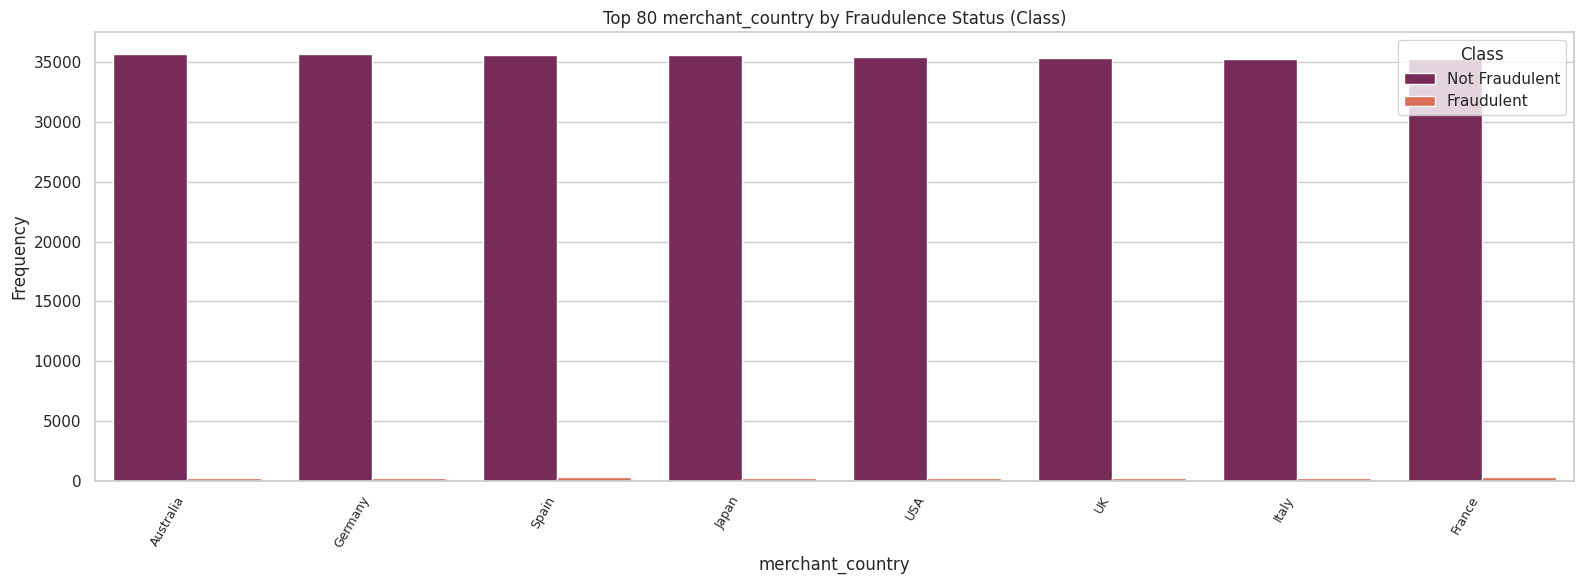

/tmp/ipython-input-1421766817.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_top, x=col, order=top30, palette="rocket")


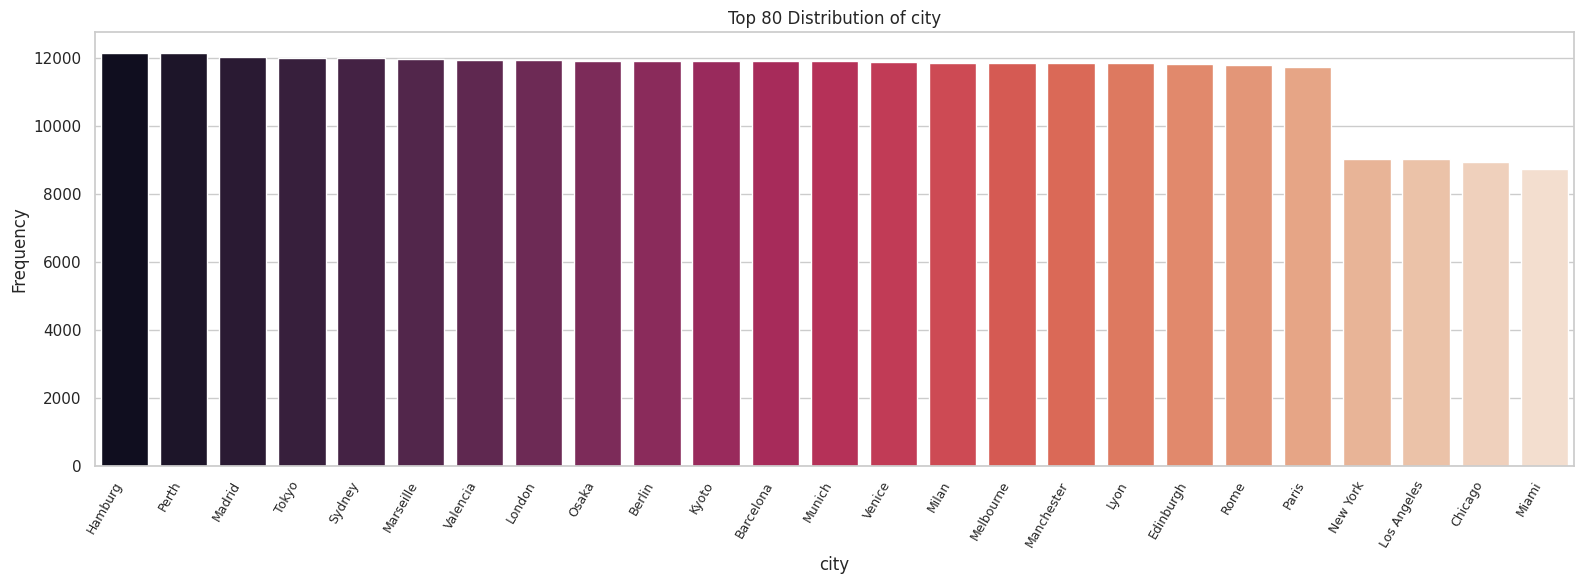

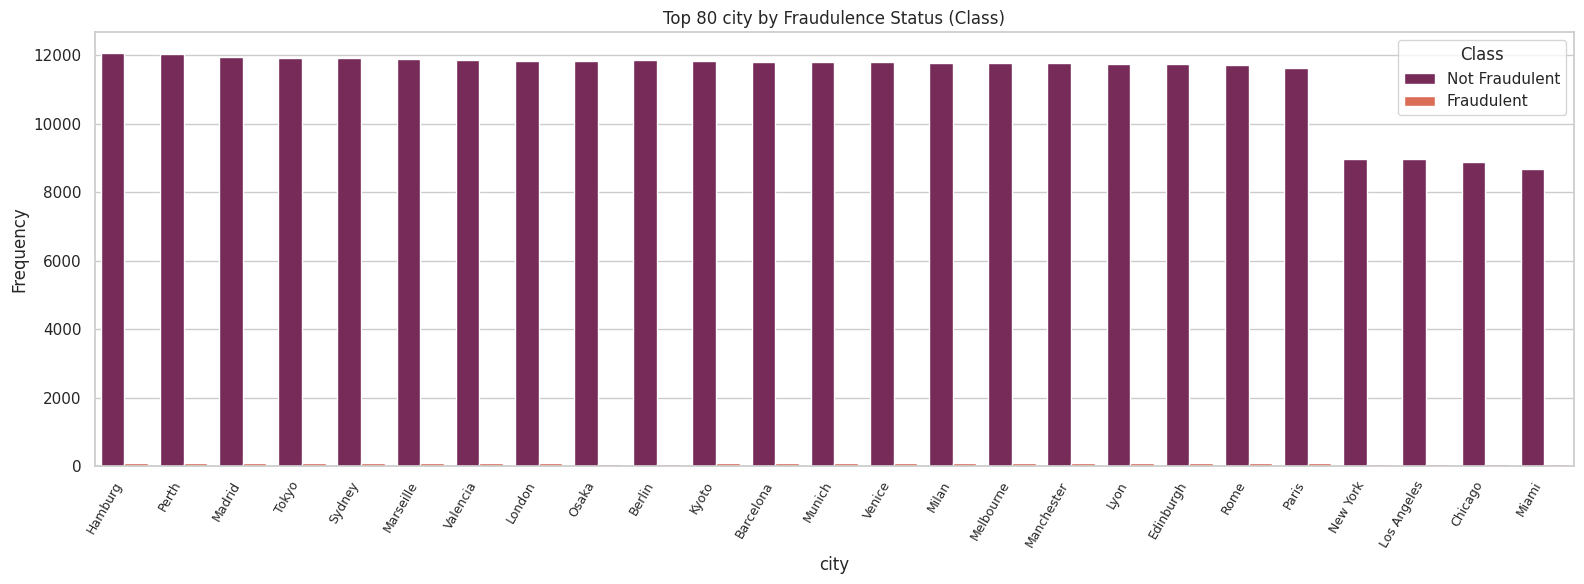

/tmp/ipython-input-1421766817.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_top, x=col, order=top30, palette="rocket")


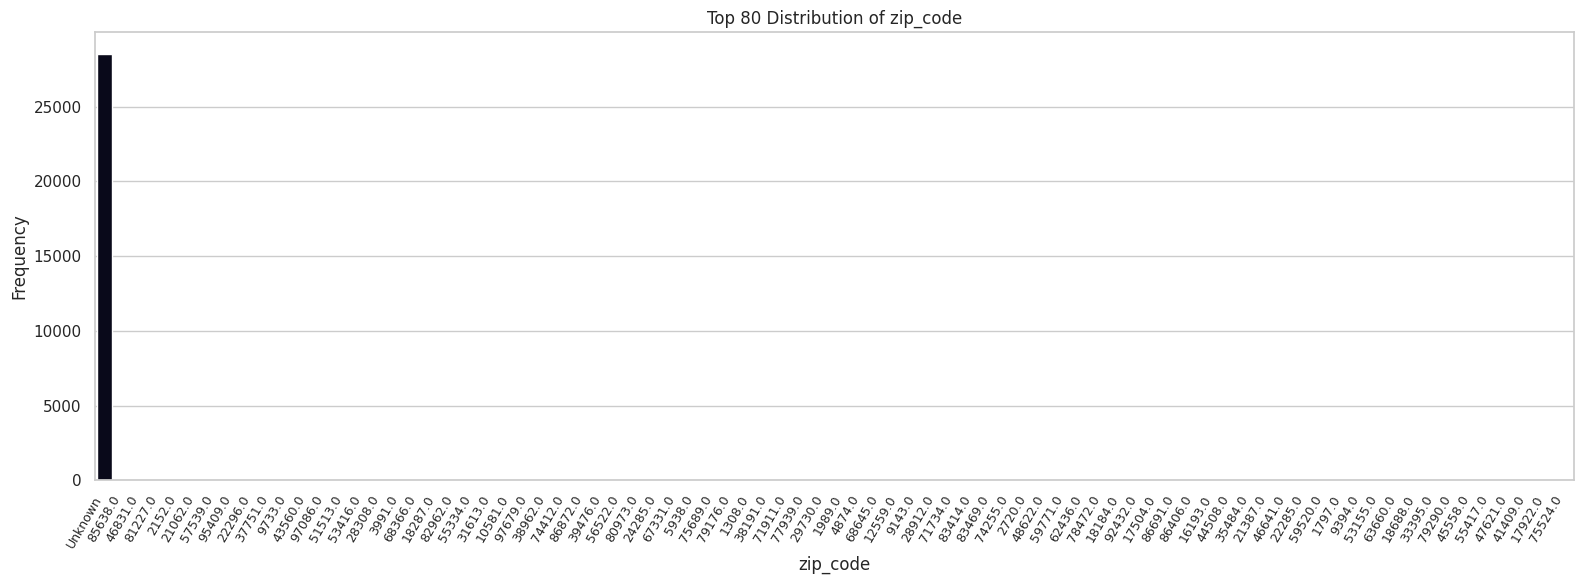

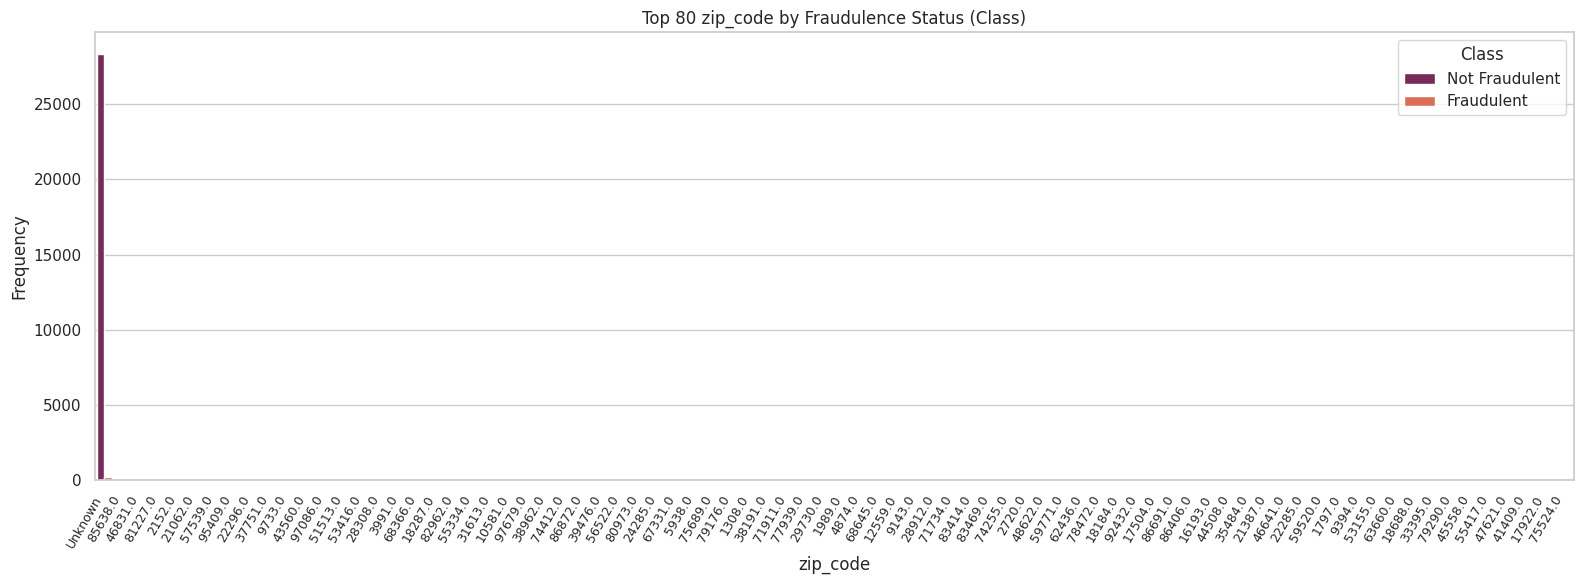

/tmp/ipython-input-1421766817.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_top, x=col, order=top30, palette="rocket")


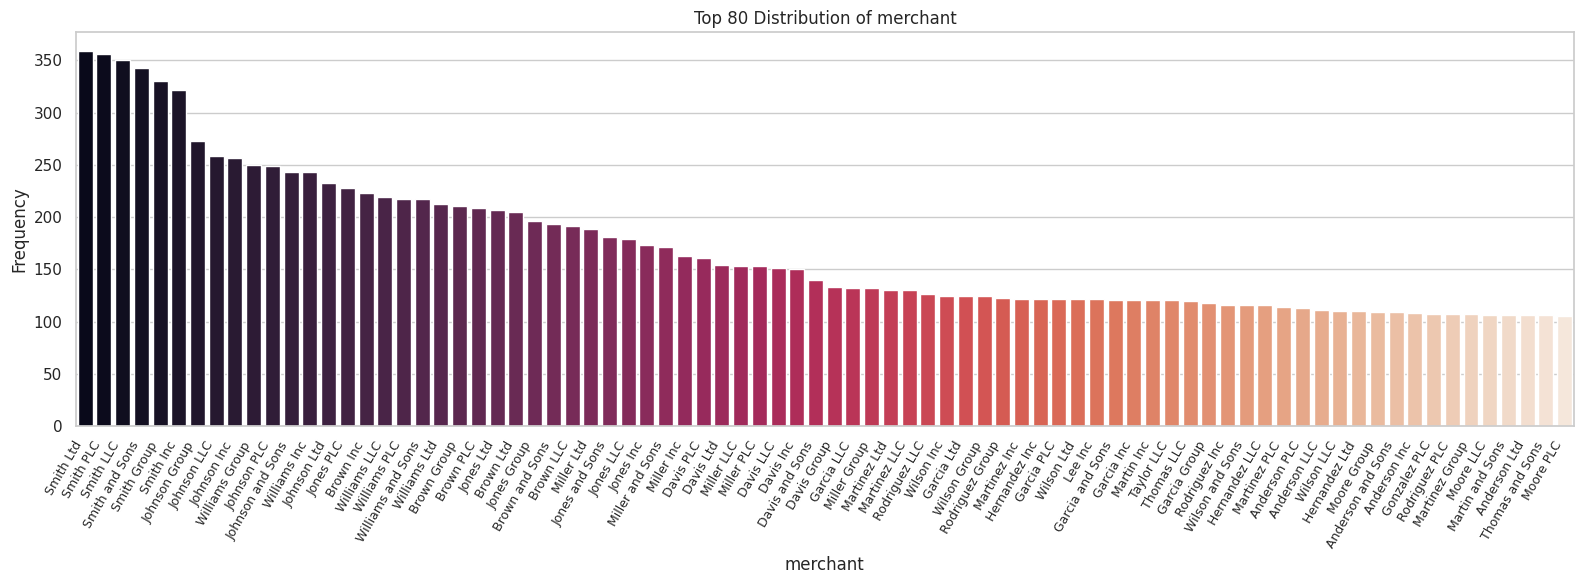

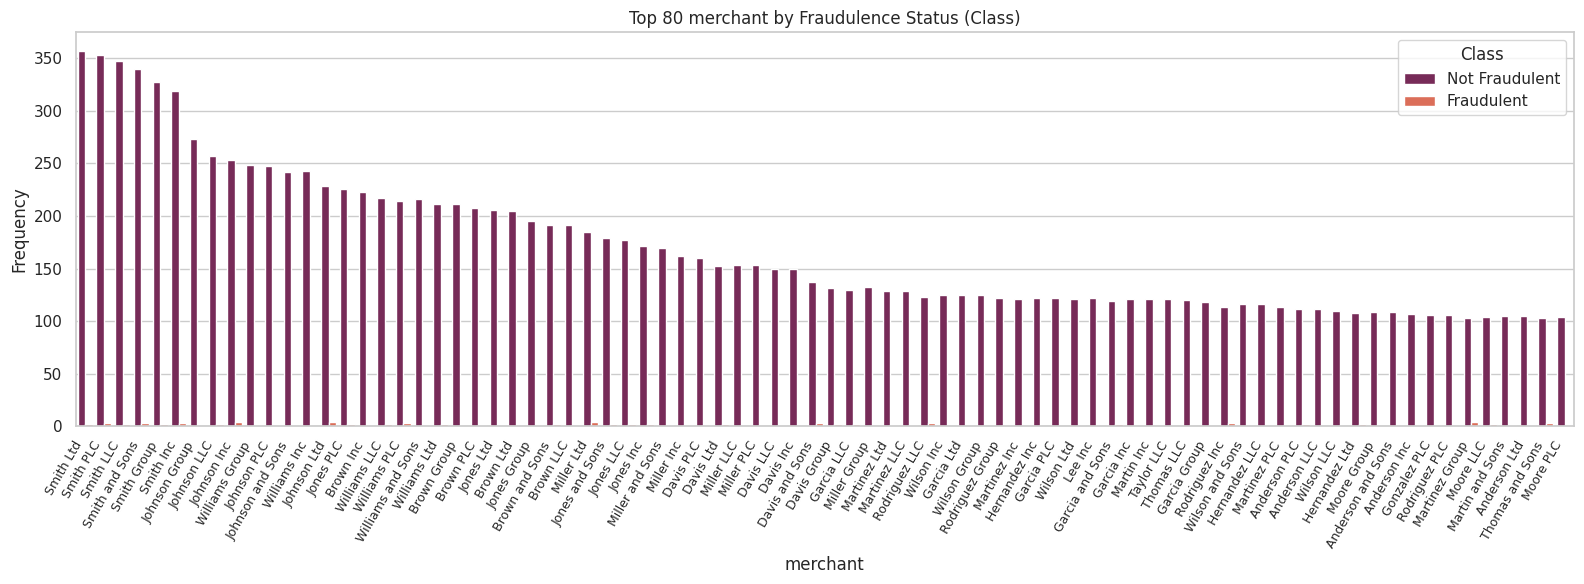

/tmp/ipython-input-1421766817.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_top, x=col, order=top30, palette="rocket")


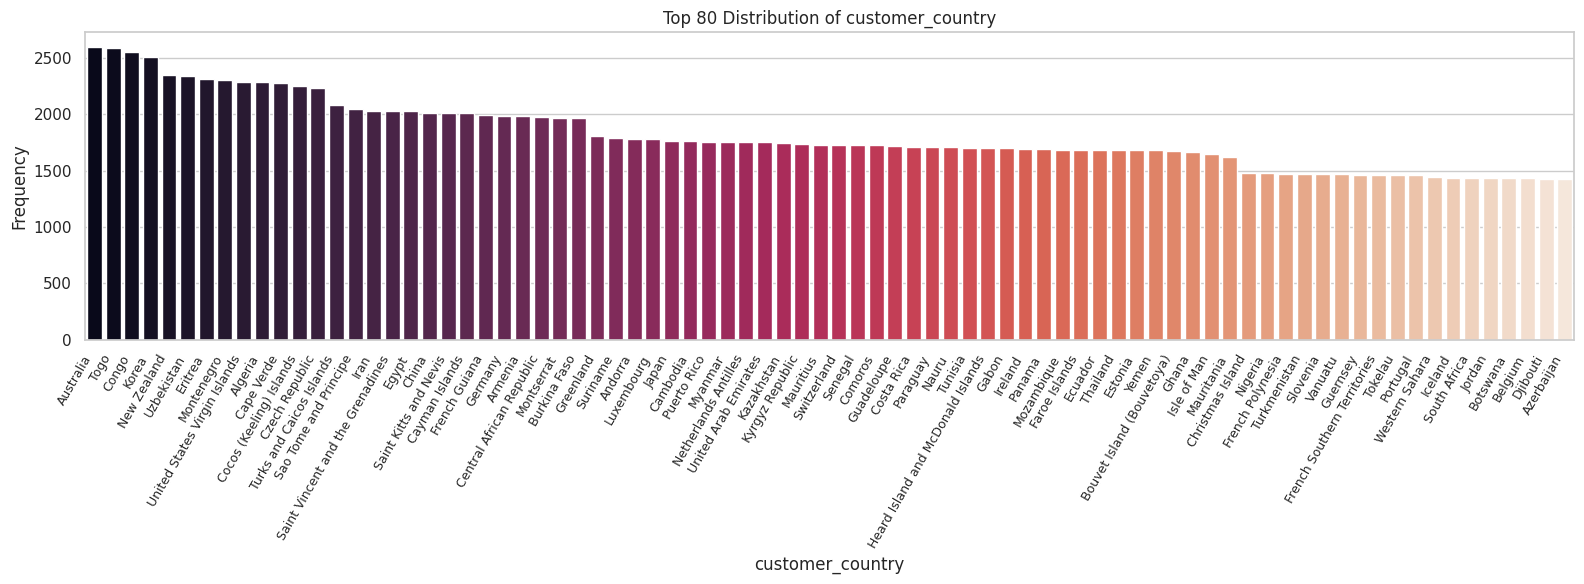

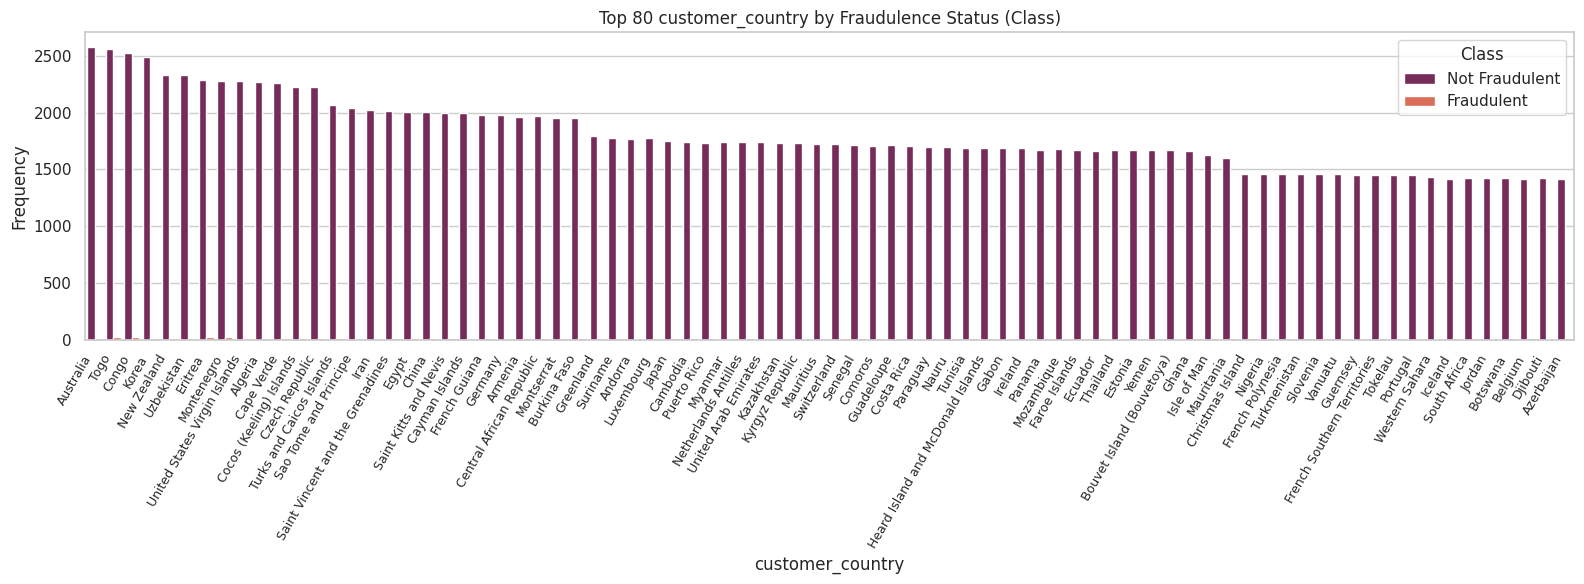

/tmp/ipython-input-1421766817.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_top, x=col, order=top30, palette="rocket")


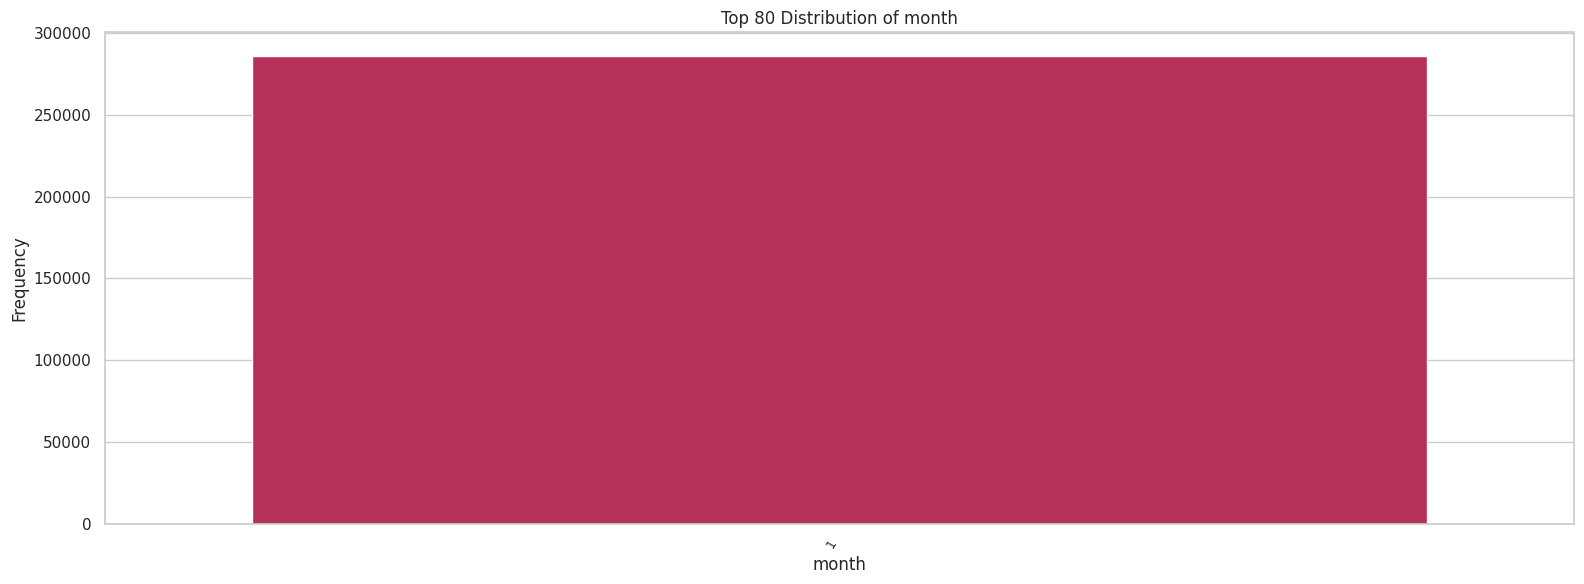

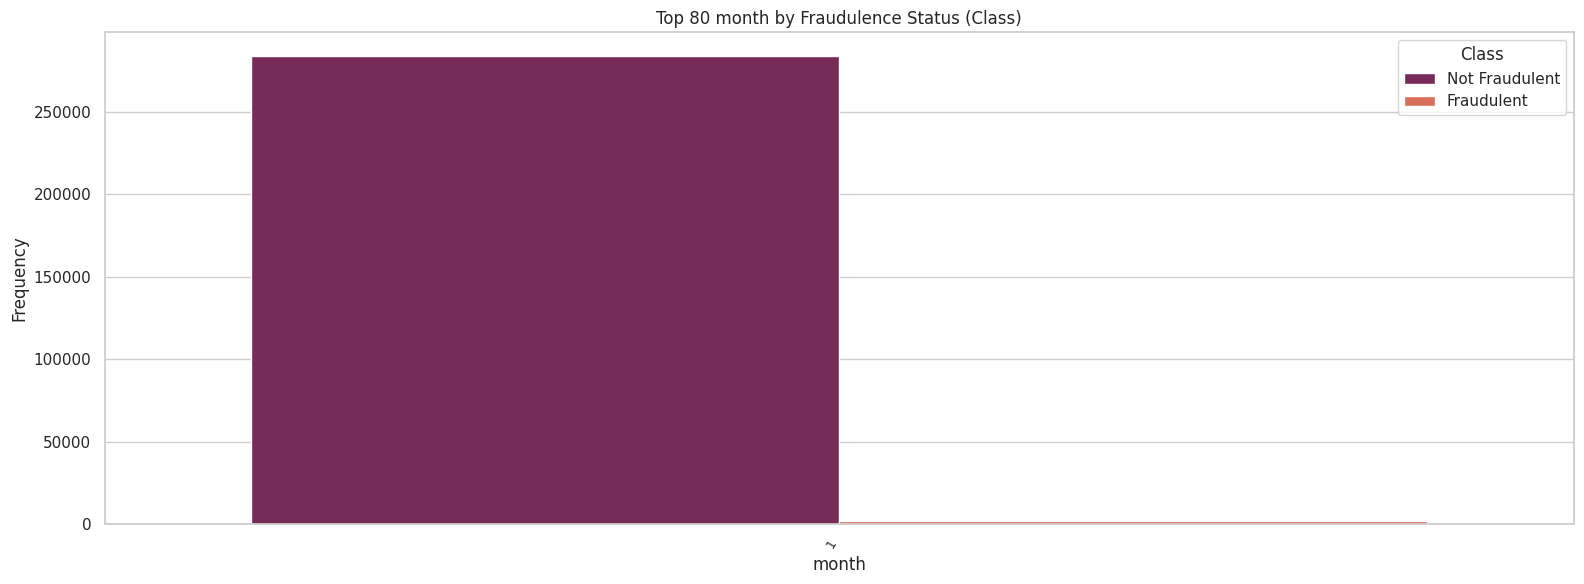

/tmp/ipython-input-1421766817.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_top, x=col, order=top30, palette="rocket")


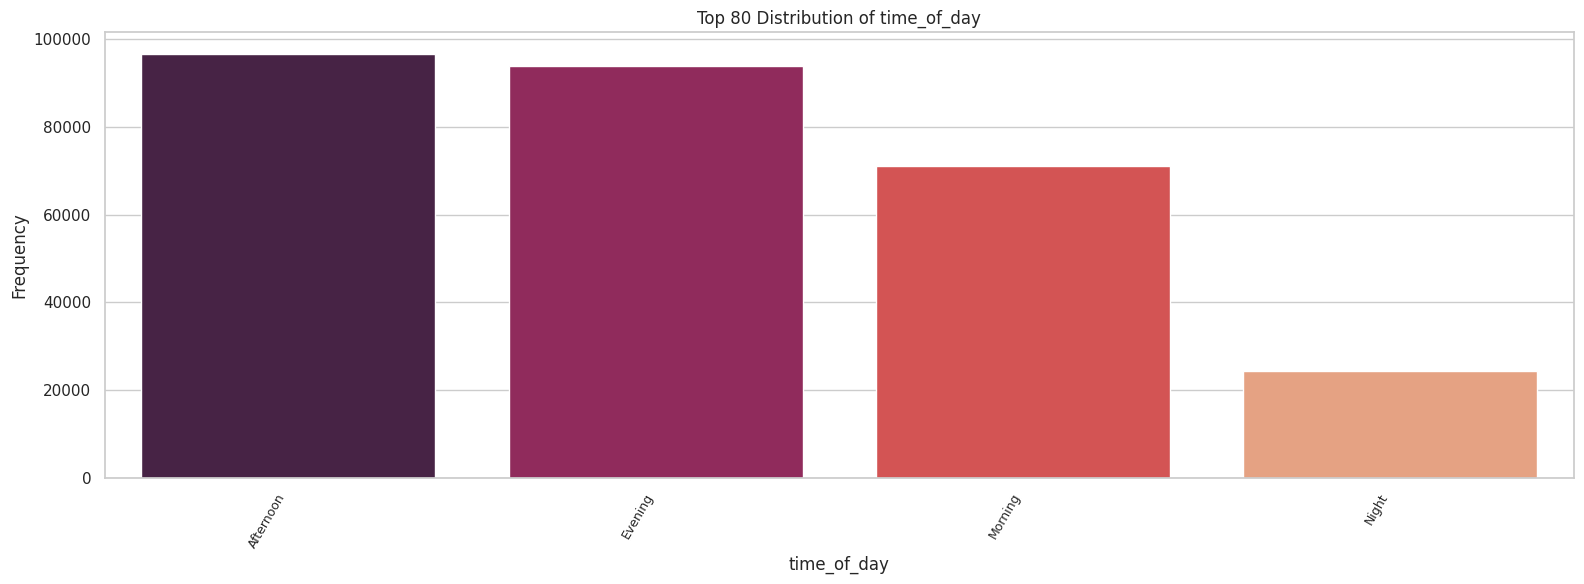

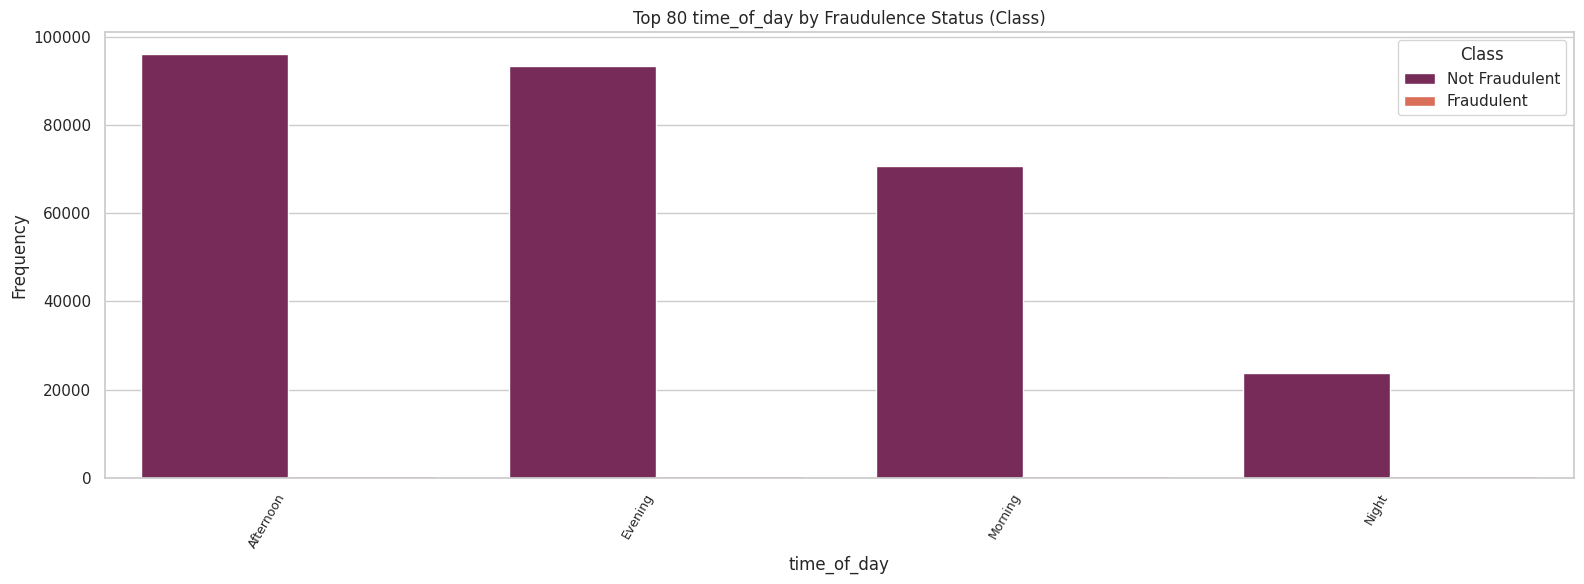

/tmp/ipython-input-1421766817.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_top, x=col, order=top30, palette="rocket")


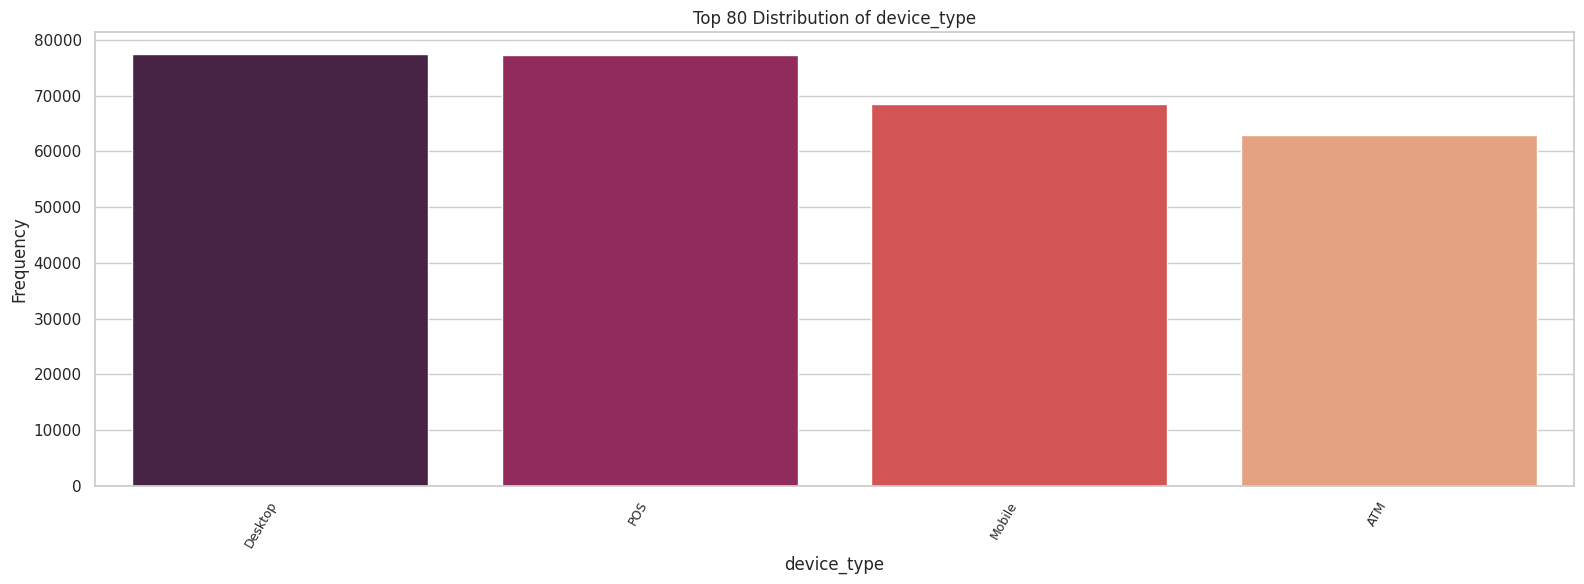

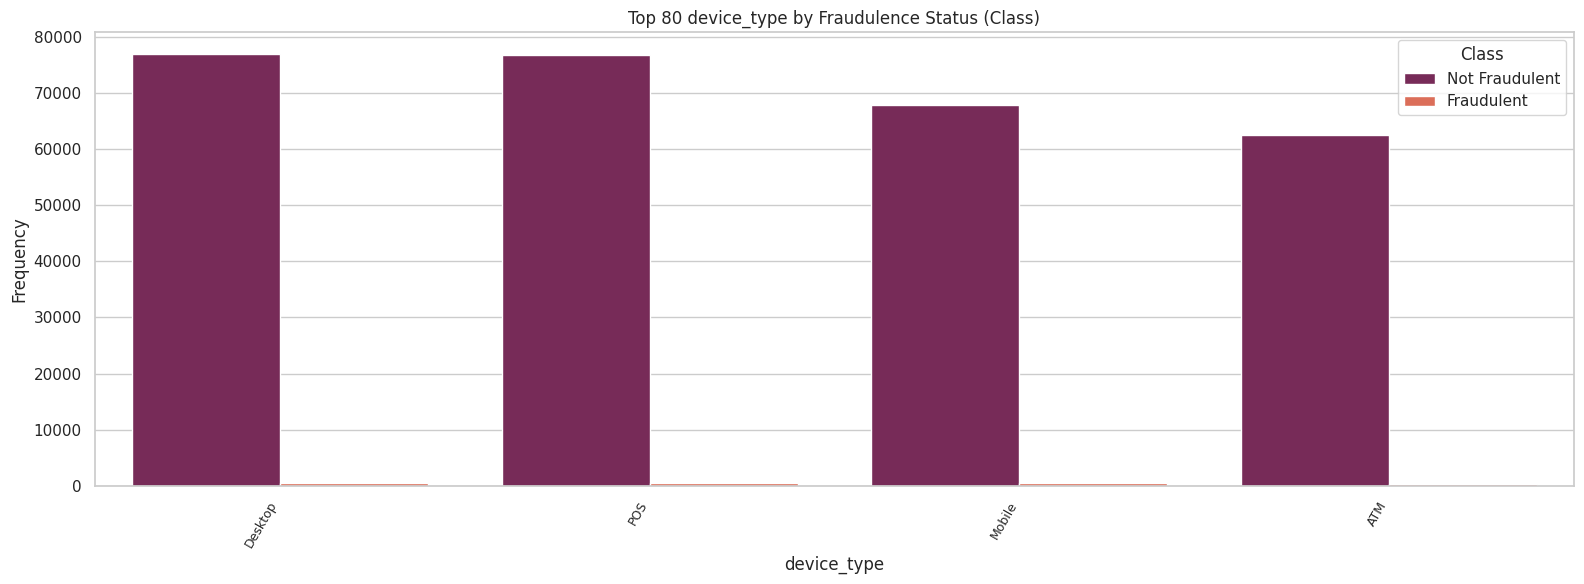

/tmp/ipython-input-1421766817.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_top, x=col, order=top30, palette="rocket")


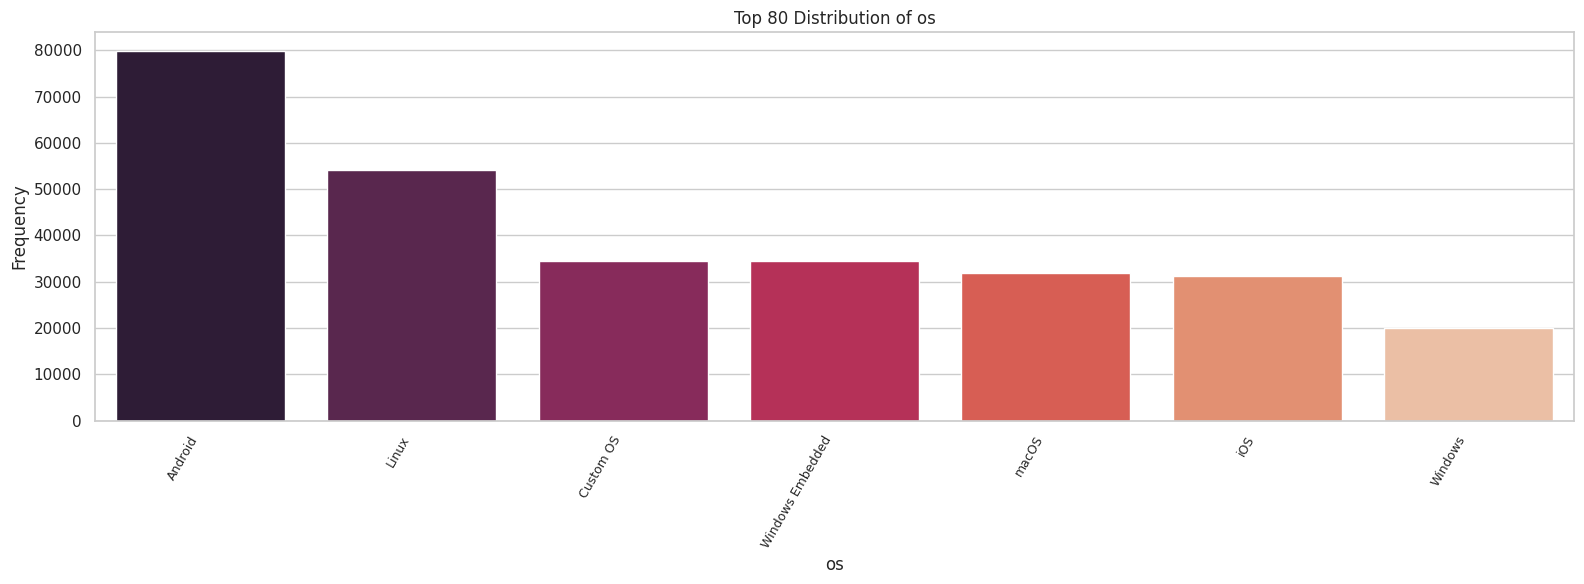

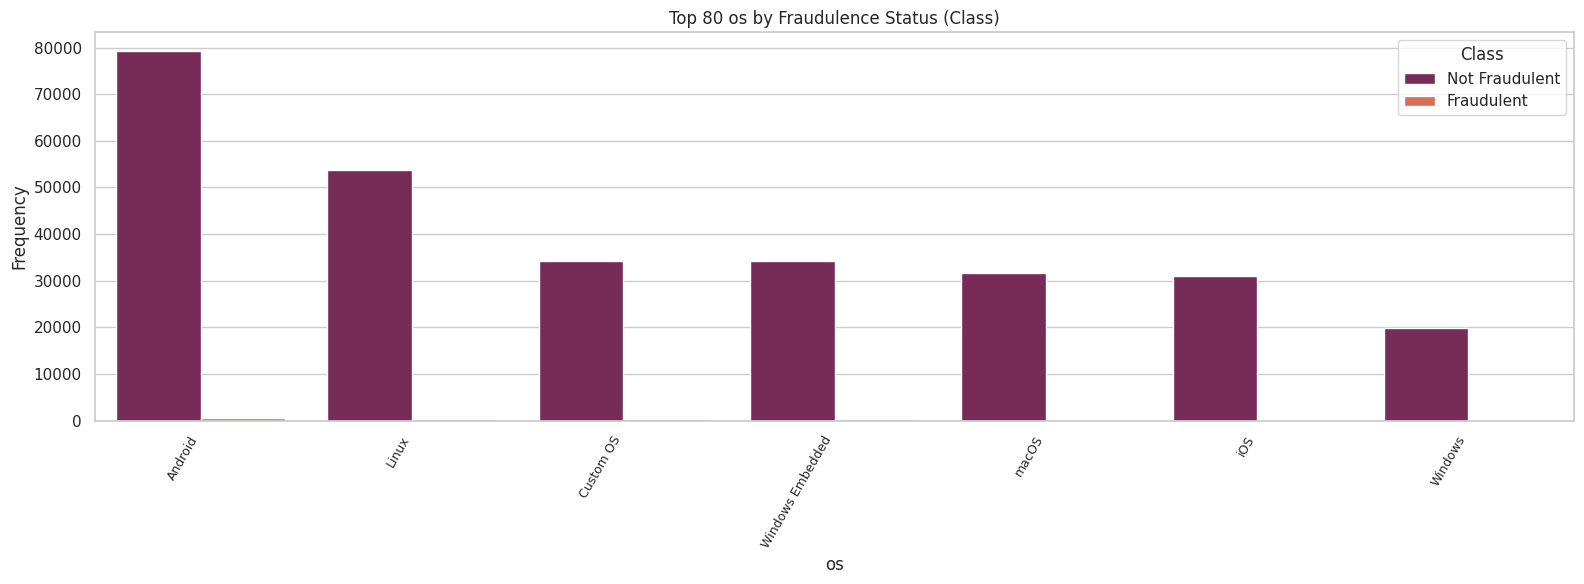

/tmp/ipython-input-1421766817.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_top, x=col, order=top30, palette="rocket")


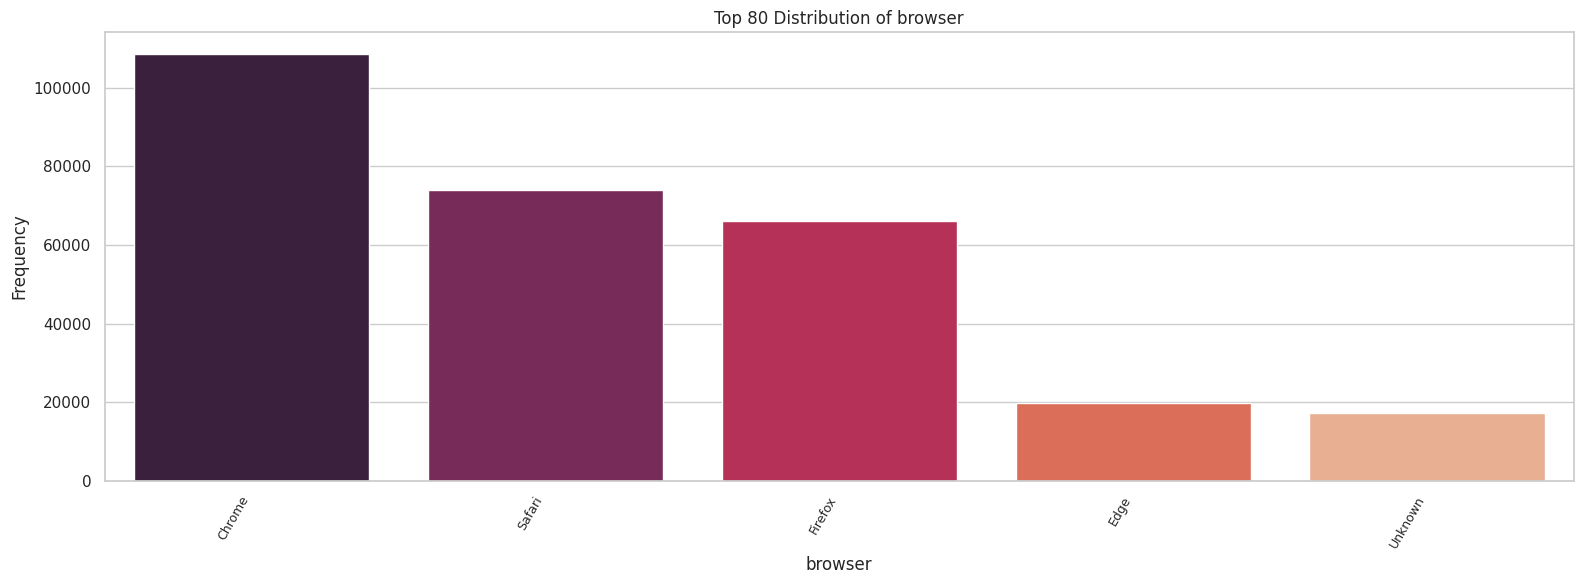

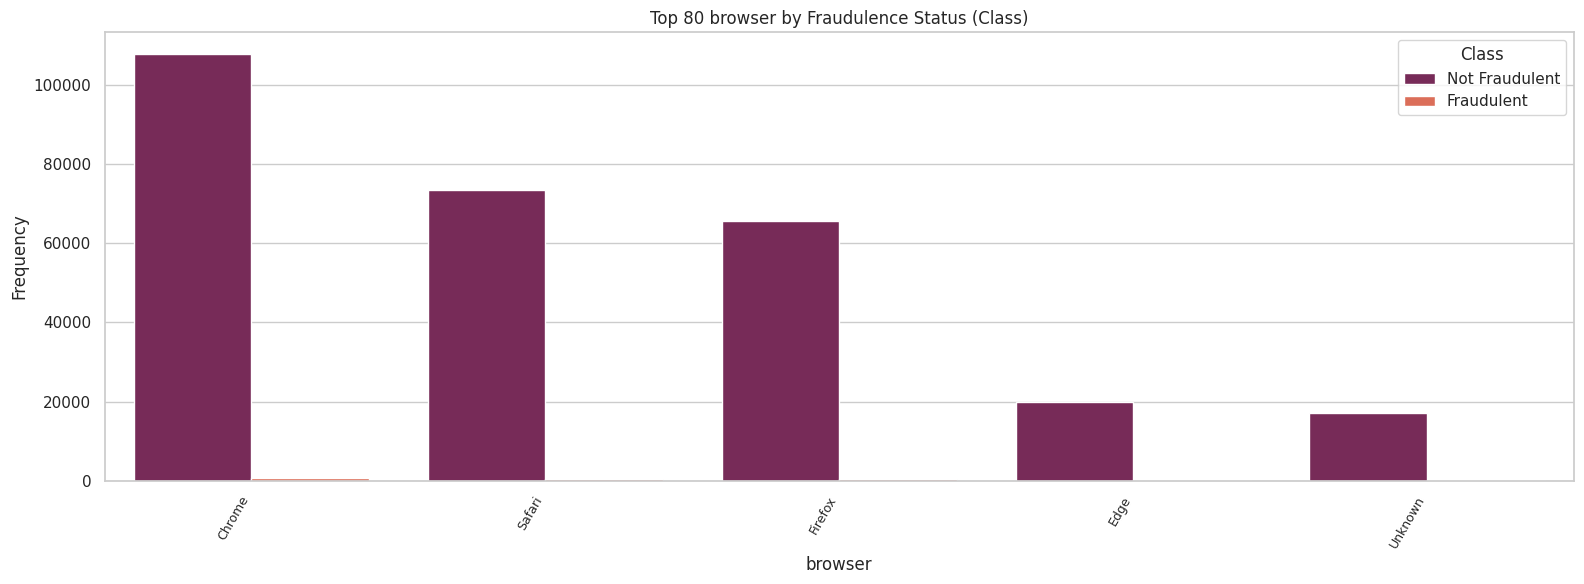

In [52]:
# From the variable info, some columns are described as binary or categorical
# but are stored as integers. We should also include these based on the description.
sns.set_theme(style="whitegrid")

for col in categoric_vars:
    # Top 30 categories by frequency
    top30 = df[col].value_counts().nlargest(80).index
    df_top = df[df[col].isin(top30)].copy()

    # 1) Distribution (top 80 only)
    plt.figure(figsize=(16, 6))
    sns.countplot(data=df_top, x=col, order=top30, palette="rocket")
    plt.title(f"Top 80 Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.xticks(rotation=60, ha="right", fontsize=9)
    plt.tight_layout()
    plt.show()

    # 2) Distribution by Class (top 80 only)
    plt.figure(figsize=(16, 6))
    sns.countplot(data=df_top, x=col, hue="Class", order=top30, palette="rocket")
    plt.title(f"Top 80 {col} by Fraudulence Status (Class)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.xticks(rotation=60, ha="right", fontsize=9)
    plt.legend(title="Class", labels=["Not Fraudulent", "Fraudulent"])
    plt.tight_layout()
    plt.show()


## Binary Variables


Analysis for column: is_foreign_tx

Frequency of each category:


is_foreign_tx
1    285145
0      1170
Name: count, dtype: int64


Frequency by is_foreign_tx and fraudulence_status:


Class               0     1
is_foreign_tx              
0                1163     7
1              283152  1993

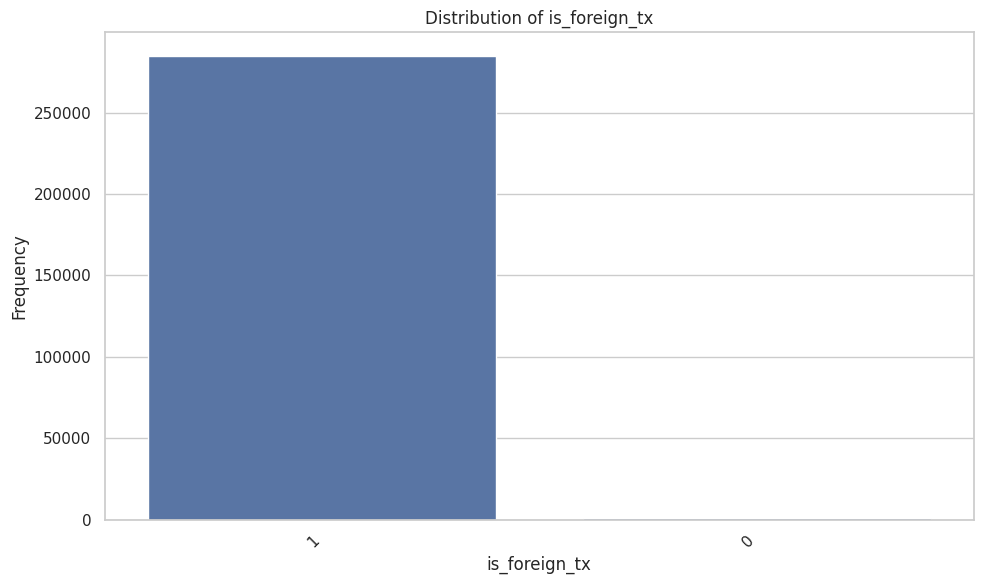

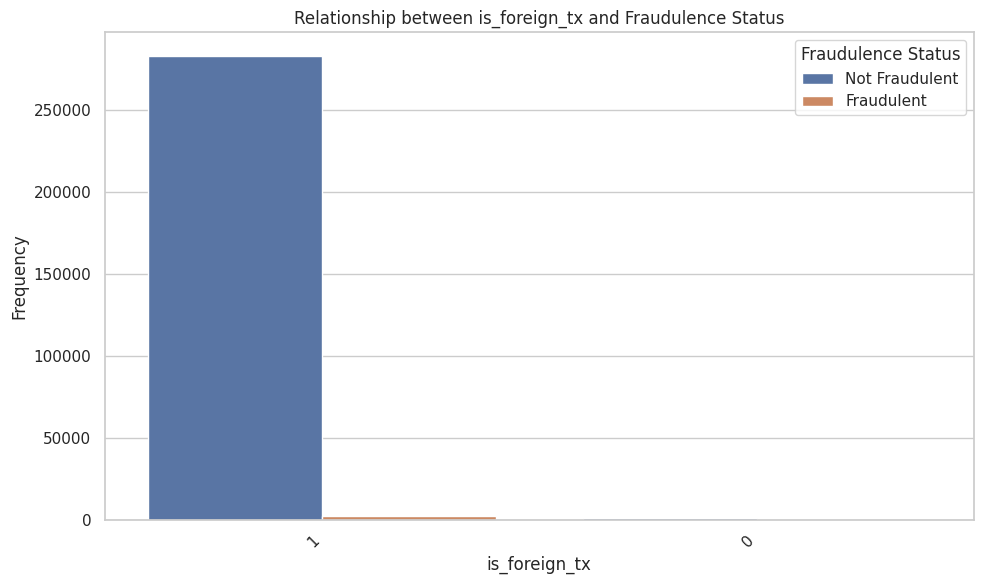


Analysis for column: is_night_tx

Frequency of each category:


is_night_tx
0    261975
1     24340
Name: count, dtype: int64


Frequency by is_night_tx and fraudulence_status:


Class             0     1
is_night_tx              
0            260505  1470
1             23810   530

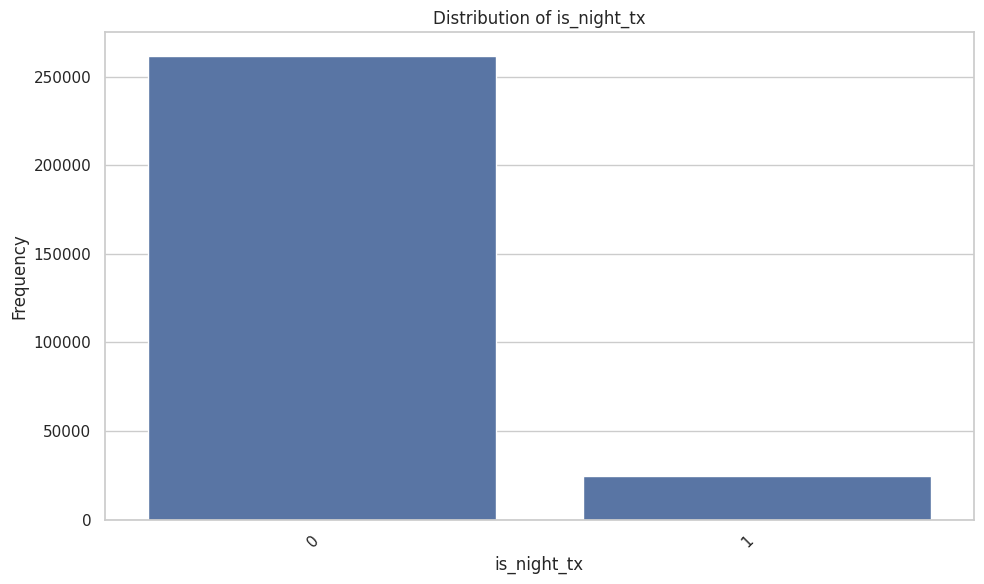

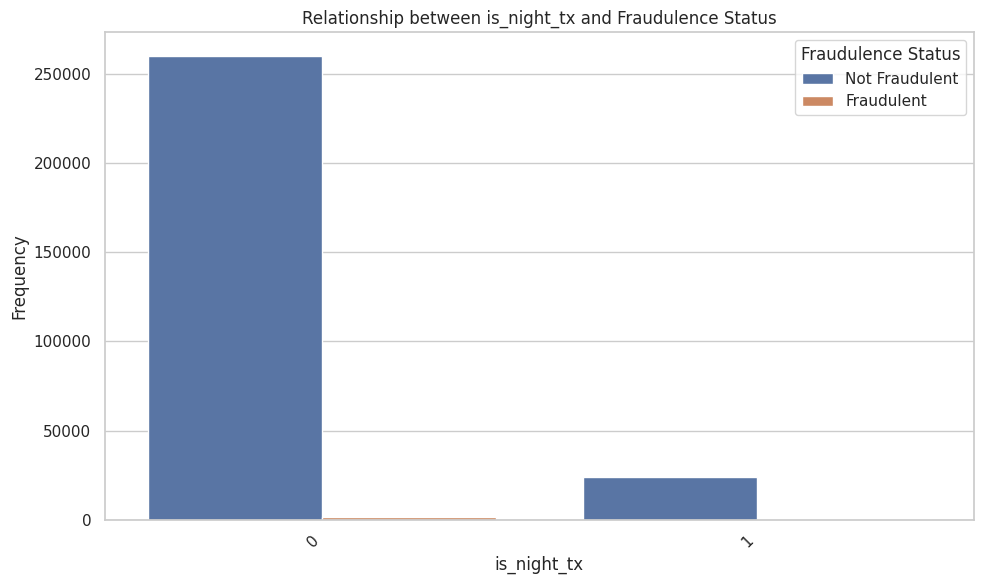


Analysis for column: is_high_amount

Frequency of each category:


is_high_amount
0    283358
1      2957
Name: count, dtype: int64


Frequency by is_high_amount and fraudulence_status:


Class                0     1
is_high_amount              
0               281384  1974
1                 2931    26

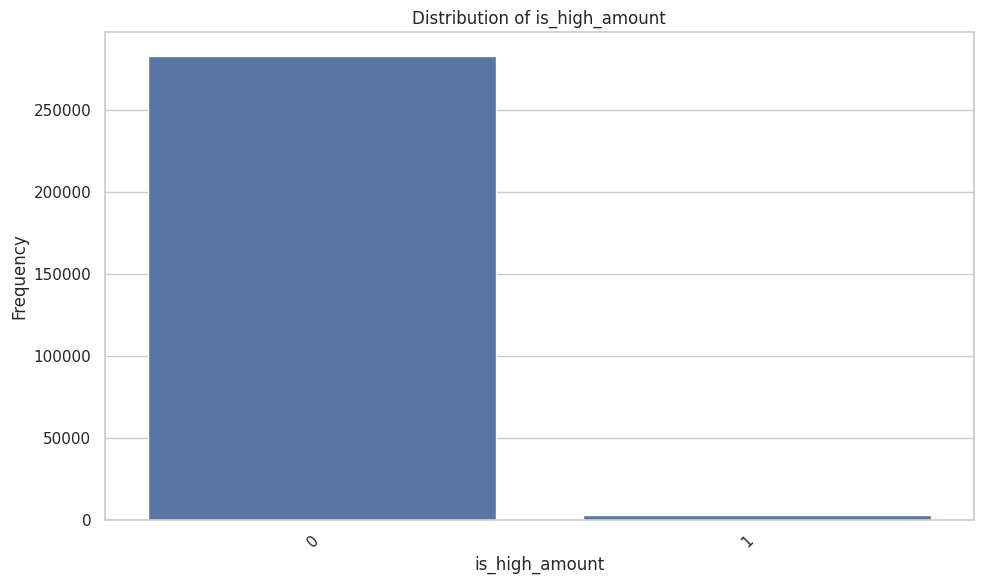

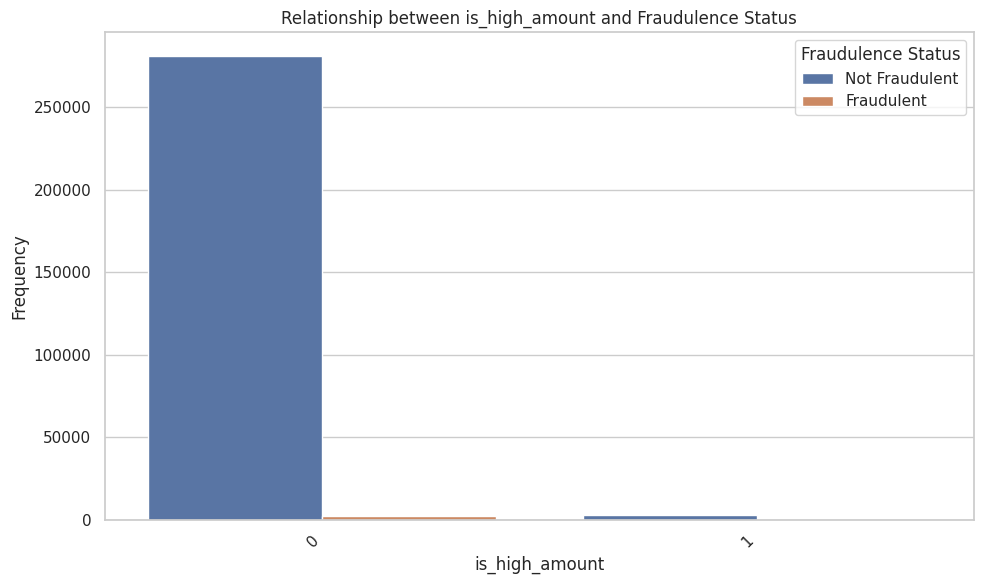


Analysis for column: day_of_week

Frequency of each category:


day_of_week
6    145647
0    140668
Name: count, dtype: int64


Frequency by day_of_week and fraudulence_status:


Class             0     1
day_of_week              
0            139810   858
6            144505  1142

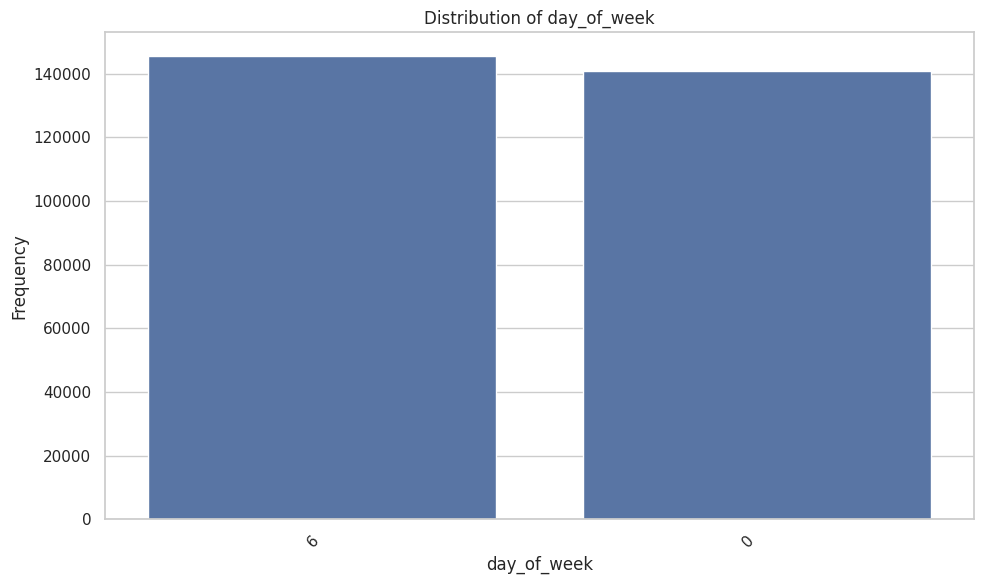

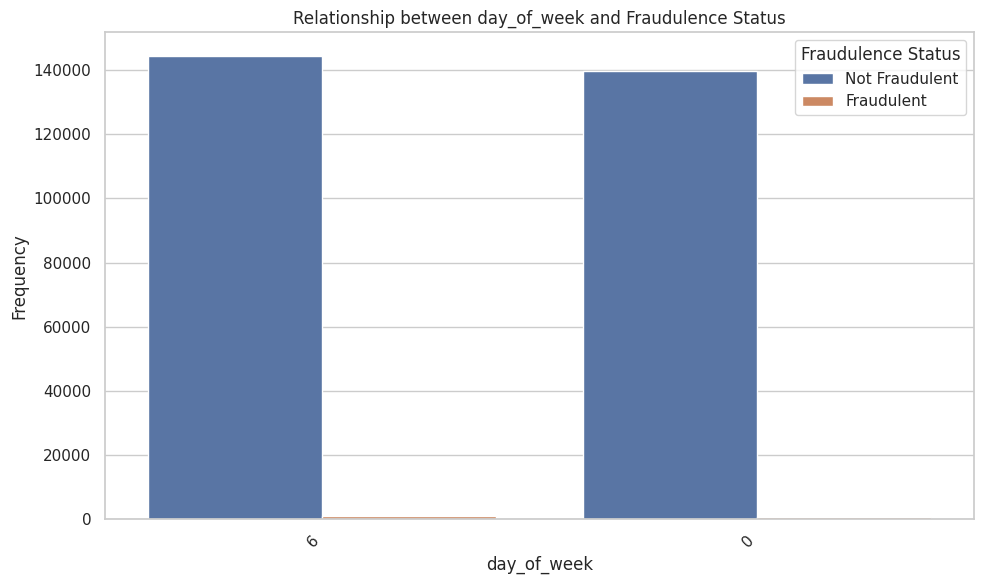


Analysis for column: is_weekend

Frequency of each category:


is_weekend
1    145647
0    140668
Name: count, dtype: int64


Frequency by is_weekend and fraudulence_status:


Class            0     1
is_weekend              
0           139810   858
1           144505  1142

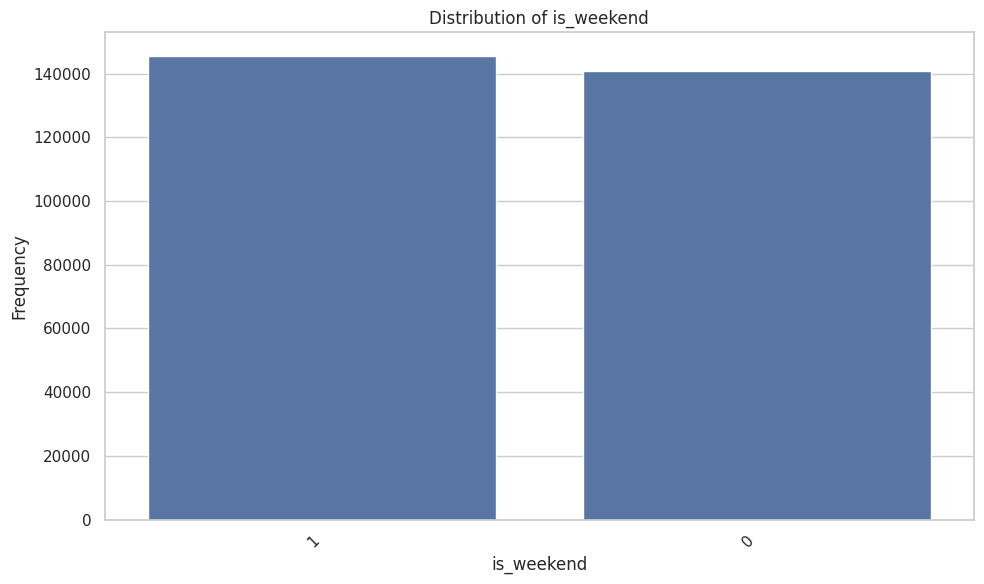

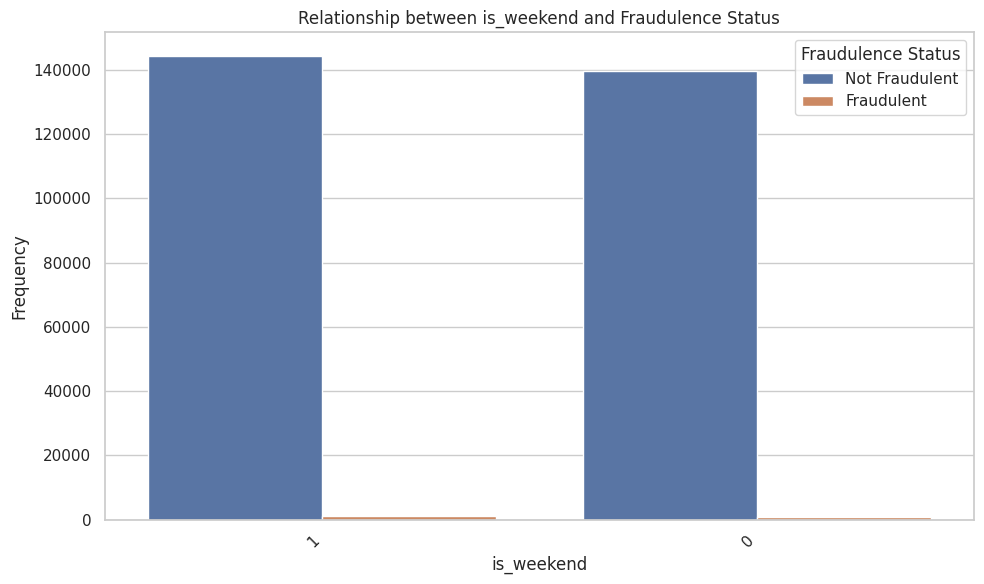


Analysis for column: is_mobile

Frequency of each category:


is_mobile
0    217844
1     68471
Name: count, dtype: int64


Frequency by is_mobile and fraudulence_status:


Class           0     1
is_mobile              
0          216365  1479
1           67950   521

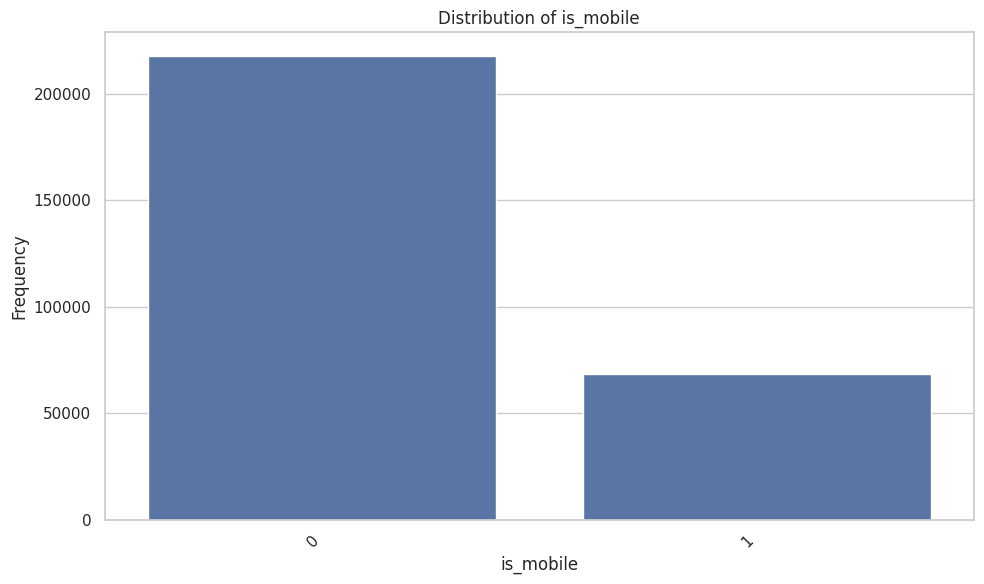

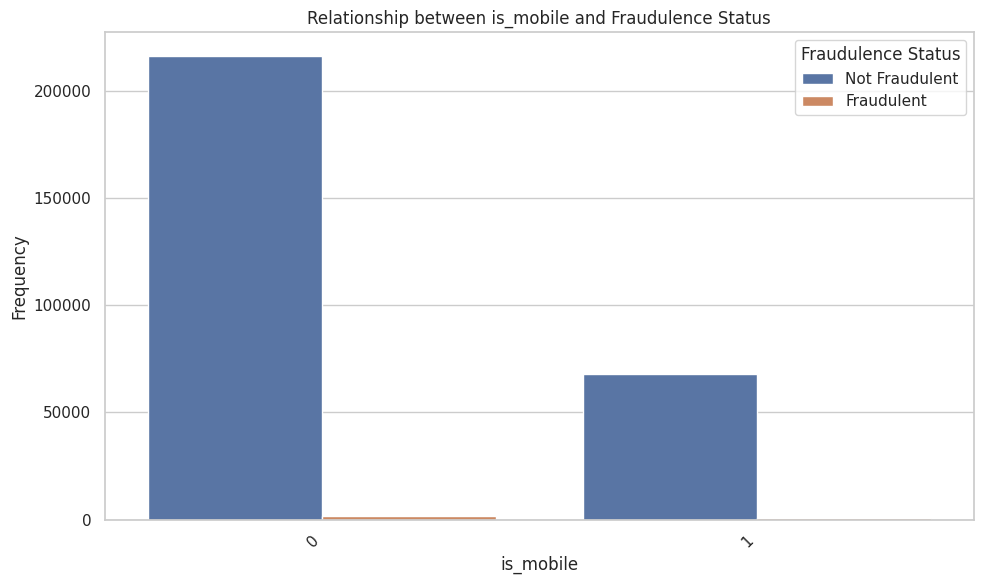

In [37]:
# From the variable info, some columns are described as binary
# but are stored as integers. We should also include these based on the description.
for col in binary_vars:
    print(f"\nAnalysis for column: {col}")


    # Calculate frequency of each category
    print("\nFrequency of each category:")
    display(df[col].value_counts())


    # Calculate frequency of each category in relation to fraudulence_status
    print(f"\nFrequency by {col} and fraudulence_status:")
    display(pd.crosstab(df[col], df['Class']))


    # Visualize distribution of binary variables
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


    # Visualize relationship between binary variable and fraudulence_status
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue='Class', order=df[col].value_counts().index)
    plt.title(f'Relationship between {col} and Fraudulence Status')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Fraudulence Status', labels=['Not Fraudulent', 'Fraudulent'])
    plt.tight_layout()
    plt.show()


## Handle Missing Values

Missing Values  Percentage
zip_code                   28632   10.000175
browser                    17356    6.061855
email                      14461    5.050731
phone                       5863    2.047745
name                         247    0.086269
age                          247    0.086269
customer_country             247    0.086269
credit_score                 247    0.086269
join_date                    247    0.086269

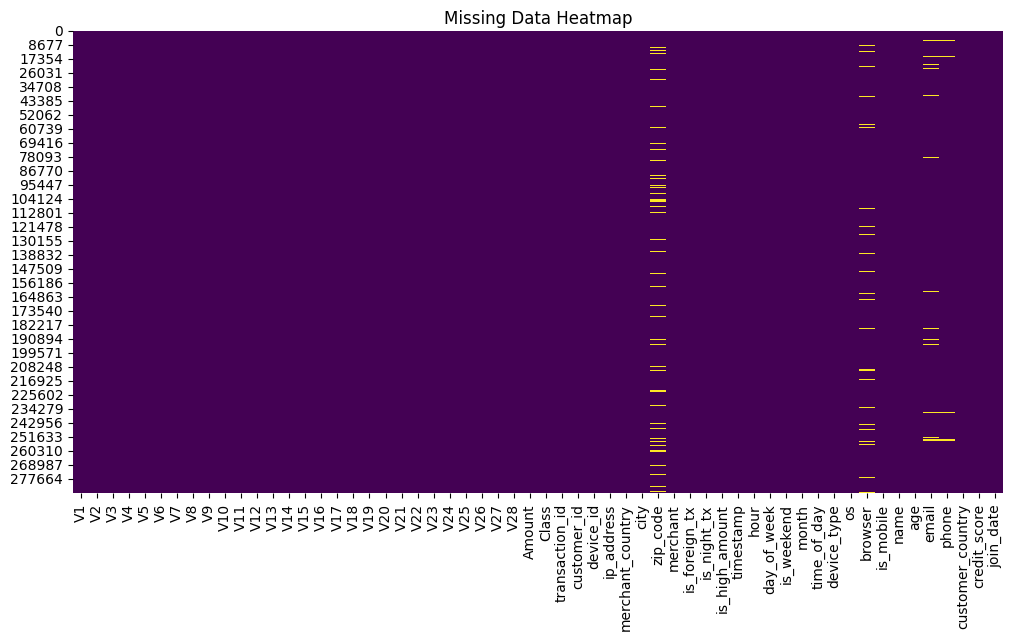

In [32]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

missing_info = missing_info[missing_info['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)
display(missing_info)

plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

Class
0    247
Name: count, dtype: int64


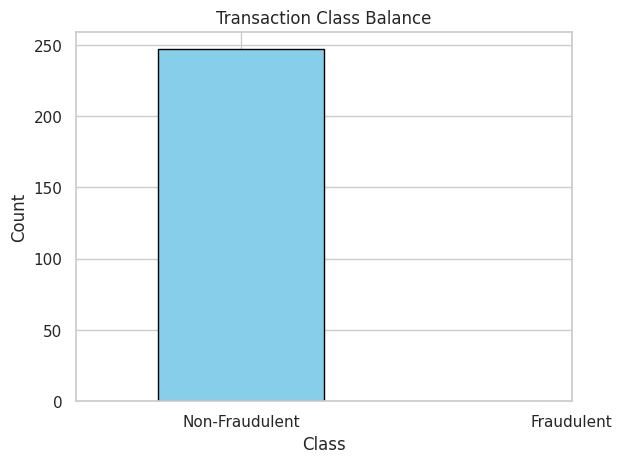

In [38]:
# Since we have performed a left join when merging the dataset customer in order
# to not get rid of transactions without solid reasons we are going to check wether
# the rows that have been left without customer information consist of any fraudulent transactions
no_customer_df = df[df['name'].isna()]
print(no_customer_df["Class"].value_counts())
no_customer_df["Class"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Transaction Class Balance")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Non-Fraudulent", "Fraudulent"], rotation=0)
plt.show()

In [39]:
# Since there are no fraudulent transactions we get rid of these 247 rows
df = df.dropna(subset=['name'])

In [40]:
# We check missing values again
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

missing_info = missing_info[missing_info['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)
display(missing_info)

Missing Values  Percentage
zip_code           28549    9.979795
browser            17341    6.061845
email              14214    4.968749
phone               5616    1.963170

In [41]:
df["zip_code"] = df["zip_code"].fillna('Unknown')
df["browser"] = df["browser"].fillna('Unknown')
df["email"] = df["email"].fillna('Unknown')
df["phone"] = df["phone"].fillna('Unknown')

## Outliers analysis

### Numeric Variables

In [42]:
outlier_summary = []

for col in numeric_df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    n_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_summary.append((col, n_outliers, n_outliers/len(df)*100))

outlier_df = pd.DataFrame(outlier_summary, columns=["Feature", "Outliers", "% Outliers"]).sort_values(by="% Outliers", ascending=False)
display(outlier_df.head(15))

Feature  Outliers  % Outliers
26     V27     39666   13.865934
28  Amount     32038   11.199435
27     V28     30830   10.777158
19     V20     28214    9.862690
7       V8     24624    8.607744
5       V6     23320    8.151908
22     V23     18890    6.603325
11     V12     16290    5.694450
13     V14     15190    5.309926
20     V21     15169    5.302585
1       V2     14171    4.953717
4       V5     12829    4.484598
3       V4     11839    4.138527
9      V10     10622    3.713103
18     V19     10498    3.669757

In [43]:
# We check for any negative values in numeric variables
neg_check = (numeric_df < 0).any()
print("Columns with negative values:")
print(neg_check[neg_check == True])

Columns with negative values:
V1     True
V2     True
V3     True
V4     True
V5     True
V6     True
V7     True
V8     True
V9     True
V10    True
V11    True
V12    True
V13    True
V14    True
V15    True
V16    True
V17    True
V18    True
V19    True
V20    True
V21    True
V22    True
V23    True
V24    True
V25    True
V26    True
V27    True
V28    True
dtype: bool


In [44]:
# We make sure all the ages are in reasonable intervales
print(df.loc[df["age"] < 18])
print(df.loc[df["age"] > 100])
# We see age ranges between 18 to 79

Empty DataFrame
Columns: [V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount, Class, transaction_id, customer_id, device_id, ip_address, merchant_country, city, zip_code, merchant, is_foreign_tx, is_night_tx, is_high_amount, timestamp, hour, day_of_week, is_weekend, month, time_of_day, device_type, os, browser, is_mobile, name, age, email, phone, customer_country, credit_score, join_date]
Index: []

[0 rows x 58 columns]
Empty DataFrame
Columns: [V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount, Class, transaction_id, customer_id, device_id, ip_address, merchant_country, city, zip_code, merchant, is_foreign_tx, is_night_tx, is_high_amount, timestamp, hour, day_of_week, is_weekend, month, time_of_day, device_type, os, browser, is_mobile, name, age, email, phone, customer_country, credit_score, join_date]
Index: []

### Categorical and Binary variables

In [45]:
# We make sure categorical variables have their corresponding categories
# and binary variables only have 0 1 values
cat_bin_df = pd.concat([categoric_df, binary_df], axis=1)

for col in cat_bin_df:
    print(f"\nColumn: {col}")
    print("Data type:", df[col].dtype)
    unique_values = df[col].unique()[:10]
    print("Unique values:", unique_values)
    print("Number of unique values:", df[col].nunique())
    print("Missing values:", df[col].isna().sum())



Column: ip_address
Data type: object
Unique values: ['83.63.232.13' '89.213.161.51' '140.231.3.186' '40.46.209.108'
 '174.155.184.108' '192.170.58.147' '7.127.18.29' '124.40.2.172'
 '9.224.84.200' '118.144.65.50']
Number of unique values: 286056
Missing values: 0

Column: merchant_country
Data type: object
Unique values: ['Australia' 'France' 'Germany' 'Italy' 'USA' 'UK' 'Spain' 'Japan']
Number of unique values: 8
Missing values: 0

Column: city
Data type: object
Unique values: ['Perth' 'Lyon' 'Berlin' 'Melbourne' 'Sydney' 'Venice' 'Milan' 'New York'
 'Edinburgh' 'Rome']
Number of unique values: 25
Missing values: 0

Column: zip_code
Data type: object
Unique values: ['Unknown' 57376.0 19277.0 93260.0 97401.0 41433.0 24803.0 97673.0 80906.0
 14782.0]
Number of unique values: 91908
Missing values: 0

Column: merchant
Data type: object
Unique values: ['Davis-Parker' 'Garcia-Mitchell' 'Mccann-Snow' 'Jones Inc'
 'Rodriguez Inc' 'Cisneros, Chapman and Ortiz' 'Peck-Peters'
 'Zhang-Bridges' '

## Correlation analysis (Multivariate EDA)

After exploring each variable individually, this section focuses on examining the relationships between numerical features.  
Understanding correlations helps identify redundant variables (those that provide similar information) and detect potential dependencies between features that may influence the model’s performance.  
First, we compute the correlation among all numeric variables to visualize how strongly they are related to each other.

In [62]:
# We frequency encode our nominal features
for col in categoric_vars:
    freq_map = df[col].value_counts(normalize=True)
    df[col] = df[col].map(freq_map)

corr_df = pd.concat([numeric_df, categoric_df, binary_df, target_df], axis=1)

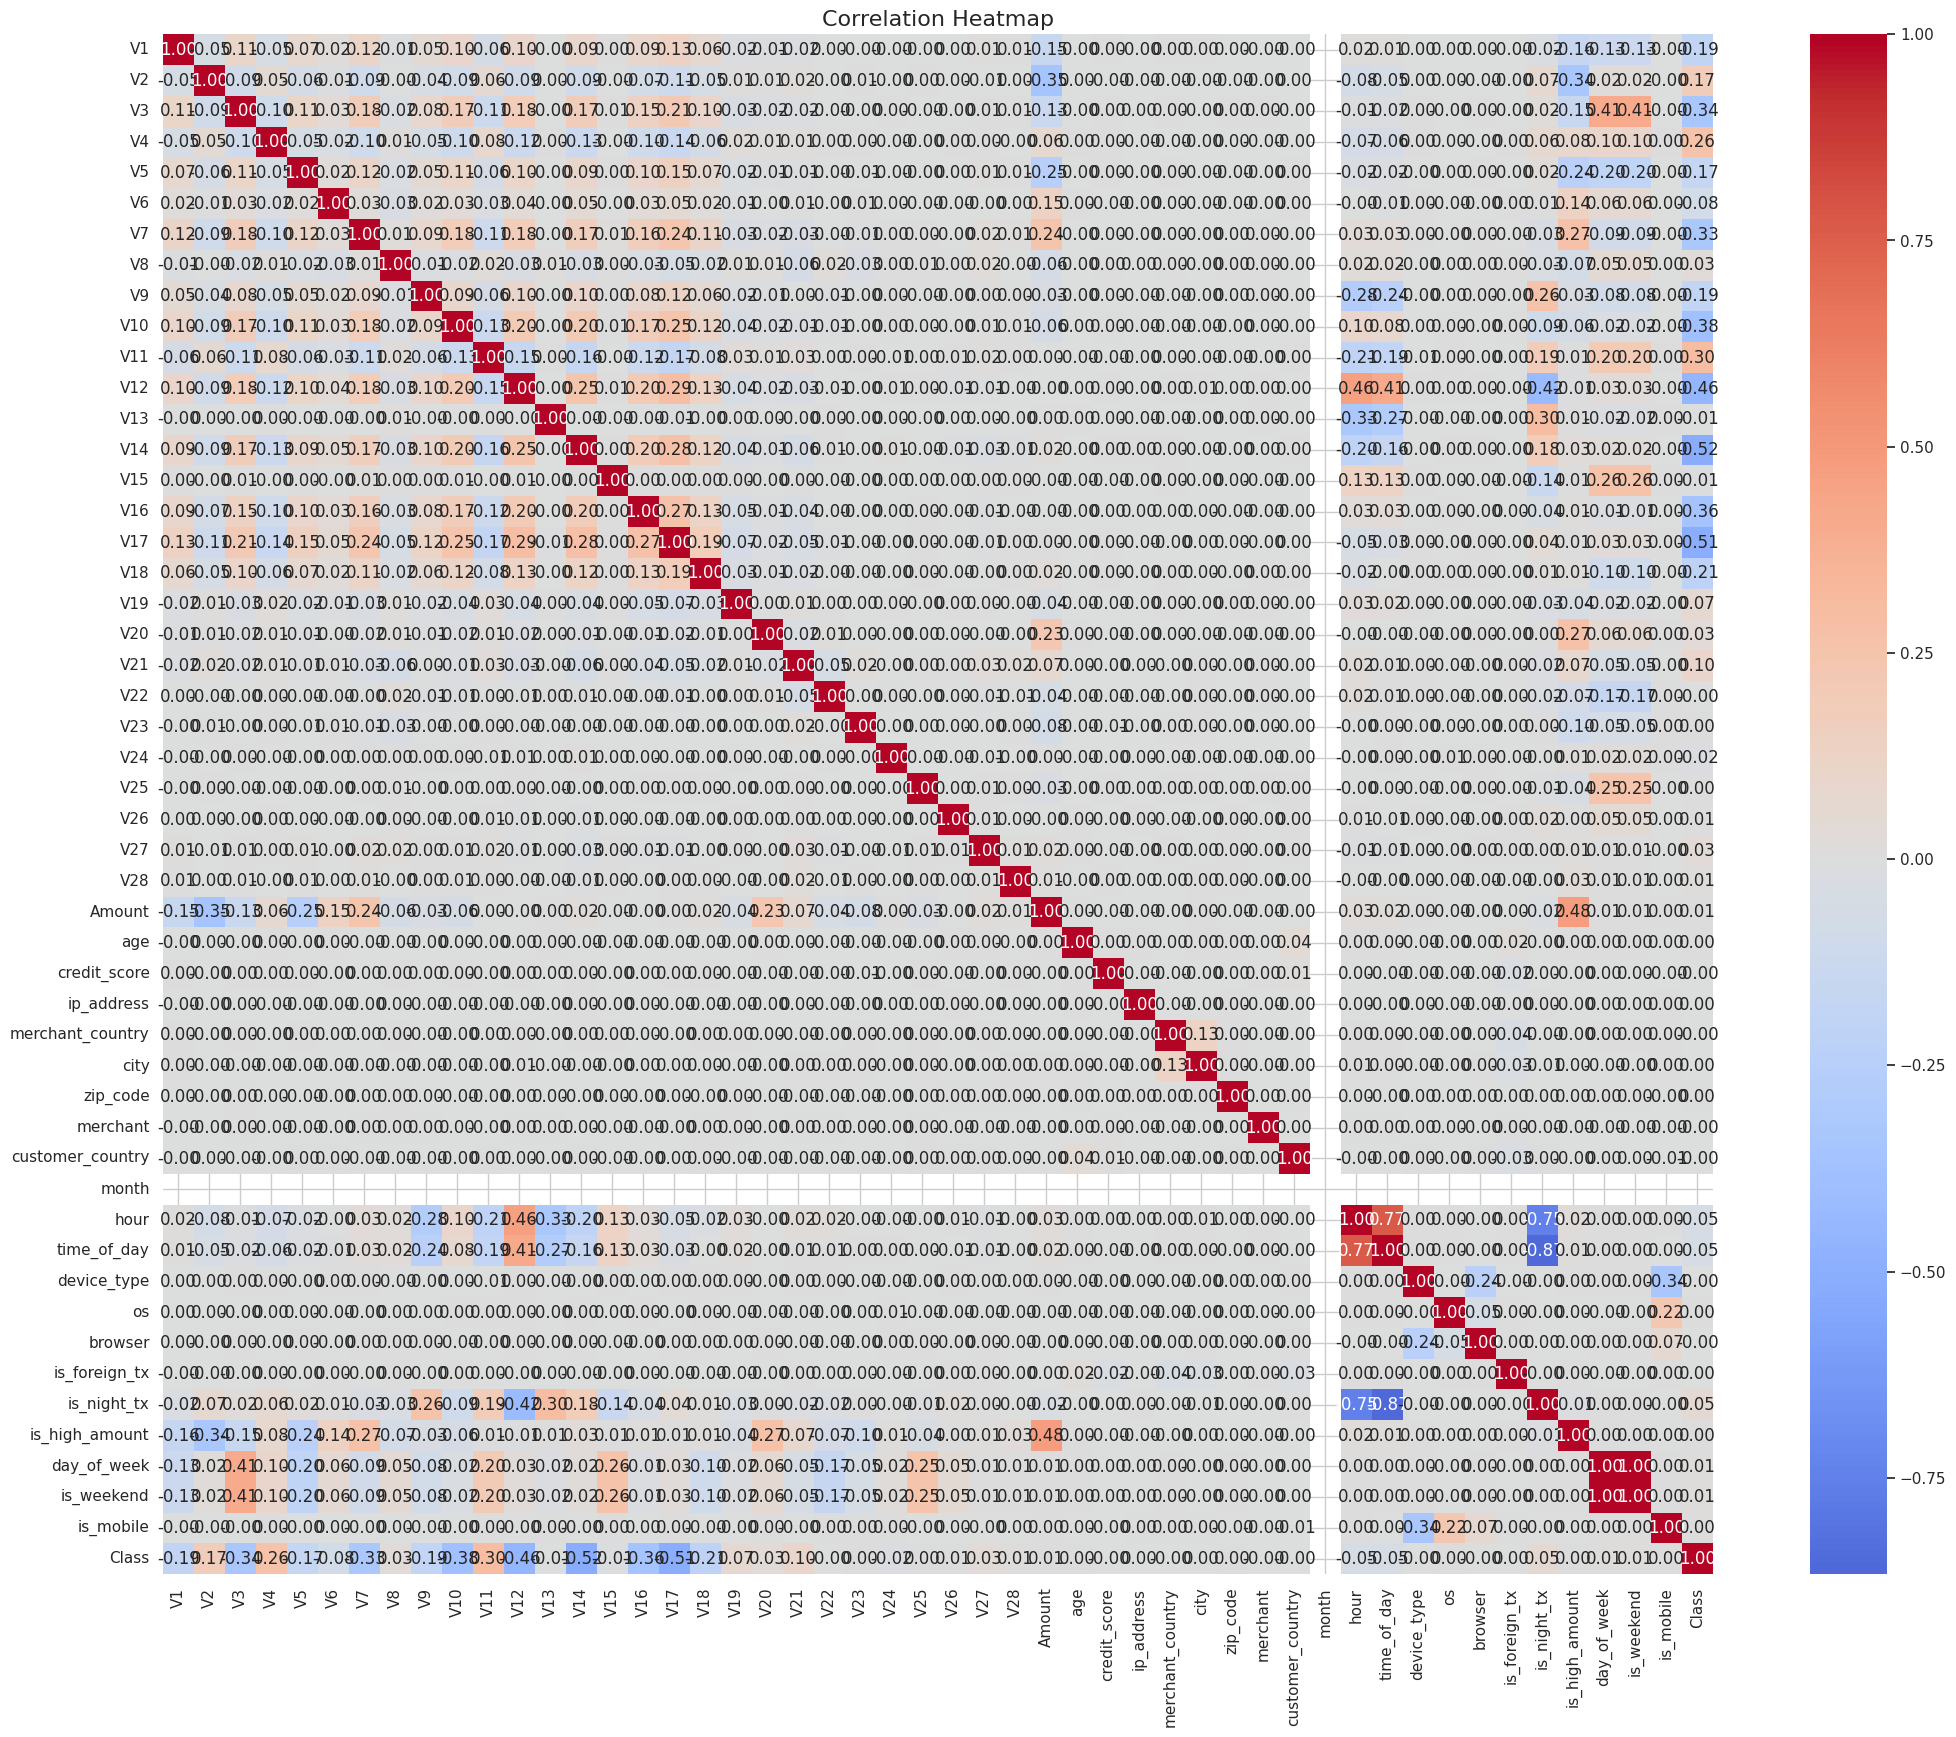

In [66]:
# We compute the correlation matrix
plt.figure(figsize=(25,20))
corr_matrix = corr_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

corr_with_Class
V14        -0.520908
V17        -0.505913
V12        -0.456149
V10        -0.384570
V16        -0.359038
V3         -0.341715
V7         -0.325747
V11         0.297107
V4          0.257246
V18        -0.212939
V1         -0.190232
V9         -0.186133
V5         -0.173574
V2          0.172225
V21         0.098384

corr_with_Class
age                      0.002940
credit_score            -0.002856
os                       0.002317
is_high_amount           0.002226
customer_country        -0.002188
merchant_country        -0.001637
V23                      0.001457
zip_code                 0.001239
browser                 -0.001219
device_type             -0.001008
is_foreign_tx            0.000771
ip_address               0.000769
merchant                -0.000713
city                     0.000446
month                         NaN

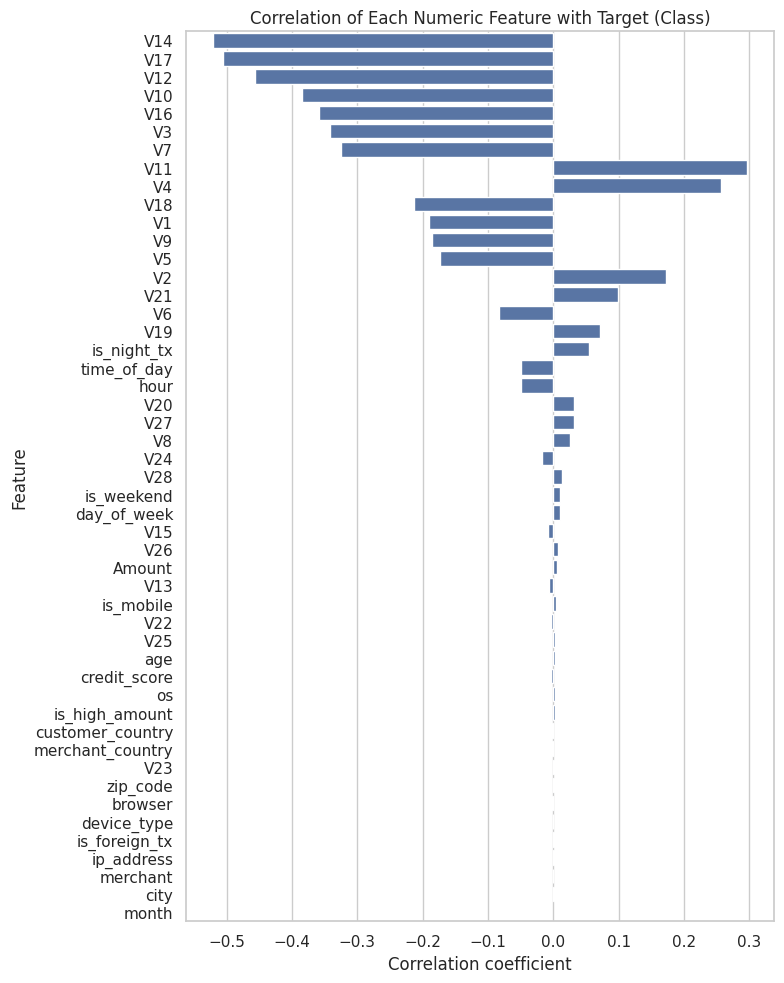

from matplotlib import pyplot as plt
_df_0['corr_with_Class'].plot(kind='hist', bins=20, title='corr_with_Class')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['corr_with_Class'].plot(kind='line', figsize=(8, 4), title='corr_with_Class')
plt.gca().spines[['top', 'right']].set_visible(False)

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [67]:
# Keep only numeric columns (Class must be numeric 0/1)
# Correlation matrix and correlation vs target
target_corr = corr_matrix['Class'].drop(labels=['Class'])

# Sort by absolute correlation magnitude (most informative first)
target_corr_sorted = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)

# Show top/bottom features
display(target_corr_sorted.head(15).to_frame('corr_with_Class'))
display(target_corr_sorted.tail(15).to_frame('corr_with_Class'))

# Plot
plt.figure(figsize=(8, 10))
sns.barplot(
    x=target_corr_sorted.values,
    y=target_corr_sorted.index
)
plt.title("Correlation of Each Numeric Feature with Target (Class)")
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Feature Engineering